This notebook is licensed under the MIT License.

MIT License

Copyright (c) 2023 Michael Tullius

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
import datetime
from enum import auto, Enum
import os
import pathlib
import sys

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

from lifelines import KaplanMeierFitter

from lifelines.statistics import multivariate_logrank_test
from lifelines.statistics import pairwise_logrank_test
from lifelines.utils import survival_events_from_table

from IPython.display import display, HTML

from mvt_survival import AlphaColor, create_p_value_legend_figure
from mvt_survival import get_corrected_p_values, create_stats_df, create_stats_df_with_corrected_p_values
from mvt_survival import create_proportion_and_stats_df
from mvt_survival import kmf_fit_group, get_stats_from_kmf
from mvt_survival import create_pairwise_plot, get_pairwise_comparisons_and_mosaic_layout
from mvt_survival import SaveDataFrames, concat_pdf_files, display_df

In [2]:
now = datetime.datetime.now()
todays_date = str(now.date())
print(f"Date: {now.strftime('%Y-%m-%d %H:%M')}")

print("Python version: %s\n" % sys.version)

pd.show_versions()

Date: 2023-03-28 15:22
Python version: 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:12:32) [MSC v.1929 64 bit (AMD64)]



C:\Users\mitullius\.conda\envs\py311-survival\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



INSTALLED VERSIONS
------------------
commit           : 2e218d10984e9919f0296931d92ea851c6a6faf5
python           : 3.11.0.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
Version          : 10.0.19045
machine          : AMD64
processor        : Intel64 Family 6 Model 165 Stepping 5, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : English_United States.1252

pandas           : 1.5.3
numpy            : 1.24.2
pytz             : 2022.7.1
dateutil         : 2.8.2
setuptools       : 67.5.1
pip              : 23.0.1
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 3.1.2
IPython          : 8.11.0
pandas_datareader: None
bs4              : 4.11.2
bottleneck       : None
brot

In [3]:
class ExperimentName(Enum):
    EXAMPLE = auto()
    
    Bp_m01 = auto()
    Bp_m02 = auto()
    Bp_m03A = auto()
    Bp_m03B = auto()
    Bp_m06_low = auto()
    Bp_m06_medium = auto()
    Bp_m06_high = auto()
    Bp_m09 = auto()
    
    Bp_m01_combined_LVS = auto()
    Bp_m02_combined_LVS = auto()
    Bp_m03A_combined_LVS = auto()
    Bp_m03B_combined_LVS = auto()
    Bp_m06_low_combined_LVS = auto()
    Bp_m06_medium_combined_LVS = auto()
    Bp_m06_high_combined_LVS = auto()

class Experiment:
    
    def __init__(self, name, input_directory, input_file_name):
        
        self.name = name
        self.input_directory = input_directory
        self.input_file_name = input_file_name


In [4]:
INPUT_DIRECTORY = r'C:\Users\mitullius\Notebook\2023\Bp vaccine paper\survival data'

experiments = {}

experiments[ExperimentName.EXAMPLE] = Experiment(ExperimentName.Bp_m01.name,
                                                './example',
                                                'EXAMPLE_survival.csv')
 
experiments[ExperimentName.Bp_m01] = Experiment(ExperimentName.Bp_m01.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m01_survival.csv')

experiments[ExperimentName.Bp_m02] = Experiment(ExperimentName.Bp_m02.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m02_survival.csv')

experiments[ExperimentName.Bp_m03A] = Experiment(ExperimentName.Bp_m03A.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m03A_survival.csv')

experiments[ExperimentName.Bp_m03B] = Experiment(ExperimentName.Bp_m03B.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m03B_survival.csv')

experiments[ExperimentName.Bp_m06_low] = Experiment(ExperimentName.Bp_m06_low.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m06_low_survival.csv')

experiments[ExperimentName.Bp_m06_medium] = Experiment(ExperimentName.Bp_m06_medium.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m06_medium_survival.csv')

experiments[ExperimentName.Bp_m06_high] = Experiment(ExperimentName.Bp_m06_high.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m06_high_survival.csv')

experiments[ExperimentName.Bp_m09] = Experiment(ExperimentName.Bp_m09.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m09_survival.csv')

# These are the same experiments as above, but with LVS vaccine groups delivered by the ID route and/or the IN route combined

experiments[ExperimentName.Bp_m01_combined_LVS] = Experiment(ExperimentName.Bp_m01_combined_LVS.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m01_survival.csv')

experiments[ExperimentName.Bp_m02_combined_LVS] = Experiment(ExperimentName.Bp_m02_combined_LVS.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m02_survival.csv')

experiments[ExperimentName.Bp_m03A_combined_LVS] = Experiment(ExperimentName.Bp_m03A_combined_LVS.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m03A_survival.csv')

experiments[ExperimentName.Bp_m03B_combined_LVS] = Experiment(ExperimentName.Bp_m03B_combined_LVS.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m03B_survival.csv')

experiments[ExperimentName.Bp_m06_low_combined_LVS] = Experiment(ExperimentName.Bp_m06_low_combined_LVS.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m06_low_survival.csv')

experiments[ExperimentName.Bp_m06_medium_combined_LVS] = Experiment(ExperimentName.Bp_m06_medium_combined_LVS.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m06_medium_survival.csv')

experiments[ExperimentName.Bp_m06_high_combined_LVS] = Experiment(ExperimentName.Bp_m06_high_combined_LVS.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m06_high_survival.csv')

class CombinedGroups:
    
    def __init__(self, name, groups_ID=None, groups_ID_name=None, groups_IN=None, groups_IN_name=None):
        
        self.name = name
        self.groups_ID = groups_ID
        self.combined_group_ID = None
        
        if self.groups_ID and groups_ID_name == None:
            self.combined_group_ID = ''.join(self.groups_ID)
            self.groups_ID_name = f"Groups {self.combined_group_ID} Combined LVS Groups (ID)"
            
        self.groups_IN = groups_IN
        self.groups_IN_name = groups_IN_name
        self.combined_group_IN = None
        
        if self.groups_IN and groups_IN_name == None:
            self.combined_group_IN = ''.join(self.groups_IN)
            self.groups_IN_name = f"Groups {''.join(self.combined_group_IN)} Combined LVS Groups (IN)"
        
    def __repr__(self):
        return f'''CombinedGroups("{self.name=}",
        "{self.groups_ID=}",
        "{self.groups_ID_name=}",
        "{self.combined_group_ID=}",
        "{self.groups_IN=}",
        "{self.groups_IN_name=}",
        "{self.combined_group_IN=}")
        '''
    
LVS_groups_to_combine = {}

LVS_groups_to_combine[ExperimentName.Bp_m01_combined_LVS] = CombinedGroups(ExperimentName.Bp_m01_combined_LVS,
                                                                           groups_ID=['C', 'D', 'E', 'F', 'G'])

LVS_groups_to_combine[ExperimentName.Bp_m02_combined_LVS] = CombinedGroups(ExperimentName.Bp_m02_combined_LVS,
                                                                           groups_ID=['C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L'])

LVS_groups_to_combine[ExperimentName.Bp_m03A_combined_LVS] = CombinedGroups(ExperimentName.Bp_m03A_combined_LVS,
                                                                           groups_ID=['C', 'G', 'K'],
                                                                           groups_IN=['D', 'E', 'F', 'H', 'I', 'J','L', 'M', 'N'])

LVS_groups_to_combine[ExperimentName.Bp_m03B_combined_LVS] = CombinedGroups(ExperimentName.Bp_m03B_combined_LVS,
                                                                           groups_ID=['Q', 'S', 'U'],
                                                                           groups_IN=['R', 'T', 'V'])

LVS_groups_to_combine[ExperimentName.Bp_m06_low_combined_LVS] = CombinedGroups(ExperimentName.Bp_m06_low_combined_LVS,
                                                                           groups_ID=['C', 'D'])

LVS_groups_to_combine[ExperimentName.Bp_m06_medium_combined_LVS] = CombinedGroups(ExperimentName.Bp_m06_medium_combined_LVS,
                                                                           groups_ID=['G', 'H'])

LVS_groups_to_combine[ExperimentName.Bp_m06_high_combined_LVS] = CombinedGroups(ExperimentName.Bp_m06_high_combined_LVS,
                                                                           groups_ID=['K', 'L'])

LVS_groups_to_combine

{<ExperimentName.Bp_m01_combined_LVS: 10>: CombinedGroups("self.name=<ExperimentName.Bp_m01_combined_LVS: 10>",
         "self.groups_ID=['C', 'D', 'E', 'F', 'G']",
         "self.groups_ID_name='Groups CDEFG Combined LVS Groups (ID)'",
         "self.combined_group_ID='CDEFG'",
         "self.groups_IN=None",
         "self.groups_IN_name=None",
         "self.combined_group_IN=None")
         ,
 <ExperimentName.Bp_m02_combined_LVS: 11>: CombinedGroups("self.name=<ExperimentName.Bp_m02_combined_LVS: 11>",
         "self.groups_ID=['C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']",
         "self.groups_ID_name='Groups CDEFGHIJKL Combined LVS Groups (ID)'",
         "self.combined_group_ID='CDEFGHIJKL'",
         "self.groups_IN=None",
         "self.groups_IN_name=None",
         "self.combined_group_IN=None")
         ,
 <ExperimentName.Bp_m03A_combined_LVS: 12>: CombinedGroups("self.name=<ExperimentName.Bp_m03A_combined_LVS: 12>",
         "self.groups_ID=['C', 'G', 'K']",
        

In [5]:
EXAMPLE = False

if EXAMPLE:
    exp = experiments[ExperimentName.EXAMPLE]
    input_path = pathlib.Path(exp.input_directory).absolute()
else:
    input_path = pathlib.Path(INPUT_DIRECTORY).absolute()


python_path = pathlib.Path(os.getcwd())
output_path = input_path / f'output {todays_date}'
output_path.mkdir(parents=True, exist_ok=True)

print('\n')
print(f'Python notebook directory:\t{python_path}')
print(f'Input directory:\t\t{input_path}')
print(f'Output directory:\t\t{output_path}')
print('\n')



Python notebook directory:	C:\Users\mitullius\Notebook\2023\Python\Bp-survival-analysis
Input directory:		C:\Users\mitullius\Notebook\2023\Bp vaccine paper\survival data
Output directory:		C:\Users\mitullius\Notebook\2023\Bp vaccine paper\survival data\output 2023-03-28




p_value_image_filename=WindowsPath('C:/Users/mitullius/Notebook/2023/Bp vaccine paper/survival data/output 2023-03-28/p-values.pdf')


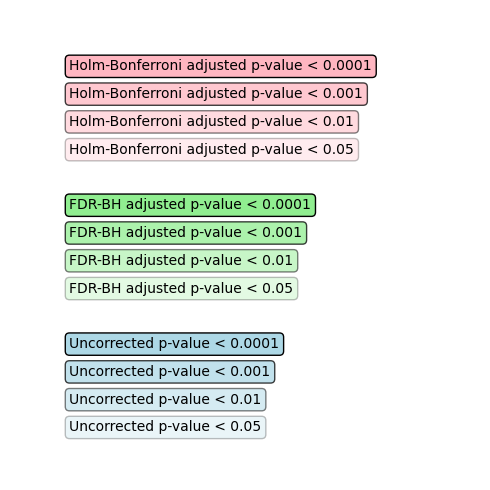

In [6]:
p_value_image_filename = output_path / 'p-values.pdf'
print(f'{p_value_image_filename=}')

holm_corrected_p_value_colors = {0.0001:('lightpink', 1),
                            0.001:('lightpink', 0.75),
                            0.01:('lightpink', 0.5),
                            0.05:('lightpink', 0.25)}

fdr_corrected_p_value_colors = {0.0001:('lightgreen', 1),
                            0.001:('lightgreen', 0.75),
                            0.01:('lightgreen', 0.5),
                            0.05:('lightgreen', 0.25)}

uncorrected_p_value_colors = {0.0001:('lightblue', 1),
                              0.001:('lightblue', 0.75),
                              0.01:('lightblue', 0.5),
                              0.05:('lightblue', 0.25)}

alpha_color = AlphaColor(holm_corrected_p_value_colors, fdr_corrected_p_value_colors, uncorrected_p_value_colors)

fig = create_p_value_legend_figure(['Holm-Bonferroni', 'FDR-BH'], alpha_color, p_value_image_filename)

# Analyze Survival Data from all Experiments

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           96 non-null     object
 1   Group_Name                      96 non-null     object
 2   Mouse                           96 non-null     object
 3   Day                             96 non-null     int64 
 4   Death                           96 non-null     int64 
 5   Survival_with_sterile_immunity  96 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 33.1 KB


Group                                         Group_Name Mouse  Day  Death  \
0      A                                      Group A (PBS)    A1    3      1   
1      A                                      Group A (PBS)    A2    3      1   
2      A                                      Group A (PBS)    A3    3      1   
3      A                                      Group A (PBS)    A4    3      1   
4      A                                      Group A (PBS)    A5    3      1   
..   ...                                                ...   ...  ...    ...   
91     L  Group L (rLVS ΔcapB/Bp Hcp6-Hcp2 + rLVS ΔcapB/...    L4   42      0   
92     L  Group L (rLVS ΔcapB/Bp Hcp6-Hcp2 + rLVS ΔcapB/...    L5   42      0   
93     L  Group L (rLVS ΔcapB/Bp Hcp6-Hcp2 + rLVS ΔcapB/...    L6   42      0   
94     L  Group L (rLVS ΔcapB/Bp Hcp6-Hcp2 + rLVS ΔcapB/...    L7   42      0   
95     L  Group L (rLVS ΔcapB/Bp Hcp6-Hcp2 + rLVS ΔcapB/...    L8   29      1   

    Survival_with_sterile_immunity  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0  
..                             ...  
91                               1  
92                               1  
93                               1  
94                               1  
95                               0  

[96 rows x 6 columns]

Group     Group_Name Mouse        Day      Death  \
count     96             96    96  96.000000  96.000000   
unique    12             12    96        NaN        NaN   
top        A  Group A (PBS)    A1        NaN        NaN   
freq       8              8     1        NaN        NaN   
mean     NaN            NaN   NaN  26.822917   0.468750   
std      NaN            NaN   NaN  17.889718   0.501642   
min      NaN            NaN   NaN   3.000000   0.000000   
25%      NaN            NaN   NaN   3.000000   0.000000   
50%      NaN            NaN   NaN  42.000000   0.000000   
75%      NaN            NaN   NaN  42.000000   1.000000   
max      NaN            NaN   NaN  42.000000   1.000000   

        Survival_with_sterile_immunity  
count                        96.000000  
unique                             NaN  
top                                NaN  
freq                               NaN  
mean                          0.385417  
std                           0.489248  
min                           0.000000  
25%                           0.000000  
50%                           0.000000  
75%                           1.000000  
max                           1.000000

Day
0     3
1     4
2    19
3    20
4    23
5    27
6    29
7    30
8    35
9    40
10   42

Group
0      A
1      B
2      C
3      D
4      E
5      F
6      G
7      H
8      I
9      J
10     K
11     L

Group_Name
0                                       Group A (PBS)
1                                 Group B (Bp82, 1e6)
2                            Group C (LVS ΔcapB, 1e6)
3              Group D (rLVS ΔcapB/Bp Hcp6-Hcp1, 1e6)
4              Group E (rLVS ΔcapB/Bp Hcp6-Hcp2, 1e6)
5              Group F (rLVS ΔcapB/Bp LolC-Hcp1, 1e6)
6              Group G (rLVS ΔcapB/Bp LolC-Hcp2, 1e6)
7   Group H (rLVS ΔcapB/Bp Hcp6-Hcp1 + rLVS ΔcapB/...
8   Group I (rLVS ΔcapB/Bp Hcp6-Hcp2 + rLVS ΔcapB/...
9   Group J (rLVS ΔcapB/Bp Hcp6 + rLVS ΔcapB/Bp Lo...
10  Group K (rLVS ΔcapB/Bp Hcp6-Hcp1 + rLVS ΔcapB/...
11  Group L (rLVS ΔcapB/Bp Hcp6-Hcp2 + rLVS ΔcapB/...

Mouse
0     A1
1     A2
2     A3
3     A4
4     A5
..   ...
91    L4
92    L5
93    L6
94    L7
95    L8

[96 rows x 1 columns]

Death
0      0
1      1

Survival_with_sterile_immunity
0                               0
1                               1

Group_1 Group_2 pair  uncorrected_p_value  p_value_fdr_bh  \
index                                                             
0           A       B  A-B             0.000636        0.001750   
1           A       C  A-C             1.000000        1.000000   
2           A       D  A-D             0.000108        0.000591   
3           A       E  A-E             0.000636        0.001750   
4           A       F  A-F             0.009023        0.022057   
...       ...     ...  ...                  ...             ...   
61          I       K  I-K             0.000108        0.000591   
62          I       L  I-L             0.000108        0.000591   
63          J       K  J-K             0.910704        1.000000   
64          J       L  J-L             0.972867        1.000000   
65          K       L  K-L             0.910704        1.000000   

       p_value_holm_bonferroni  p_value_holm_sidak sig_uncorrected sig_fdr_bh  \
index                                                                           
0                     0.034360            0.033787             ***         **   
1                     1.000000            1.000000              ns         ns   
2                     0.007096            0.007071             ***        ***   
3                     0.034360            0.033787             ***         **   
4                     0.378984            0.316620              **          *   
...                        ...                 ...             ...        ...   
61                    0.007096            0.007071             ***        ***   
62                    0.007096            0.007071             ***        ***   
63                    1.000000            1.000000              ns         ns   
64                    1.000000            1.000000              ns         ns   
65                    1.000000            1.000000              ns         ns   

      sig_holm_bonferroni sig_holm_sidak  
index                                     
0                       *              *  
1                      ns             ns  
2                      **             **  
3                       *              *  
4                      ns             ns  
...                   ...            ...  
61                     **             **  
62                     **             **  
63                     ns             ns  
64                     ns             ns  
65                     ns             ns  

[66 rows x 11 columns]

final_survival  upper_0.95  lower_0.95  median_survival_time
Group                                                              
A               0.000    0.000000    0.000000                   3.0
B               0.750    0.930898    0.314807                   inf
C               0.000    0.000000    0.000000                   3.0
D               0.875    0.981393    0.387000                   inf
E               0.875    0.981393    0.387000                   inf
F               0.375    0.674363    0.087006                  23.0
G               0.375    0.674363    0.087006                  40.0
H               0.875    0.981393    0.387000                   inf
I               0.000    0.000000    0.000000                   3.0
J               0.750    0.930898    0.314807                   inf
K               0.750    0.930898    0.314807                   inf
L               0.750    0.930898    0.314807                   inf

Group  Died  Survived  total_mice  Survival_with_sterile_immunity  \
0      A     8         0           8                               0   
1      B     2         6           8                               4   
2      C     8         0           8                               0   
3      D     1         7           8                               6   
4      E     1         7           8                               4   
5      F     5         3           8                               2   
6      G     5         3           8                               3   
7      H     1         7           8                               3   
8      I     8         0           8                               0   
9      J     2         6           8                               5   
10     K     2         6           8                               4   
11     L     2         6           8                               6   

    not_sterile  percent_survival  percent_sterile  
0             8               0.0              0.0  
1             4              75.0             50.0  
2             8               0.0              0.0  
3             2              87.5             75.0  
4             4              87.5             50.0  
5             6              37.5             25.0  
6             5              37.5             37.5  
7             5              87.5             37.5  
8             8               0.0              0.0  
9             3              75.0             62.5  
10            4              75.0             50.0  
11            2              75.0             75.0

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      A-B                     0.001892                0.005947   
1      A-C                     1.000000                1.000000   
2      A-D                     0.000305                0.002238   
3      A-E                     0.000305                0.002238   
4      A-F                     0.081982                0.163964   
...    ...                          ...                     ...   
61     I-K                     0.001892                0.005947   
62     I-L                     0.001892                0.005947   
63     J-K                     1.000000                1.000000   
64     J-L                     1.000000                1.000000   
65     K-L                     1.000000                1.000000   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.107849                    0.102329   
1                             1.000000                    1.000000   
2                             0.020142                    0.019943   
3                             0.020142                    0.019943   
4                             1.000000                    0.964421   
...                                ...                         ...   
61                            0.107849                    0.102329   
62                            0.107849                    0.102329   
63                            1.000000                    1.000000   
64                            1.000000                    1.000000   
65                            1.000000                    1.000000   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          **                 **                          ns   
1                          ns                 ns                          ns   
2                         ***                 **                           *   
3                         ***                 **                           *   
4                          ns                 ns                          ns   
...                       ...                ...                         ...   
61                         **                 **                          ns   
62                         **                 **                          ns   
63                         ns                 ns                          ns   
64                         ns                 ns                          ns   
65                         ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                          *  
3                          *  
4                         ns  
...                      ...  
61                        ns  
62                        ns  
63                        ns  
64                        ns  
65                        ns  

[66 rows x 9 columns]

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      A-B                     0.026001                0.095337   
1      A-C                     1.000000                1.000000   
2      A-D                     0.001892                0.020813   
3      A-E                     0.026001                0.095337   
4      A-F                     0.198547                0.385415   
...    ...                          ...                     ...   
61     I-K                     0.026001                0.095337   
62     I-L                     0.001892                0.020813   
63     J-K                     0.621857                0.832073   
64     J-L                     0.731109                0.832073   
65     K-L                     0.391784                0.601342   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             1.000000                    0.758921   
1                             1.000000                    1.000000   
2                             0.124878                    0.117500   
3                             1.000000                    0.758921   
4                             1.000000                    0.999568   
...                                ...                         ...   
61                            1.000000                    0.758921   
62                            0.124878                    0.117500   
63                            1.000000                    1.000000   
64                            1.000000                    1.000000   
65                            1.000000                    1.000000   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                           *                 ns                          ns   
1                          ns                 ns                          ns   
2                          **                  *                          ns   
3                           *                 ns                          ns   
4                          ns                 ns                          ns   
...                       ...                ...                         ...   
61                          *                 ns                          ns   
62                         **                  *                          ns   
63                         ns                 ns                          ns   
64                         ns                 ns                          ns   
65                         ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns  
3                         ns  
4                         ns  
...                      ...  
61                        ns  
62                        ns  
63                        ns  
64                        ns  
65                        ns  

[66 rows x 9 columns]

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 11
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          75.63 <0.005     36.50

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
     test_statistic      p  -log2(p)
A B           11.67 <0.005     10.62
  C            0.00   1.00     -0.00
  D           15.00 <0.005     13.18
  E           11.67 <0.005     10.62
  F            6.82   0.01      6.79
  G           11.67 <0.005     10.62
  H           11.67 <0.005     10.62
  I            0.00   1.00     -0.00
  J           15.00 <0.005     13.18
  K           15.00 <0.005     13.18
  L           15.00 <0.005     13.18
B C           11.67 <0.005     10.62
  D            0.49   0.48      1.05
  E            0.35   0.55      0.85
  F            2.19   0.14      2.84
  G            1.48   0.22      2.16
  H            0.35   0.55      0.85
  I           11.67 <0.005     10.62
  J            0.02   0.89      0.18
  K            0.03   0.86      0.22
  L            0.02   0.89      0.18
C D           15.00 <0.005     13.18
  E           11.67 <0.005     10.62
  F            6.82   0.01      6.79
  G           11.67 <0.005     10.62
  H           11.67 <0.005     10.62
  I            0.00   1.00     -0.00
  J           15.00 <0.005     13.18
  K           15.00 <0.005     13.18
  L           15.00 <0.005     13.18
D E            0.00   0.96      0.06
  F            4.65   0.03      5.01
  G            4.05   0.04      4.50
  H            0.00   0.96      0.06
  I           15.00 <0.005     13.18
  J            0.29   0.59      0.76
  K            0.46   0.50      1.01
  L            0.29   0.59      0.76
E F            3.87   0.05      4.34
  G            3.51   0.06      4.04
  H            0.00   1.00     -0.00
  I           11.67 <0.005     10.62
  J            0.29   0.59      0.76
  K            0.26   0.61      0.72
  L            0.29   0.59      0.76
F G            0.17   0.68      0.55
  H            3.87   0.05      4.34
  I            6.82   0.01      6.79
  J            3.22   0.07      3.78
  K            2.74   0.10      3.35
  L            3.22   0.07      3.78
G H            3.51   0.06      4.04
  I           11.67 <0.005     10.62
  J            2.17   0.14      2.83
  K            2.08   0.15      2.75
  L            2.17   0.14      2.83
H I           11.67 <0.005     10.62
  J            0.29   0.59      0.76
  K            0.26   0.61      0.72
  L            0.29   0.59      0.76
I J           15.00 <0.005     13.18
  K           15.00 <0.005     13.18
  L           15.00 <0.005     13.18
J K            0.01   0.91      0.13
  L            0.00   0.97      0.04
K L            0.01   0.91      0.13

{'A': <lifelines.KaplanMeierFitter:"A", fitted with 8 total observations, 0 right-censored observations>,
 'B': <lifelines.KaplanMeierFitter:"B", fitted with 8 total observations, 6 right-censored observations>,
 'C': <lifelines.KaplanMeierFitter:"C", fitted with 8 total observations, 0 right-censored observations>,
 'D': <lifelines.KaplanMeierFitter:"D", fitted with 8 total observations, 7 right-censored observations>,
 'E': <lifelines.KaplanMeierFitter:"E", fitted with 8 total observations, 7 right-censored observations>,
 'F': <lifelines.KaplanMeierFitter:"F", fitted with 8 total observations, 3 right-censored observations>,
 'G': <lifelines.KaplanMeierFitter:"G", fitted with 8 total observations, 3 right-censored observations>,
 'H': <lifelines.KaplanMeierFitter:"H", fitted with 8 total observations, 7 right-censored observations>,
 'I': <lifelines.KaplanMeierFitter:"I", fitted with 8 total observations, 0 right-censored observations>,
 'J': <lifelines.KaplanMeierFitter:"J", fitted

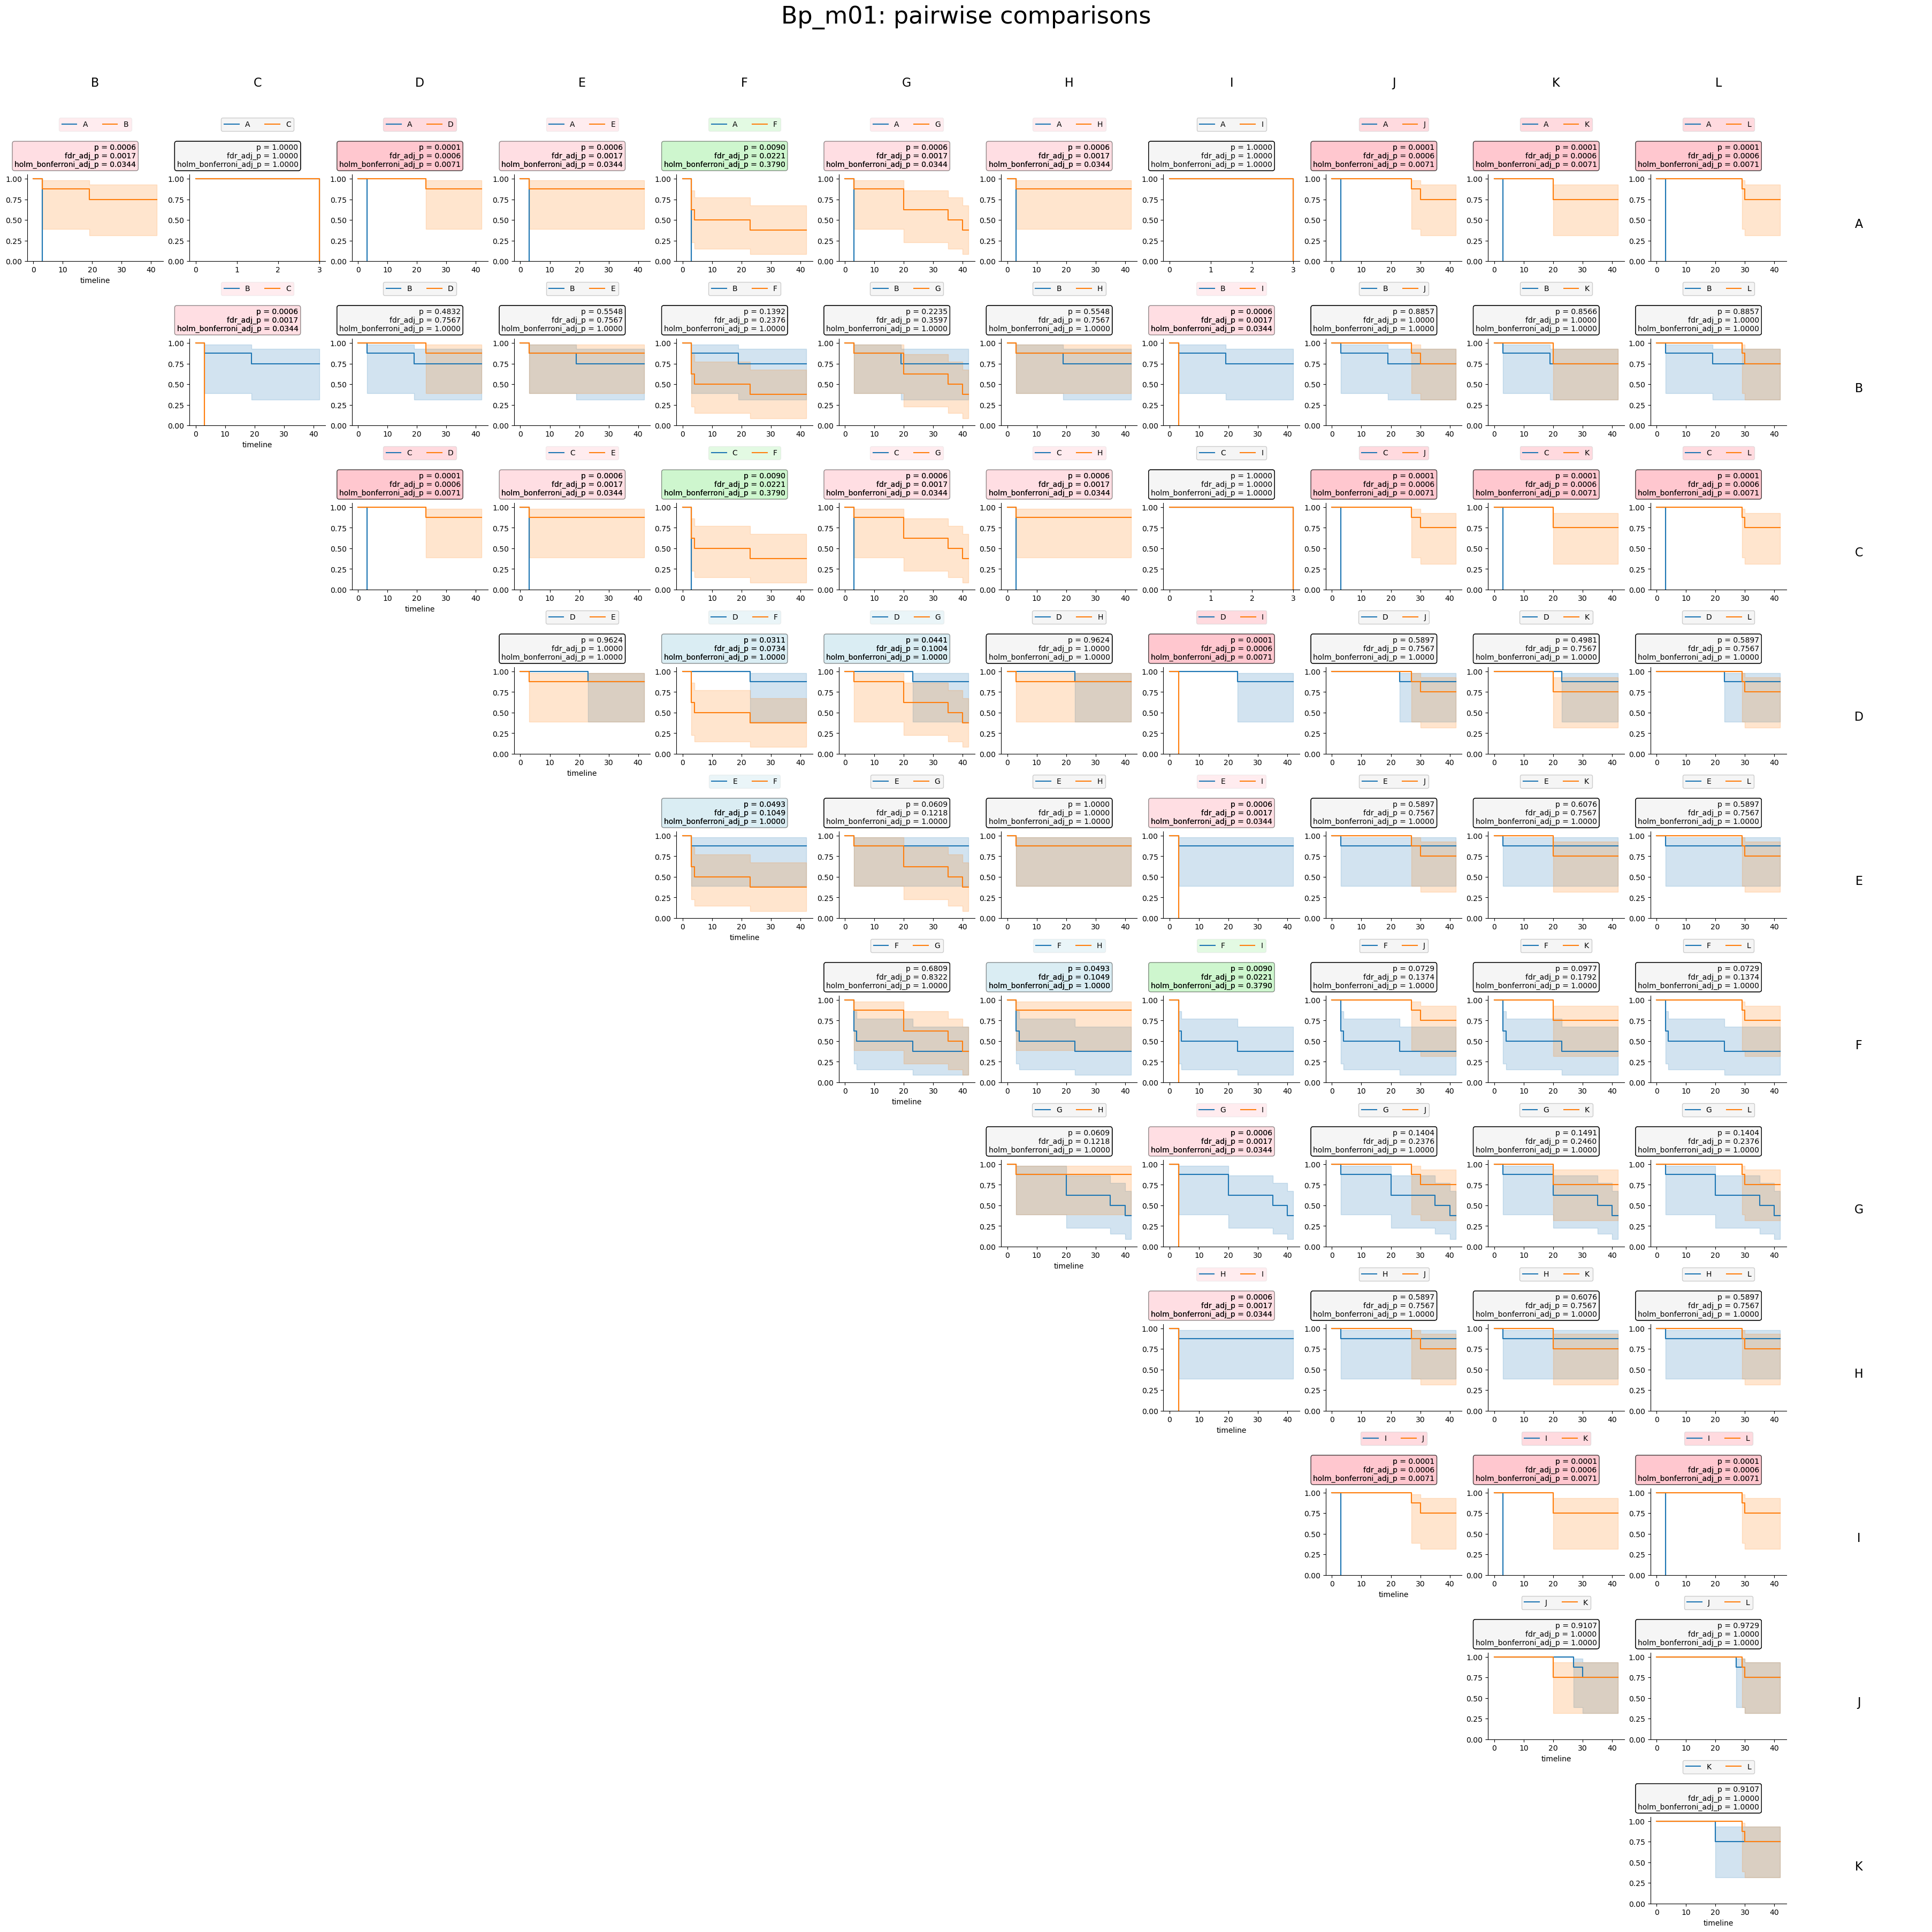

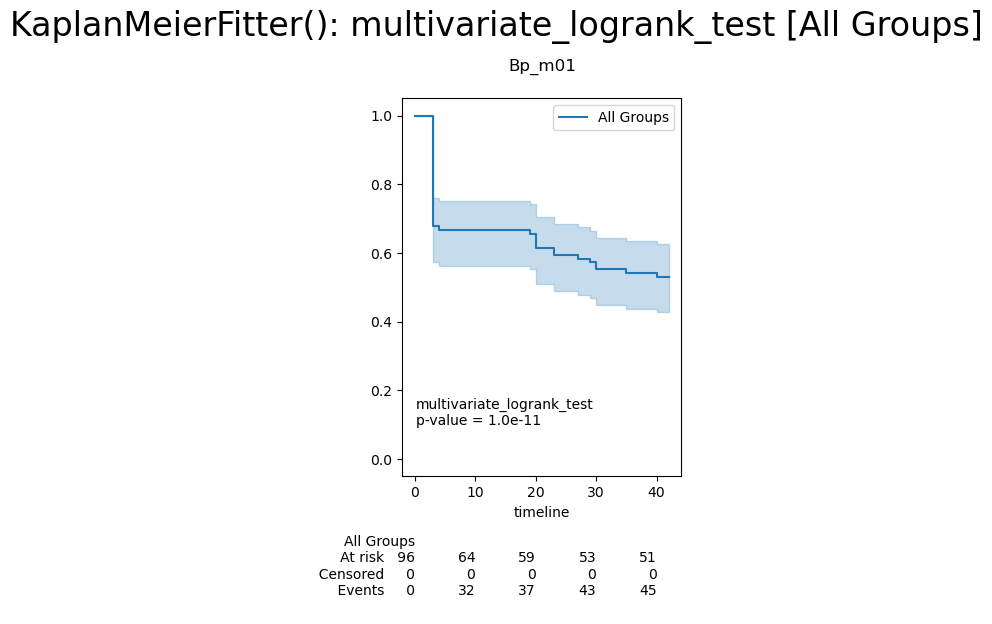

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           92 non-null     object
 1   Group_Name                      92 non-null     object
 2   Mouse                           92 non-null     object
 3   Day                             92 non-null     int64 
 4   Death                           92 non-null     int64 
 5   Survival_with_sterile_immunity  92 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 28.8 KB


Group                                   Group_Name Mouse  Day  Death  \
0      A                                Group A (PBS)    A1    2      1   
1      A                                Group A (PBS)    A2    2      1   
2      A                                Group A (PBS)    A3    2      1   
3      A                                Group A (PBS)    A4    2      1   
4      A                                Group A (PBS)    A5    2      1   
..   ...                                          ...   ...  ...    ...   
87     L  Group L (rLVS ΔcapB/Bp Hcp6-Hcp1-LolC, 2e6)    L4   39      1   
88     L  Group L (rLVS ΔcapB/Bp Hcp6-Hcp1-LolC, 2e6)    L5    2      1   
89     L  Group L (rLVS ΔcapB/Bp Hcp6-Hcp1-LolC, 2e6)    L6   42      0   
90     L  Group L (rLVS ΔcapB/Bp Hcp6-Hcp1-LolC, 2e6)    L7   42      0   
91     L  Group L (rLVS ΔcapB/Bp Hcp6-Hcp1-LolC, 2e6)    L8   42      0   

    Survival_with_sterile_immunity  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0  
..                             ...  
87                               0  
88                               0  
89                               1  
90                               0  
91                               0  

[92 rows x 6 columns]

Group     Group_Name Mouse        Day      Death  \
count     92             92    92  92.000000  92.000000   
unique    12             12    92        NaN        NaN   
top        A  Group A (PBS)    A1        NaN        NaN   
freq       8              8     1        NaN        NaN   
mean     NaN            NaN   NaN  29.043478   0.413043   
std      NaN            NaN   NaN  17.734869   0.495079   
min      NaN            NaN   NaN   2.000000   0.000000   
25%      NaN            NaN   NaN   5.750000   0.000000   
50%      NaN            NaN   NaN  42.000000   0.000000   
75%      NaN            NaN   NaN  42.000000   1.000000   
max      NaN            NaN   NaN  42.000000   1.000000   

        Survival_with_sterile_immunity  
count                        92.000000  
unique                             NaN  
top                                NaN  
freq                               NaN  
mean                          0.315217  
std                           0.467148  
min                           0.000000  
25%                           0.000000  
50%                           0.000000  
75%                           1.000000  
max                           1.000000

Day
0     2
1     3
2     4
3     5
4     6
5     7
6     9
7    25
8    31
9    35
10   39
11   42

Group
0      A
1      B
2      C
3      D
4      E
5      F
6      G
7      H
8      I
9      J
10     K
11     L

Group_Name
0                                      Group A (PBS)
1                                Group B (Bp82, 1e6)
2                           Group C (LVS ΔcapB, 2e6)
3             Group D (rLVS ΔcapB/Bp Hcp6-Hcp1, 1e6)
4             Group E (rLVS ΔcapB/Bp Hcp6-Hcp1, 2e6)
5             Group F (rLVS ΔcapB/Bp Hcp6-Hcp1, 4e6)
6             Group G (rLVS ΔcapB/Bp Hcp6-Hcp1, 8e6)
7             Group H (rLVS ΔcapB/Bp Hcp6-Hcp2, 2e6)
8             Group I (rLVS ΔcapB/Bp Hcp6-Hcp2, 4e6)
9   Group J (rLVS ΔcapB/Bp LolC-Hcp6-Hcp1-Hcp2, 2e6)
10       Group K (rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2, 2e6)
11       Group L (rLVS ΔcapB/Bp Hcp6-Hcp1-LolC, 2e6)

Mouse
0     A1
1     A2
2     A3
3     A4
4     A5
..   ...
87    L4
88    L5
89    L6
90    L7
91    L8

[92 rows x 1 columns]

Death
0      0
1      1

Survival_with_sterile_immunity
0                               0
1                               1

Group_1 Group_2 pair  uncorrected_p_value  p_value_fdr_bh  \
index                                                             
0           A       B  A-B             0.000108        0.001014   
1           A       C  A-C             0.000108        0.001014   
2           A       D  A-D             0.002700        0.014849   
3           A       E  A-E             0.000108        0.001014   
4           A       F  A-F             0.000108        0.001014   
...       ...     ...  ...                  ...             ...   
61          I       K  I-K             0.589708        0.726145   
62          I       L  I-L             0.972867        0.997032   
63          J       K  J-K             0.137261        0.335920   
64          J       L  J-L             0.309656        0.523562   
65          K       L  K-L             0.537699        0.726145   

       p_value_holm_bonferroni  p_value_holm_sidak sig_uncorrected sig_fdr_bh  \
index                                                                           
0                     0.007096            0.007071             ***         **   
1                     0.007096            0.007071             ***         **   
2                     0.148489            0.138163              **          *   
3                     0.007096            0.007071             ***         **   
4                     0.007096            0.007071             ***         **   
...                        ...                 ...             ...        ...   
61                    1.000000            1.000000              ns         ns   
62                    1.000000            1.000000              ns         ns   
63                    1.000000            0.997650              ns         ns   
64                    1.000000            0.999969              ns         ns   
65                    1.000000            1.000000              ns         ns   

      sig_holm_bonferroni sig_holm_sidak  
index                                     
0                      **             **  
1                      **             **  
2                      ns             ns  
3                      **             **  
4                      **             **  
...                   ...            ...  
61                     ns             ns  
62                     ns             ns  
63                     ns             ns  
64                     ns             ns  
65                     ns             ns  

[66 rows x 11 columns]

final_survival  upper_0.95  lower_0.95  median_survival_time
Group                                                              
A               0.000    0.000000    0.000000                   2.0
B               1.000    1.000000    1.000000                   inf
C               0.375    0.674363    0.087006                  42.0
D               0.250    0.558084    0.037067                   5.0
E               0.625    0.860698    0.229333                   inf
F               0.625    0.860698    0.229333                   inf
G               0.625    0.860698    0.229333                   inf
H               0.750    0.960549    0.127947                   inf
I               0.750    0.930898    0.314807                   inf
J               0.500    0.774865    0.152036                   inf
K               0.875    0.981393    0.387000                   inf
L               0.750    0.930898    0.314807                   inf

Group  Died  Survived  total_mice  Survival_with_sterile_immunity  \
0      A     8         0           8                               0   
1      B     0         8           8                               4   
2      C     5         3           8                               2   
3      D     6         2           8                               2   
4      E     3         5           8                               5   
5      F     3         5           8                               2   
6      G     3         5           8                               2   
7      H     1         3           4                               2   
8      I     2         6           8                               2   
9      J     4         4           8                               2   
10     K     1         7           8                               3   
11     L     2         6           8                               3   

    not_sterile  percent_survival  percent_sterile  
0             8               0.0              0.0  
1             4             100.0             50.0  
2             6              37.5             25.0  
3             6              25.0             25.0  
4             3              62.5             62.5  
5             6              62.5             25.0  
6             6              62.5             25.0  
7             2              75.0             50.0  
8             6              75.0             25.0  
9             6              50.0             25.0  
10            5              87.5             37.5  
11            5              75.0             37.5

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      A-B                     0.000031                0.002014   
1      A-C                     0.081982                0.270541   
2      A-D                     0.198547                0.422714   
3      A-E                     0.009216                0.060828   
4      A-F                     0.009216                0.060828   
...    ...                          ...                     ...   
61     I-K                     0.691029                0.861664   
62     I-L                     1.000000                1.000000   
63     J-K                     0.126678                0.395126   
64     J-L                     0.391784                0.680466   
65     K-L                     0.688950                0.861664   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.002014                    0.002012   
1                             1.000000                    0.986115   
2                             1.000000                    0.999777   
3                             0.552979                    0.426239   
4                             0.552979                    0.426239   
...                                ...                         ...   
61                            1.000000                    1.000000   
62                            1.000000                    1.000000   
63                            1.000000                    0.998032   
64                            1.000000                    1.000000   
65                            1.000000                    1.000000   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                        ****                 **                          **   
1                          ns                 ns                          ns   
2                          ns                 ns                          ns   
3                          **                 ns                          ns   
4                          **                 ns                          ns   
...                       ...                ...                         ...   
61                         ns                 ns                          ns   
62                         ns                 ns                          ns   
63                         ns                 ns                          ns   
64                         ns                 ns                          ns   
65                         ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         **  
1                         ns  
2                         ns  
3                         ns  
4                         ns  
...                      ...  
61                        ns  
62                        ns  
63                        ns  
64                        ns  
65                        ns  

[66 rows x 9 columns]

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      A-B                     0.026001                0.770831   
1      A-C                     0.198547                0.770831   
2      A-D                     0.198547                0.770831   
3      A-E                     0.009216                0.608276   
4      A-F                     0.198547                0.770831   
...    ...                          ...                     ...   
61     I-K                     0.731216                1.000000   
62     I-L                     0.731216                1.000000   
63     J-K                     0.731216                1.000000   
64     J-L                     0.731216                1.000000   
65     K-L                     1.000000                1.000000   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             1.000000                    0.819572   
1                             1.000000                    0.999995   
2                             1.000000                    0.999995   
3                             0.608276                    0.457245   
4                             1.000000                    0.999995   
...                                ...                         ...   
61                            1.000000                    1.000000   
62                            1.000000                    1.000000   
63                            1.000000                    1.000000   
64                            1.000000                    1.000000   
65                            1.000000                    1.000000   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                           *                 ns                          ns   
1                          ns                 ns                          ns   
2                          ns                 ns                          ns   
3                          **                 ns                          ns   
4                          ns                 ns                          ns   
...                       ...                ...                         ...   
61                         ns                 ns                          ns   
62                         ns                 ns                          ns   
63                         ns                 ns                          ns   
64                         ns                 ns                          ns   
65                         ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns  
3                         ns  
4                         ns  
...                      ...  
61                        ns  
62                        ns  
63                        ns  
64                        ns  
65                        ns  

[66 rows x 9 columns]

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 11
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          74.79 <0.005     35.97

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
     test_statistic      p  -log2(p)
A B           15.00 <0.005     13.18
  C           15.00 <0.005     13.18
  D            9.00 <0.005      8.53
  E           15.00 <0.005     13.18
  F           15.00 <0.005     13.18
  G           15.00 <0.005     13.18
  H           11.00 <0.005     10.10
  I           15.00 <0.005     13.18
  J           11.67 <0.005     10.62
  K           15.00 <0.005     13.18
  L           11.67 <0.005     10.62
B C            6.89   0.01      6.85
  D            9.13 <0.005      8.64
  E            3.45   0.06      3.98
  F            3.47   0.06      4.00
  G            3.45   0.06      3.98
  H            2.00   0.16      2.67
  I            2.14   0.14      2.80
  J            5.03   0.02      5.32
  K            1.00   0.32      1.66
  L            2.14   0.14      2.80
C D            1.51   0.22      2.19
  E            0.42   0.52      0.95
  F            0.49   0.48      1.05
  G            0.42   0.52      0.95
  H            1.48   0.22      2.16
  I            2.63   0.10      3.25
  J            0.32   0.57      0.81
  K            3.52   0.06      4.04
  L            1.89   0.17      2.56
D E            2.65   0.10      3.27
  F            4.45   0.03      4.84
  G            1.79   0.18      2.46
  H            3.07   0.08      3.65
  I            5.63   0.02      5.83
  J            2.10   0.15      2.76
  K            7.24   0.01      7.13
  L            4.07   0.04      4.52
E F            0.08   0.77      0.37
  G            0.02   0.89      0.17
  H            0.29   0.59      0.76
  I            0.49   0.48      1.05
  J            0.10   0.76      0.40
  K            1.47   0.22      2.15
  L            0.25   0.62      0.70
F G            0.08   0.77      0.37
  H            0.29   0.59      0.77
  I            0.50   0.48      1.06
  J            0.09   0.76      0.40
  K            1.20   0.27      1.87
  L            0.26   0.61      0.71
G H            0.29   0.59      0.76
  I            0.49   0.48      1.05
  J            0.10   0.76      0.40
  K            1.47   0.22      2.15
  L            0.25   0.62      0.70
H I            0.00   1.00      0.00
  J            0.68   0.41      1.29
  K            0.20   0.65      0.62
  L            0.00   1.00      0.00
I J            1.20   0.27      1.87
  K            0.29   0.59      0.76
  L            0.00   0.97      0.04
J K            2.21   0.14      2.87
  L            1.03   0.31      1.69
K L            0.38   0.54      0.90

{'A': <lifelines.KaplanMeierFitter:"A", fitted with 8 total observations, 0 right-censored observations>,
 'B': <lifelines.KaplanMeierFitter:"B", fitted with 8 total observations, 8 right-censored observations>,
 'C': <lifelines.KaplanMeierFitter:"C", fitted with 8 total observations, 3 right-censored observations>,
 'D': <lifelines.KaplanMeierFitter:"D", fitted with 8 total observations, 2 right-censored observations>,
 'E': <lifelines.KaplanMeierFitter:"E", fitted with 8 total observations, 5 right-censored observations>,
 'F': <lifelines.KaplanMeierFitter:"F", fitted with 8 total observations, 5 right-censored observations>,
 'G': <lifelines.KaplanMeierFitter:"G", fitted with 8 total observations, 5 right-censored observations>,
 'H': <lifelines.KaplanMeierFitter:"H", fitted with 4 total observations, 3 right-censored observations>,
 'I': <lifelines.KaplanMeierFitter:"I", fitted with 8 total observations, 6 right-censored observations>,
 'J': <lifelines.KaplanMeierFitter:"J", fitted

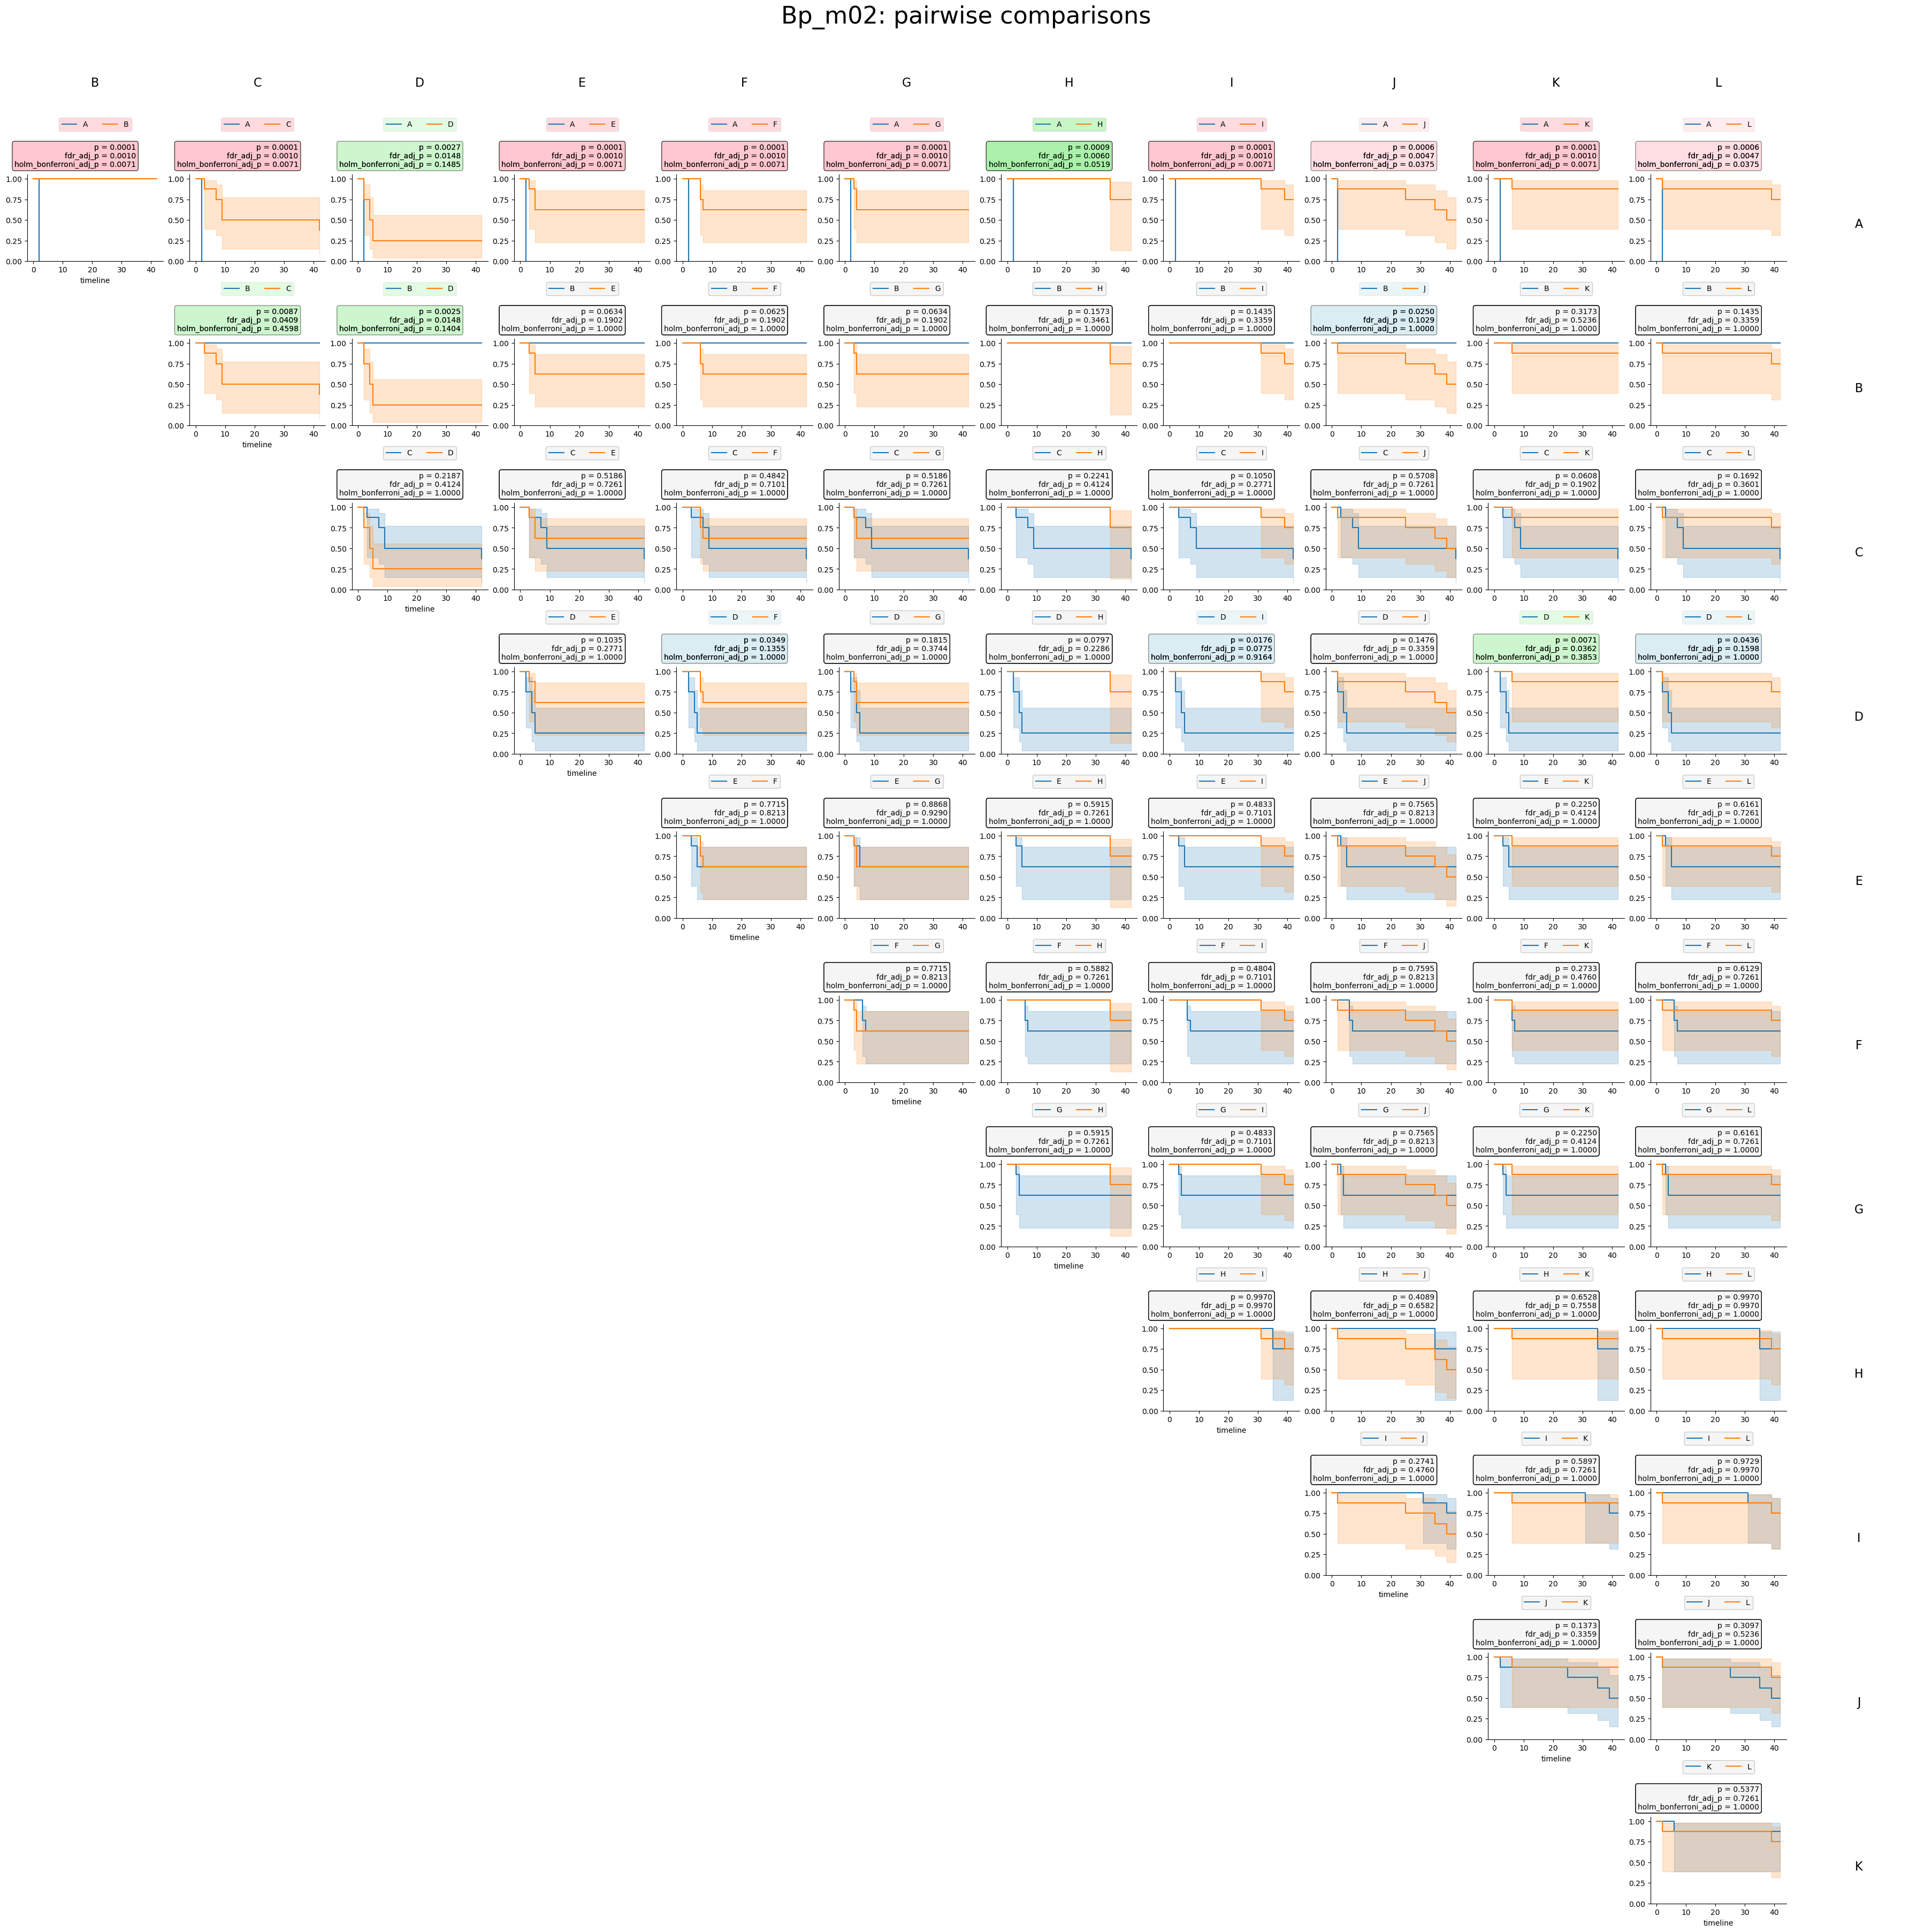

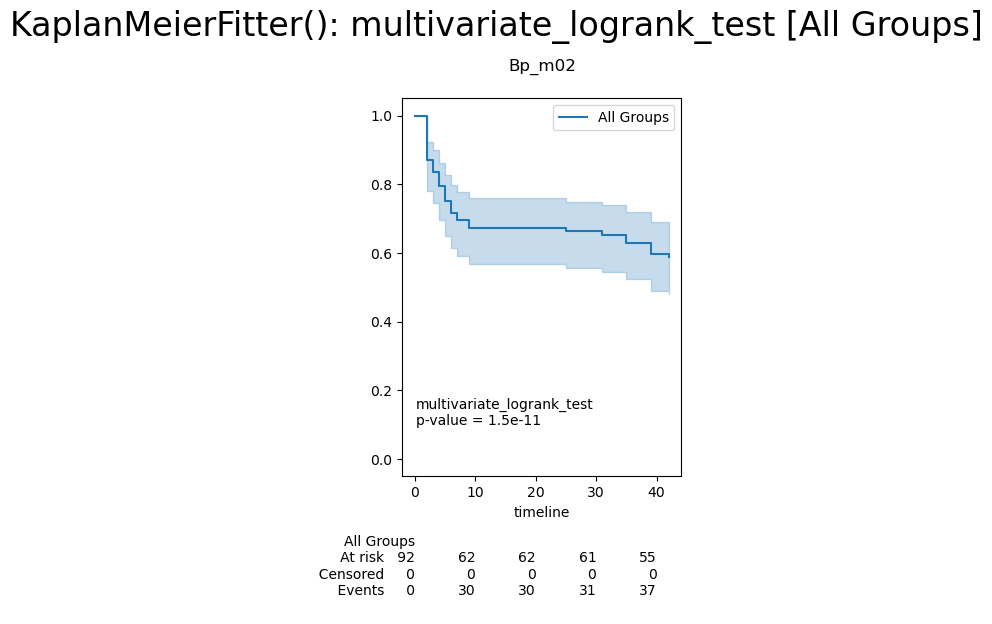

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           108 non-null    object
 1   Group_Name                      108 non-null    object
 2   Mouse                           108 non-null    object
 3   Day                             108 non-null    int64 
 4   Death                           108 non-null    int64 
 5   Survival_with_sterile_immunity  108 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 38.1 KB


Group                                         Group_Name Mouse  Day  \
0       A                 Group A: PBS (ID x 3, 0.0e+00 CFU)    A1    3   
1       A                 Group A: PBS (ID x 3, 0.0e+00 CFU)    A2    4   
2       A                 Group A: PBS (ID x 3, 0.0e+00 CFU)    A3    4   
3       A                 Group A: PBS (ID x 3, 0.0e+00 CFU)    A4    4   
4       A                 Group A: PBS (ID x 3, 0.0e+00 CFU)    A5    4   
..    ...                                                ...   ...  ...   
103     N  Group N: rLVS ΔcapB/Bp Hcp6-Hcp1-LolC (IN x 1,...    N4   42   
104     N  Group N: rLVS ΔcapB/Bp Hcp6-Hcp1-LolC (IN x 1,...    N5   42   
105     N  Group N: rLVS ΔcapB/Bp Hcp6-Hcp1-LolC (IN x 1,...    N6   42   
106     N  Group N: rLVS ΔcapB/Bp Hcp6-Hcp1-LolC (IN x 1,...    N7   42   
107     N  Group N: rLVS ΔcapB/Bp Hcp6-Hcp1-LolC (IN x 1,...    N8   33   

     Death  Survival_with_sterile_immunity  
0        1                               0  
1        1                               0  
2        1                               0  
3        1                               0  
4        1                               0  
..     ...                             ...  
103      0                               0  
104      0                               0  
105      0                               0  
106      0                               0  
107      1                               0  

[108 rows x 6 columns]

Group                          Group_Name Mouse         Day  \
count    108                                 108   108  108.000000   
unique    14                                  14   108         NaN   
top        A  Group A: PBS (ID x 3, 0.0e+00 CFU)    A1         NaN   
freq       8                                   8     1         NaN   
mean     NaN                                 NaN   NaN   29.453704   
std      NaN                                 NaN   NaN   17.025206   
min      NaN                                 NaN   NaN    3.000000   
25%      NaN                                 NaN   NaN    6.000000   
50%      NaN                                 NaN   NaN   42.000000   
75%      NaN                                 NaN   NaN   42.000000   
max      NaN                                 NaN   NaN   42.000000   

             Death  Survival_with_sterile_immunity  
count   108.000000                      108.000000  
unique         NaN                             NaN  
top            NaN                             NaN  
freq           NaN                             NaN  
mean      0.435185                        0.120370  
std       0.498093                        0.326911  
min       0.000000                        0.000000  
25%       0.000000                        0.000000  
50%       0.000000                        0.000000  
75%       1.000000                        0.000000  
max       1.000000                        1.000000

Day
0     3
1     4
2     5
3     6
4    17
5    31
6    33
7    35
8    38
9    40
10   42

Group
0      A
1      B
2      C
3      D
4      E
5      F
6      G
7      H
8      I
9      J
10     K
11     L
12     M
13     N

Group_Name
0                  Group A: PBS (ID x 3, 0.0e+00 CFU)
1                 Group B: Bp82 (ID x 3, 1.0e+06 CFU)
2            Group C: LVS ΔcapB (ID x 3, 2.0e+06 CFU)
3            Group D: LVS ΔcapB (IN x 3, 2.0e+06 CFU)
4            Group E: LVS ΔcapB (IN x 2, 2.0e+06 CFU)
5            Group F: LVS ΔcapB (IN x 1, 2.0e+06 CFU)
6   Group G: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...
7   Group H: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...
8   Group I: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (IN x 2,...
9   Group J: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (IN x 1,...
10  Group K: rLVS ΔcapB/Bp Hcp6-Hcp1-LolC (ID x 3,...
11  Group L: rLVS ΔcapB/Bp Hcp6-Hcp1-LolC (IN x 3,...
12  Group M: rLVS ΔcapB/Bp Hcp6-Hcp1-LolC (IN x 2,...
13  Group N: rLVS ΔcapB/Bp Hcp6-Hcp1-LolC (IN x 1,...

Mouse
0      A1
1      A2
2      A3
3      A4
4      A5
..    ...
103    N4
104    N5
105    N6
106    N7
107    N8

[108 rows x 1 columns]

Death
0      0
1      1

Survival_with_sterile_immunity
0                               0
1                               1

Group_1 Group_2 pair  uncorrected_p_value  p_value_fdr_bh  \
index                                                             
0           A       B  A-B             0.000149        0.000785   
1           A       C  A-C             0.000149        0.000785   
2           A       D  A-D             0.000279        0.001123   
3           A       E  A-E             0.000149        0.000785   
4           A       F  A-F             0.000149        0.000785   
...       ...     ...  ...                  ...             ...   
86          K       M  K-M             0.003375        0.009034   
87          K       N  K-N             0.001634        0.004506   
88          L       M  L-M             0.620385        0.723782   
89          L       N  L-N             0.554772        0.664267   
90          M       N  M-N             0.962359        0.973052   

       p_value_holm_bonferroni  p_value_holm_sidak sig_uncorrected sig_fdr_bh  \
index                                                                           
0                     0.012941            0.012858             ***        ***   
1                     0.012941            0.012858             ***        ***   
2                     0.020060            0.019863             ***         **   
3                     0.012941            0.012858             ***        ***   
4                     0.012941            0.012858             ***        ***   
...                        ...                 ...             ...        ...   
86                    0.195773            0.178074              **         **   
87                    0.098032            0.093453              **         **   
88                    1.000000            0.999999              ns         ns   
89                    1.000000            0.999998              ns         ns   
90                    1.000000            1.000000              ns         ns   

      sig_holm_bonferroni sig_holm_sidak  
index                                     
0                       *              *  
1                       *              *  
2                       *              *  
3                       *              *  
4                       *              *  
...                   ...            ...  
86                     ns             ns  
87                     ns             ns  
88                     ns             ns  
89                     ns             ns  
90                     ns             ns  

[91 rows x 11 columns]

final_survival  upper_0.95  lower_0.95  median_survival_time
Group                                                              
A            0.000000    0.000000    0.000000                   4.0
B            0.250000    0.558084    0.037067                  40.0
C            0.000000    0.000000    0.000000                   6.0
D            1.000000    1.000000    1.000000                   inf
E            0.875000    0.981393    0.387000                   inf
F            0.625000    0.860698    0.229333                   inf
G            0.000000    0.000000    0.000000                   5.0
H            0.875000    0.981393    0.387000                   inf
I            1.000000    1.000000    1.000000                   inf
J            0.857143    0.978561    0.334054                   inf
K            0.125000    0.422706    0.006593                   5.0
L            0.750000    0.930898    0.314807                   inf
M            0.857143    0.978561    0.334054                   inf
N            0.875000    0.981393    0.387000                   inf

Group  Died  Survived  total_mice  Survival_with_sterile_immunity  \
0      A     8         0           8                               0   
1      B     6         2           8                               0   
2      C     8         0           8                               0   
3      D     0         7           7                               6   
4      E     1         7           8                               1   
5      F     3         5           8                               3   
6      G     8         0           8                               0   
7      H     1         7           8                               0   
8      I     0         7           7                               0   
9      J     1         6           7                               0   
10     K     7         1           8                               1   
11     L     2         6           8                               1   
12     M     1         6           7                               1   
13     N     1         7           8                               0   

    not_sterile  percent_survival  percent_sterile  
0             8          0.000000         0.000000  
1             8         25.000000         0.000000  
2             8          0.000000         0.000000  
3             1        100.000000        85.714286  
4             7         87.500000        12.500000  
5             5         62.500000        37.500000  
6             8          0.000000         0.000000  
7             8         87.500000         0.000000  
8             7        100.000000         0.000000  
9             7         85.714286         0.000000  
10            7         12.500000        12.500000  
11            7         75.000000        12.500000  
12            6         85.714286        14.285714  
13            8         87.500000         0.000000

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      A-B                     0.198547                0.361356   
1      A-C                     1.000000                1.000000   
2      A-D                     0.000061                0.000926   
3      A-E                     0.000305                0.001851   
4      A-F                     0.009216                0.023297   
...    ...                          ...                     ...   
86     K-M                     0.005721                0.016268   
87     K-N                     0.004181                0.012273   
88     L-M                     0.828402                0.979020   
89     L-N                     0.691029                0.849779   
90     M-N                     0.999939                1.000000   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             1.000000                    0.999941   
1                             1.000000                    1.000000   
2                             0.005554                    0.005539   
3                             0.025940                    0.025610   
4                             0.534546                    0.415515   
...                                ...                         ...   
86                            0.343243                    0.291233   
87                            0.263397                    0.231988   
88                            1.000000                    1.000000   
89                            1.000000                    1.000000   
90                            1.000000                    1.000000   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                        ****                ***                          **   
3                         ***                 **                           *   
4                          **                  *                          ns   
...                       ...                ...                         ...   
86                         **                  *                          ns   
87                         **                  *                          ns   
88                         ns                 ns                          ns   
89                         ns                 ns                          ns   
90                         ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         **  
3                          *  
4                         ns  
...                      ...  
86                        ns  
87                        ns  
88                        ns  
89                        ns  
90                        ns  

[91 rows x 9 columns]

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      A-B                     1.000000                1.000000   
1      A-C                     1.000000                1.000000   
2      A-D                     0.000610                0.009257   
3      A-E                     0.500000                0.892157   
4      A-F                     0.081982                0.392651   
...    ...                          ...                     ...   
86     K-M                     0.999939                1.000000   
87     K-N                     0.500000                0.892157   
88     L-M                     0.999939                1.000000   
89     L-N                     0.500000                0.892157   
90     M-N                     0.395264                0.892157   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             1.000000                    1.000000   
1                             1.000000                    1.000000   
2                             0.055542                    0.054044   
3                             1.000000                    1.000000   
4                             1.000000                    0.998768   
...                                ...                         ...   
86                            1.000000                    1.000000   
87                            1.000000                    1.000000   
88                            1.000000                    1.000000   
89                            1.000000                    1.000000   
90                            1.000000                    1.000000   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                         ***                 **                          ns   
3                          ns                 ns                          ns   
4                          ns                 ns                          ns   
...                       ...                ...                         ...   
86                         ns                 ns                          ns   
87                         ns                 ns                          ns   
88                         ns                 ns                          ns   
89                         ns                 ns                          ns   
90                         ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns  
3                         ns  
4                         ns  
...                      ...  
86                        ns  
87                        ns  
88                        ns  
89                        ns  
90                        ns  

[91 rows x 9 columns]

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 13
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         146.12 <0.005     79.41

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
     test_statistic      p  -log2(p)
A B           14.39 <0.005     12.71
  C           14.39 <0.005     12.71
  D           13.21 <0.005     11.81
  E           14.39 <0.005     12.71
  F           14.39 <0.005     12.71
  G            7.05   0.01      6.98
  H           14.39 <0.005     12.71
  I           13.21 <0.005     11.81
  J            7.52   0.01      7.35
  K           11.39 <0.005     10.40
  L           14.39 <0.005     12.71
  M           13.21 <0.005     11.81
  N           14.39 <0.005     12.71
B C           11.51 <0.005     10.50
  D            8.03 <0.005      7.76
  E            7.28   0.01      7.16
  F            1.00   0.32      1.65
  G           13.95 <0.005     12.38
  H            5.45   0.02      5.67
  I            8.03 <0.005      7.76
  J            4.06   0.04      4.51
  K            3.00   0.08      3.59
  L            3.39   0.07      3.93
  M            4.77   0.03      5.11
  N            5.45   0.02      5.67
C D           13.02 <0.005     11.66
  E           14.31 <0.005     12.65
  F            7.03   0.01      6.96
  G            4.61   0.03      4.98
  H           14.31 <0.005     12.65
  I           13.02 <0.005     11.66
  J            7.27   0.01      7.16
  K            0.08   0.77      0.37
  L           14.31 <0.005     12.65
  M           13.02 <0.005     11.66
  N           14.31 <0.005     12.65
D E            0.88   0.35      1.52
  F            3.03   0.08      3.61
  G           14.39 <0.005     12.71
  H            0.88   0.35      1.52
  I            0.00   1.00     -0.00
  J            1.00   0.32      1.66
  K           11.11 <0.005     10.18
  L            1.87   0.17      2.55
  M            1.00   0.32      1.66
  N            0.88   0.35      1.52
E F            1.52   0.22      2.20
  G           16.03 <0.005     13.97
  H            0.00   0.96      0.06
  I            0.88   0.35      1.52
  J            0.02   0.88      0.18
  K           11.01 <0.005     10.11
  L            0.49   0.48      1.05
  M            0.02   0.88      0.18
  N            0.00   0.96      0.06
F G           10.55 <0.005      9.75
  H            1.32   0.25      1.99
  I            3.03   0.08      3.61
  J            0.74   0.39      1.36
  K            4.83   0.03      5.16
  L            0.48   0.49      1.04
  M            1.20   0.27      1.87
  N            1.45   0.23      2.13
G H           16.03 <0.005     13.97
  I           14.39 <0.005     12.71
  J            8.46 <0.005      8.11
  K            1.83   0.18      2.51
  L           16.03 <0.005     13.97
  M           14.39 <0.005     12.71
  N           16.03 <0.005     13.97
H I            0.88   0.35      1.52
  J            0.02   0.88      0.18
  K            9.92 <0.005      9.26
  L            0.29   0.59      0.76
  M            0.00   0.96      0.06
  N            0.00   0.96      0.06
I J            1.00   0.32      1.66
  K           11.11 <0.005     10.18
  L            1.87   0.17      2.55
  M            1.00   0.32      1.66
  N            0.88   0.35      1.52
J K            6.05   0.01      6.17
  L            0.17   0.68      0.56
  M            0.00   0.96      0.06
  N            0.02   0.88      0.18
K L            8.16 <0.005      7.86
  M            8.59 <0.005      8.21
  N            9.92 <0.005      9.26
L M            0.25   0.62      0.69
  N            0.35   0.55      0.85
M N            0.00   0.96      0.06

{'A': <lifelines.KaplanMeierFitter:"A", fitted with 8 total observations, 0 right-censored observations>,
 'B': <lifelines.KaplanMeierFitter:"B", fitted with 8 total observations, 2 right-censored observations>,
 'C': <lifelines.KaplanMeierFitter:"C", fitted with 8 total observations, 0 right-censored observations>,
 'D': <lifelines.KaplanMeierFitter:"D", fitted with 7 total observations, 7 right-censored observations>,
 'E': <lifelines.KaplanMeierFitter:"E", fitted with 8 total observations, 7 right-censored observations>,
 'F': <lifelines.KaplanMeierFitter:"F", fitted with 8 total observations, 5 right-censored observations>,
 'G': <lifelines.KaplanMeierFitter:"G", fitted with 8 total observations, 0 right-censored observations>,
 'H': <lifelines.KaplanMeierFitter:"H", fitted with 8 total observations, 7 right-censored observations>,
 'I': <lifelines.KaplanMeierFitter:"I", fitted with 7 total observations, 7 right-censored observations>,
 'J': <lifelines.KaplanMeierFitter:"J", fitted

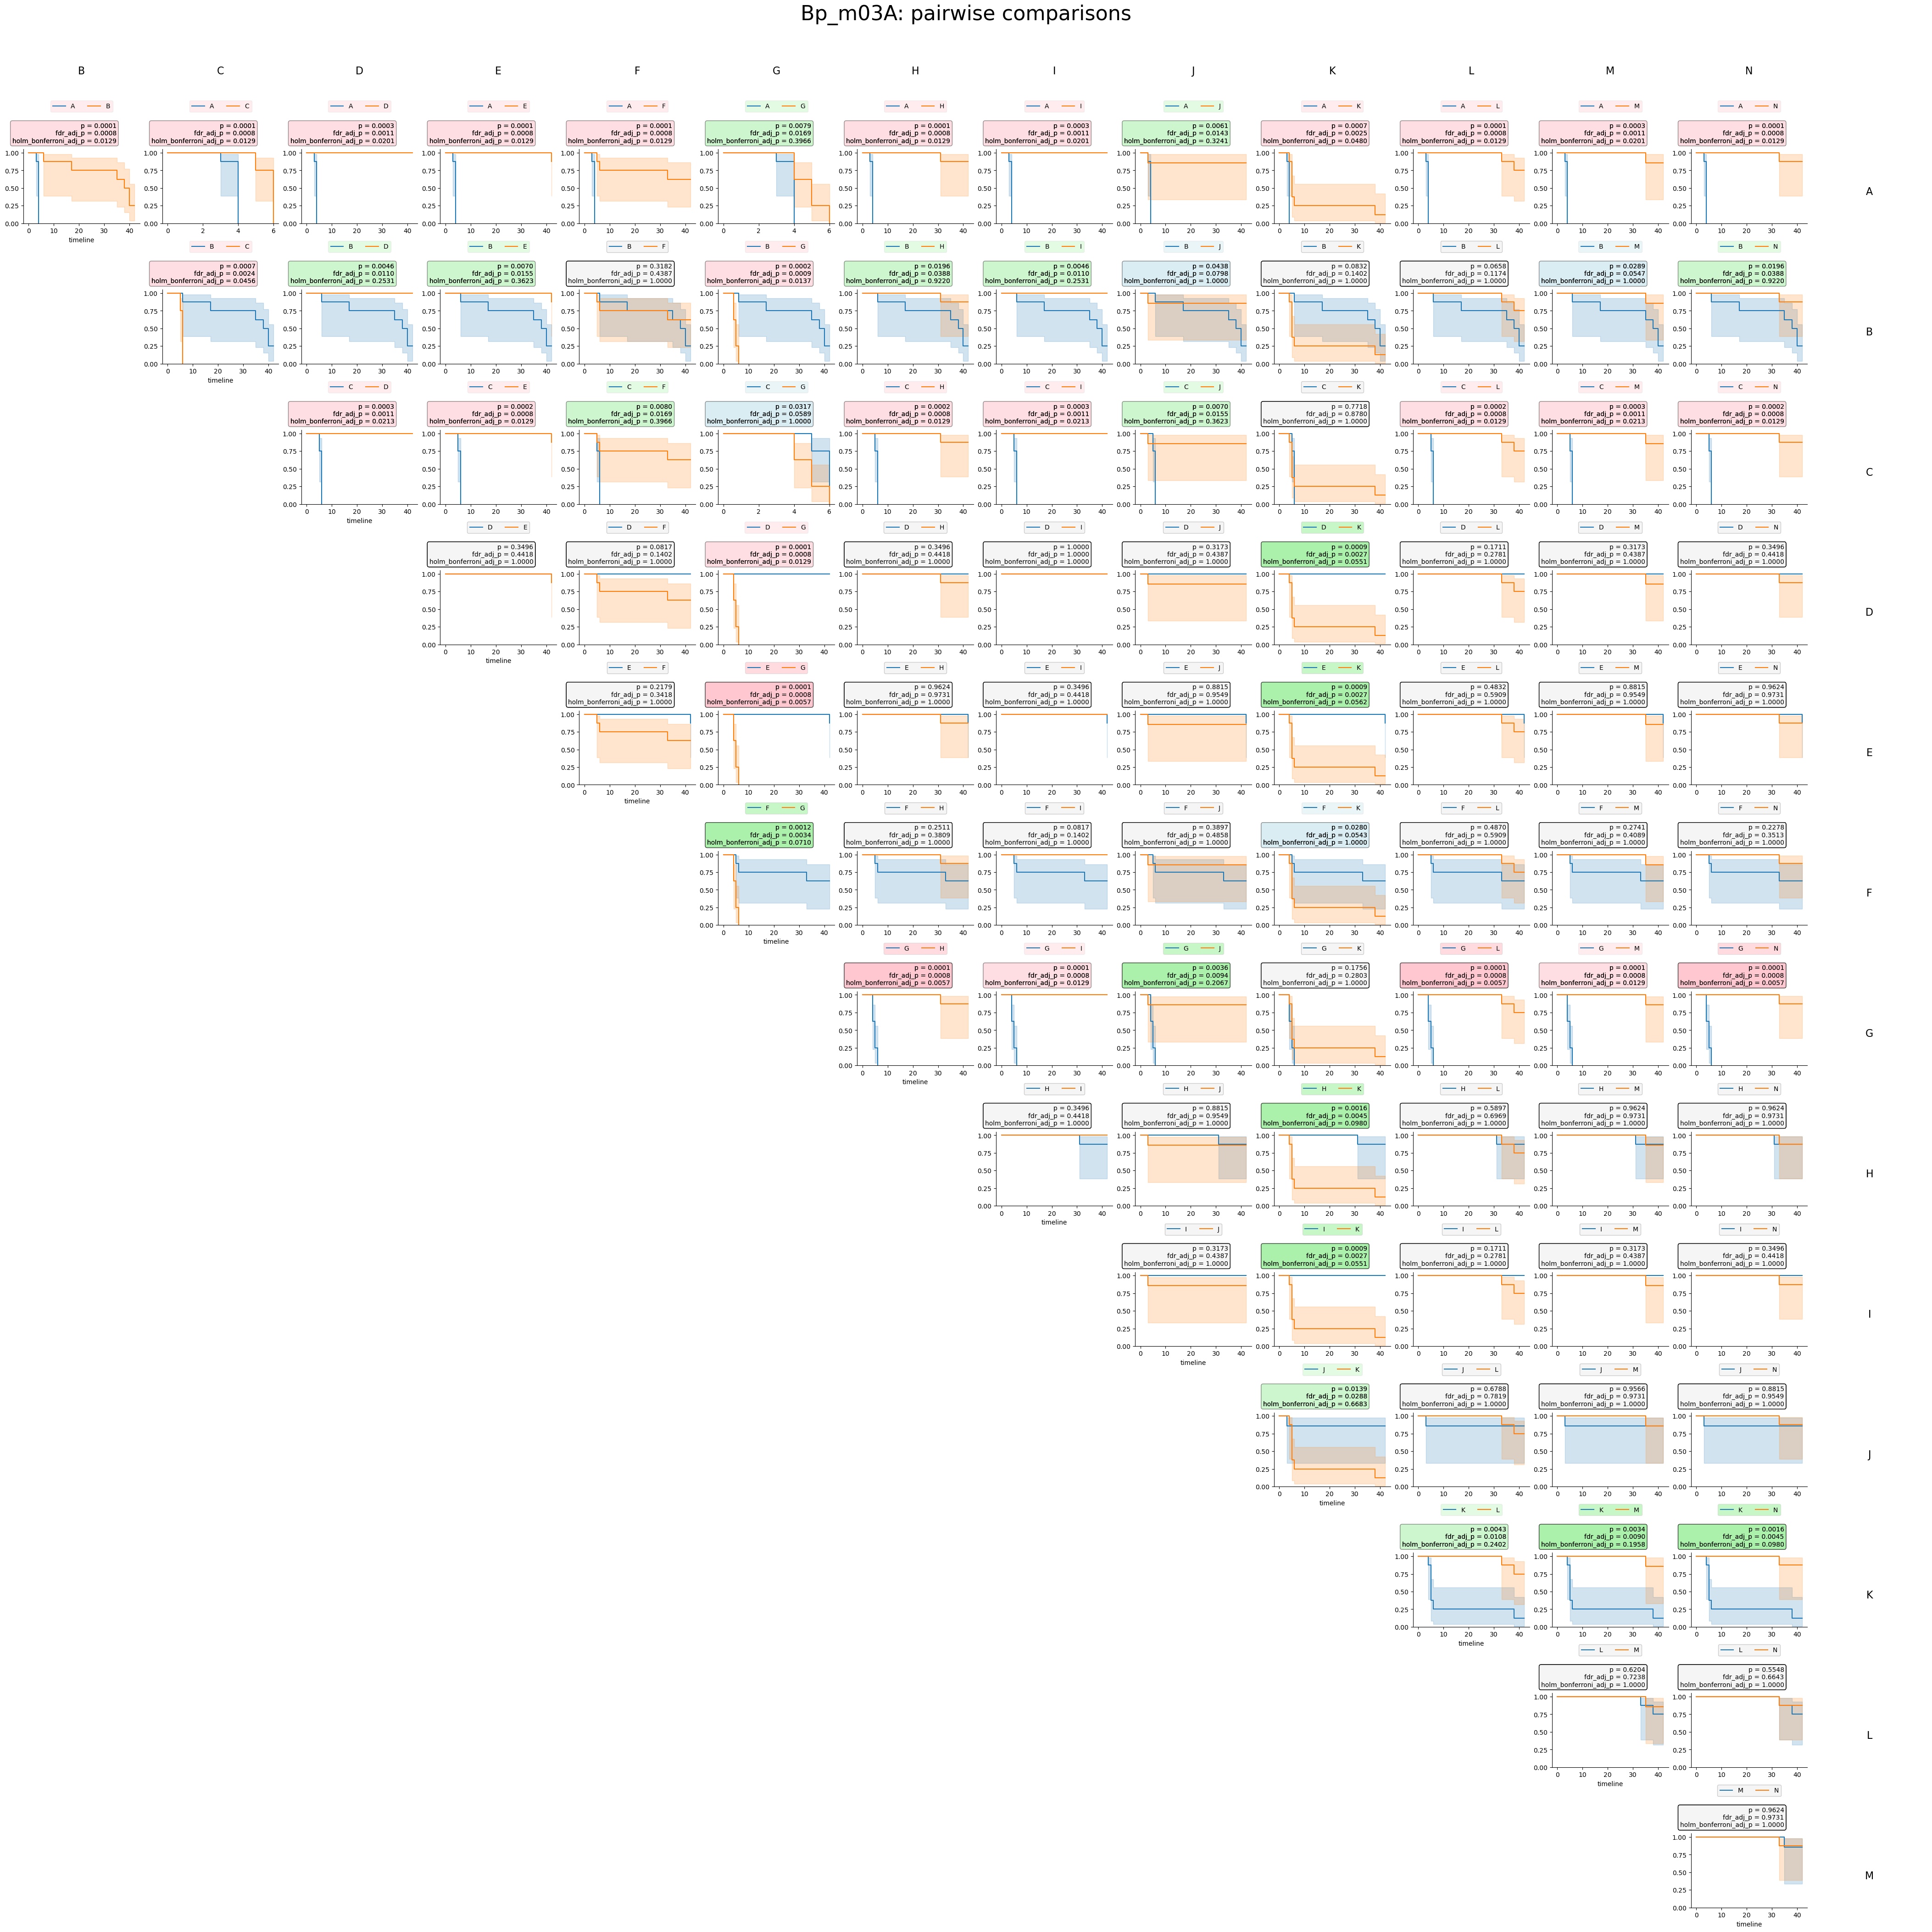

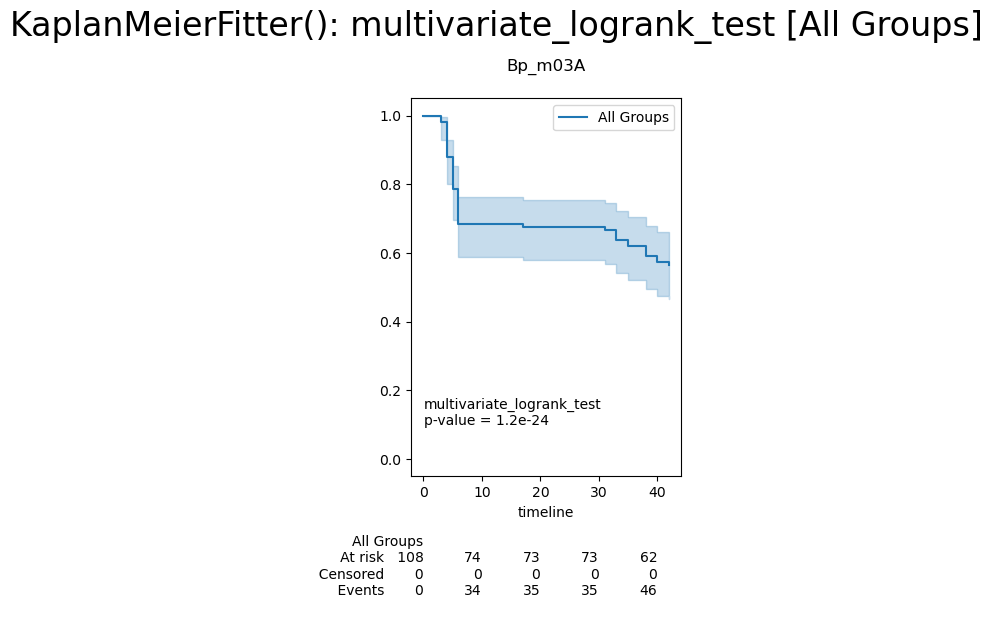

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           60 non-null     object
 1   Group_Name                      60 non-null     object
 2   Mouse                           60 non-null     object
 3   Day                             60 non-null     int64 
 4   Death                           60 non-null     int64 
 5   Survival_with_sterile_immunity  60 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 20.4 KB


Group                                         Group_Name Mouse  Day  Death  \
0      O                 Group O: PBS (ID x 3, 0.0e+00 CFU)    O1    5      1   
1      O                 Group O: PBS (ID x 3, 0.0e+00 CFU)    O2    6      1   
2      O                 Group O: PBS (ID x 3, 0.0e+00 CFU)    O3    4      1   
3      O                 Group O: PBS (ID x 3, 0.0e+00 CFU)    O5    5      1   
4      O                 Group O: PBS (ID x 3, 0.0e+00 CFU)    O6    4      1   
5      O                 Group O: PBS (ID x 3, 0.0e+00 CFU)    O7    5      1   
6      O                 Group O: PBS (ID x 3, 0.0e+00 CFU)    O8    5      1   
7      P                Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P1   38      1   
8      P                Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P2   42      0   
9      P                Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P3   24      1   
10     P                Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P4   38      1   
11     P                Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P5   42      0   
12     P                Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P6   38      1   
13     P                Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P7   42      0   
14     P                Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P8   31      1   
15     Q           Group Q: LVS ΔcapB (ID x 3, 2.0e+06 CFU)    Q1   42      0   
16     Q           Group Q: LVS ΔcapB (ID x 3, 2.0e+06 CFU)    Q2   42      0   
17     Q           Group Q: LVS ΔcapB (ID x 3, 2.0e+06 CFU)    Q3   42      0   
18     Q           Group Q: LVS ΔcapB (ID x 3, 2.0e+06 CFU)    Q4    6      1   
19     Q           Group Q: LVS ΔcapB (ID x 3, 2.0e+06 CFU)    Q5   42      0   
20     Q           Group Q: LVS ΔcapB (ID x 3, 2.0e+06 CFU)    Q6    6      1   
21     Q           Group Q: LVS ΔcapB (ID x 3, 2.0e+06 CFU)    Q7    4      1   
22     Q           Group Q: LVS ΔcapB (ID x 3, 2.0e+06 CFU)    Q8   42      0   
23     R           Group R: LVS ΔcapB (IN x 3, 2.0e+06 CFU)    R1   42      0   
24     R           Group R: LVS ΔcapB (IN x 3, 2.0e+06 CFU)    R2   42      0   
25     R           Group R: LVS ΔcapB (IN x 3, 2.0e+06 CFU)    R3   42      0   
26     R           Group R: LVS ΔcapB (IN x 3, 2.0e+06 CFU)    R6   42      0   
27     R           Group R: LVS ΔcapB (IN x 3, 2.0e+06 CFU)    R7   42      0   
28     R           Group R: LVS ΔcapB (IN x 3, 2.0e+06 CFU)    R8   42      0   
29     S  Group S: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...    S2   42      0   
30     S  Group S: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...    S3    5      1   
31     S  Group S: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...    S4    5      1   
32     S  Group S: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...    S5    5      1   
33     S  Group S: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...    S6   42      0   
34     S  Group S: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...    S7   42      0   
35     S  Group S: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...    S8   42      0   
36     T  Group T: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...    T1   42      0   
37     T  Group T: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...    T2   42      0   
38     T  Group T: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...    T3   42      0   
39     T  Group T: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...    T4    5      1   
40     T  Group T: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...    T5   31      1   
41     T  Group T: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...    T6   42      0   
42     T  Group T: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...    T7   31      1   
43     T  Group T: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...    T8   24      1   
44     U  Group U: rLVS ΔcapB/Bp Hcp6-Hcp1-LolC (ID x 3,...    U1   42      0   
45     U  Group U: rLVS ΔcapB/Bp Hcp6-Hcp1-LolC (ID x 3,...    U2    5      1   
46     U  Group U: rLVS ΔcapB/Bp Hcp6-Hcp1-LolC (ID x 3,...    U3   42      0   
47     U  Group U: rLVS ΔcapB/Bp Hcp6-Hcp1-LolC (ID x 3,...    U4    5      1   
48     U  Group U: rLVS ΔcapB/Bp H

Group                           Group_Name Mouse        Day      Death  \
count     60                                   60    60  60.000000  60.000000   
unique     8                                    8    60        NaN        NaN   
top        P  Group P: Bp82 (ID x 3, 1.0e+06 CFU)    O1        NaN        NaN   
freq       8                                    8     1        NaN        NaN   
mean     NaN                                  NaN   NaN  27.116667   0.500000   
std      NaN                                  NaN   NaN  17.344067   0.504219   
min      NaN                                  NaN   NaN   4.000000   0.000000   
25%      NaN                                  NaN   NaN   5.000000   0.000000   
50%      NaN                                  NaN   NaN  40.000000   0.500000   
75%      NaN                                  NaN   NaN  42.000000   1.000000   
max      NaN                                  NaN   NaN  42.000000   1.000000   

        Survival_with_sterile_immunity  
count                        60.000000  
unique                             NaN  
top                                NaN  
freq                               NaN  
mean                          0.366667  
std                           0.485961  
min                           0.000000  
25%                           0.000000  
50%                           0.000000  
75%                           1.000000  
max                           1.000000

Day
0    4
1    5
2    6
3   24
4   31
5   38
6   42

Group
0     O
1     P
2     Q
3     R
4     S
5     T
6     U
7     V

Group_Name
0                 Group O: PBS (ID x 3, 0.0e+00 CFU)
1                Group P: Bp82 (ID x 3, 1.0e+06 CFU)
2           Group Q: LVS ΔcapB (ID x 3, 2.0e+06 CFU)
3           Group R: LVS ΔcapB (IN x 3, 2.0e+06 CFU)
4  Group S: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...
5  Group T: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...
6  Group U: rLVS ΔcapB/Bp Hcp6-Hcp1-LolC (ID x 3,...
7  Group V: rLVS ΔcapB/Bp Hcp6-Hcp1-LolC (IN x 3,...

Mouse
0     O1
1     O2
2     O3
3     O5
4     O6
5     O7
6     O8
7     P1
8     P2
9     P3
10    P4
11    P5
12    P6
13    P7
14    P8
15    Q1
16    Q2
17    Q3
18    Q4
19    Q5
20    Q6
21    Q7
22    Q8
23    R1
24    R2
25    R3
26    R6
27    R7
28    R8
29    S2
30    S3
31    S4
32    S5
33    S6
34    S7
35    S8
36    T1
37    T2
38    T3
39    T4
40    T5
41    T6
42    T7
43    T8
44    U1
45    U2
46    U3
47    U4
48    U5
49    U6
50    U7
51    U8
52    V1
53    V2
54    V3
55    V4
56    V5
57    V6
58    V7
59    V8

Death
0      0
1      1

Survival_with_sterile_immunity
0                               0
1                               1

Group_1 Group_2 pair  uncorrected_p_value  p_value_fdr_bh  \
index                                                             
0           O       P  O-P             0.000089        0.002501   
1           O       Q  O-Q             0.004661        0.026102   
2           O       R  O-R             0.000444        0.003994   
3           O       S  O-S             0.014634        0.058536   
4           O       T  O-T             0.000571        0.003994   
5           O       U  O-U             0.162127        0.283723   
6           O       V  O-V             0.000382        0.003994   
7           P       Q  P-Q             0.654493        0.796774   
8           P       R  P-R             0.023110        0.071899   
9           P       S  P-S             0.817364        0.882974   
10          P       T  P-T             0.989593        0.989593   
11          P       U  P-U             0.118509        0.221216   
12          P       V  P-V             0.267812        0.394670   
13          Q       R  Q-R             0.106326        0.221216   
14          Q       S  Q-S             0.788369        0.882974   
15          Q       T  Q-T             0.819904        0.882974   
16          Q       U  Q-U             0.109932        0.221216   
17          Q       V  Q-V             0.533042        0.678417   
18          R       S  R-S             0.078983        0.201047   
19          R       T  R-T             0.052223        0.146224   
20          R       U  R-U             0.007562        0.035288   
21          R       V  R-V             0.202396        0.314838   
22          S       T  S-T             0.979856        0.989593   
23          S       U  S-U             0.199321        0.314838   
24          S       V  S-V             0.361013        0.505419   
25          T       U  T-U             0.114210        0.221216   
26          T       V  T-V             0.387431        0.516575   
27          U       V  U-V             0.021891        0.071899   

       p_value_holm_bonferroni  p_value_holm_sidak sig_uncorrected sig_fdr_bh  \
index                                                                           
0                     0.002501            0.002498            ****         **   
1                     0.111868            0.106071              **          *   
2                     0.011538            0.011474             ***         **   
3                     0.321946            0.276984               *         ns   
4                     0.014265            0.014168             ***         **   
5                     1.000000            0.899697              ns         ns   
6                     0.010311            0.010260             ***         **   
7                     1.000000            0.998299              ns         ns   
8                     0.462205            0.373514               *         ns   
9                     1.000000            0.999575              ns         ns   
10                    1.000000            0.999594              ns         ns   
11                    1.000000            0.852073              ns         ns   
12                    1.000000            0.955718              ns         ns   
13                    1.000000            0.852073              ns         ns   
14                    1.000000            0.999575              ns         ns   
15                    1.000000            0.999575              ns         ns   
16                    1.000000            0.852073              ns         ns   
17                    1.000000            0.995159              ns         ns   
18                    1.000000            0.772584              ns         ns   
19                    0.992232            0.639073              ns         ns   
20                    0.173921            0.160192              **          *   
21                    1.000000            0.930578              ns         ns   
22                    1.000000            0.999594 

final_survival  upper_0.95  lower_0.95  median_survival_time
Group                                                              
O            0.000000    0.000000    0.000000                   5.0
P            0.375000    0.674363    0.087006                  38.0
Q            0.625000    0.860698    0.229333                   inf
R            1.000000    1.000000    1.000000                   inf
S            0.571429    0.837083    0.171866                   inf
T            0.500000    0.774865    0.152036                   inf
U            0.250000    0.558084    0.037067                   5.0
V            0.750000    0.930898    0.314807                   inf

Group  Died  Survived  total_mice  Survival_with_sterile_immunity  \
0     O     7         0           7                               0   
1     P     5         3           8                               0   
2     Q     3         5           8                               5   
3     R     0         6           6                               4   
4     S     3         4           7                               3   
5     T     4         4           8                               4   
6     U     6         2           8                               1   
7     V     2         6           8                               5   

   not_sterile  percent_survival  percent_sterile  
0            7          0.000000         0.000000  
1            8         37.500000         0.000000  
2            3         62.500000        62.500000  
3            2        100.000000        66.666667  
4            4         57.142857        42.857143  
5            4         50.000000        50.000000  
6            7         25.000000        12.500000  
7            3         75.000000        62.500000

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      O-P                     0.088596                0.248070   
1      O-Q                     0.014709                0.102966   
2      O-R                     0.000244                0.006836   
3      O-S                     0.027908                0.130238   
4      O-T                     0.037598                0.150391   
5      O-U                     0.251709                0.445724   
6      O-V                     0.003174                0.034643   
7      P-Q                     0.521359                0.725499   
8      P-R                     0.023193                0.129883   
9      P-S                     0.580859                0.725499   
10     P-T                     0.621857                0.725499   
11     P-U                     0.731109                0.787348   
12     P-V                     0.137695                0.275391   
13     Q-R                     0.129761                0.275391   
14     Q-S                     0.923035                0.923035   
15     Q-T                     0.621857                0.725499   
16     Q-U                     0.137695                0.275391   
17     Q-V                     0.731109                0.787348   
18     R-S                     0.105742                0.269161   
19     R-T                     0.053223                0.186279   
20     R-U                     0.003712                0.034643   
21     R-V                     0.309570                0.509881   
22     S-T                     0.781688                0.810639   
23     S-U                     0.254700                0.445724   
24     S-V                     0.593778                0.725499   
25     T-U                     0.391784                0.577365   
26     T-V                     0.391784                0.577365   
27     U-V                     0.076813                0.238973   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             1.000000                    0.828405   
1                             0.367737                    0.309589   
2                             0.006836                    0.006813   
3                             0.641890                    0.478485   
4                             0.827148                    0.569625   
5                             1.000000                    0.982742   
6                             0.085693                    0.082249   
7                             1.000000                    0.998681   
8                             0.556641                    0.430614   
9                             1.000000                    0.999047   
10                            1.000000                    0.999047   
11                            1.000000                    0.999047   
12                            1.000000                    0.906552   
13                            1.000000                    0.905842   
14                            1.000000                    0.999047   
15                            1.000000                    0.999047   
16                            1.000000                    0.906552   
17                            1.000000                    0.999047   
18                            1.000000                    0.866238   
19                            1.000000                    0.682894   
20                            0.096506                    0.092159   
21                            1.000000                    0.988266   
22                            1.000000                    0.999047   
23                            1.000000                    0.982742   
24                            1.000000                    0.999047   
25                            1.000000                    0.995787   
26                            1.000

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      O-P                     1.000000                1.000000   
1      O-Q                     0.014709                0.068644   
2      O-R                     0.012207                0.068644   
3      O-S                     0.096361                0.207546   
4      O-T                     0.037598                0.116970   
5      O-U                     0.604736                0.791454   
6      O-V                     0.014709                0.068644   
7      P-Q                     0.009216                0.068644   
8      P-R                     0.007324                0.068644   
9      P-S                     0.088584                0.206697   
10     P-T                     0.026001                0.104004   
11     P-U                     0.500000                0.791454   
12     P-V                     0.009216                0.068644   
13     Q-R                     0.977905                1.000000   
14     Q-S                     0.580859                0.791454   
15     Q-T                     0.621857                0.791454   
16     Q-U                     0.046356                0.129797   
17     Q-V                     1.000000                1.000000   
18     R-S                     0.520981                0.791454   
19     R-T                     0.587699                0.791454   
20     R-U                     0.035270                0.116970   
21     R-V                     0.977905                1.000000   
22     S-T                     0.781688                0.911969   
23     S-U                     0.252686                0.471680   
24     S-V                     0.580918                0.791454   
25     T-U                     0.126678                0.253357   
26     T-V                     0.689148                0.838963   
27     U-V                     0.057343                0.145963   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             1.000000                    1.000000   
1                             0.353027                    0.299282   
2                             0.305176                    0.264389   
3                             1.000000                    0.802338   
4                             0.751953                    0.535342   
5                             1.000000                    0.999930   
6                             0.353027                    0.299282   
7                             0.248840                    0.221195   
8                             0.205078                    0.186031   
9                             1.000000                    0.793376   
10                            0.572021                    0.439872   
11                            1.000000                    0.999878   
12                            0.248840                    0.221195   
13                            1.000000                    1.000000   
14                            1.000000                    0.999930   
15                            1.000000                    0.999930   
16                            0.880768                    0.594176   
17                            1.000000                    1.000000   
18                            1.000000                    0.999878   
19                            1.000000                    0.999930   
20                            0.740664                    0.529538   
21                            1.000000                    1.000000   
22                            1.000000                    0.999930   
23                            1.000000                    0.983055   
24                            1.000000                    0.999930   
25                            1.000000                    0.868897   
26                            1.000

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 7
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          32.23 <0.005     14.73

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
     test_statistic      p  -log2(p)
O P           15.35 <0.005     13.45
  Q            8.01 <0.005      7.75
  R           12.34 <0.005     11.14
  S            5.96   0.01      6.09
  T           11.87 <0.005     10.78
  U            1.95   0.16      2.62
  V           12.62 <0.005     11.35
P Q            0.20   0.65      0.61
  R            5.16   0.02      5.44
  S            0.05   0.82      0.29
  T            0.00   0.99      0.02
  U            2.44   0.12      3.08
  V            1.23   0.27      1.90
Q R            2.61   0.11      3.23
  S            0.07   0.79      0.34
  T            0.05   0.82      0.29
  U            2.56   0.11      3.19
  V            0.39   0.53      0.91
R S            3.09   0.08      3.66
  T            3.77   0.05      4.26
  U            7.13   0.01      7.05
  V            1.62   0.20      2.30
S T            0.00   0.98      0.03
  U            1.65   0.20      2.33
  V            0.83   0.36      1.47
T U            2.49   0.11      3.13
  V            0.75   0.39      1.37
U V            5.25   0.02      5.51

{'O': <lifelines.KaplanMeierFitter:"O", fitted with 7 total observations, 0 right-censored observations>,
 'P': <lifelines.KaplanMeierFitter:"P", fitted with 8 total observations, 3 right-censored observations>,
 'Q': <lifelines.KaplanMeierFitter:"Q", fitted with 8 total observations, 5 right-censored observations>,
 'R': <lifelines.KaplanMeierFitter:"R", fitted with 6 total observations, 6 right-censored observations>,
 'S': <lifelines.KaplanMeierFitter:"S", fitted with 7 total observations, 4 right-censored observations>,
 'T': <lifelines.KaplanMeierFitter:"T", fitted with 8 total observations, 4 right-censored observations>,
 'U': <lifelines.KaplanMeierFitter:"U", fitted with 8 total observations, 2 right-censored observations>,
 'V': <lifelines.KaplanMeierFitter:"V", fitted with 8 total observations, 6 right-censored observations>}

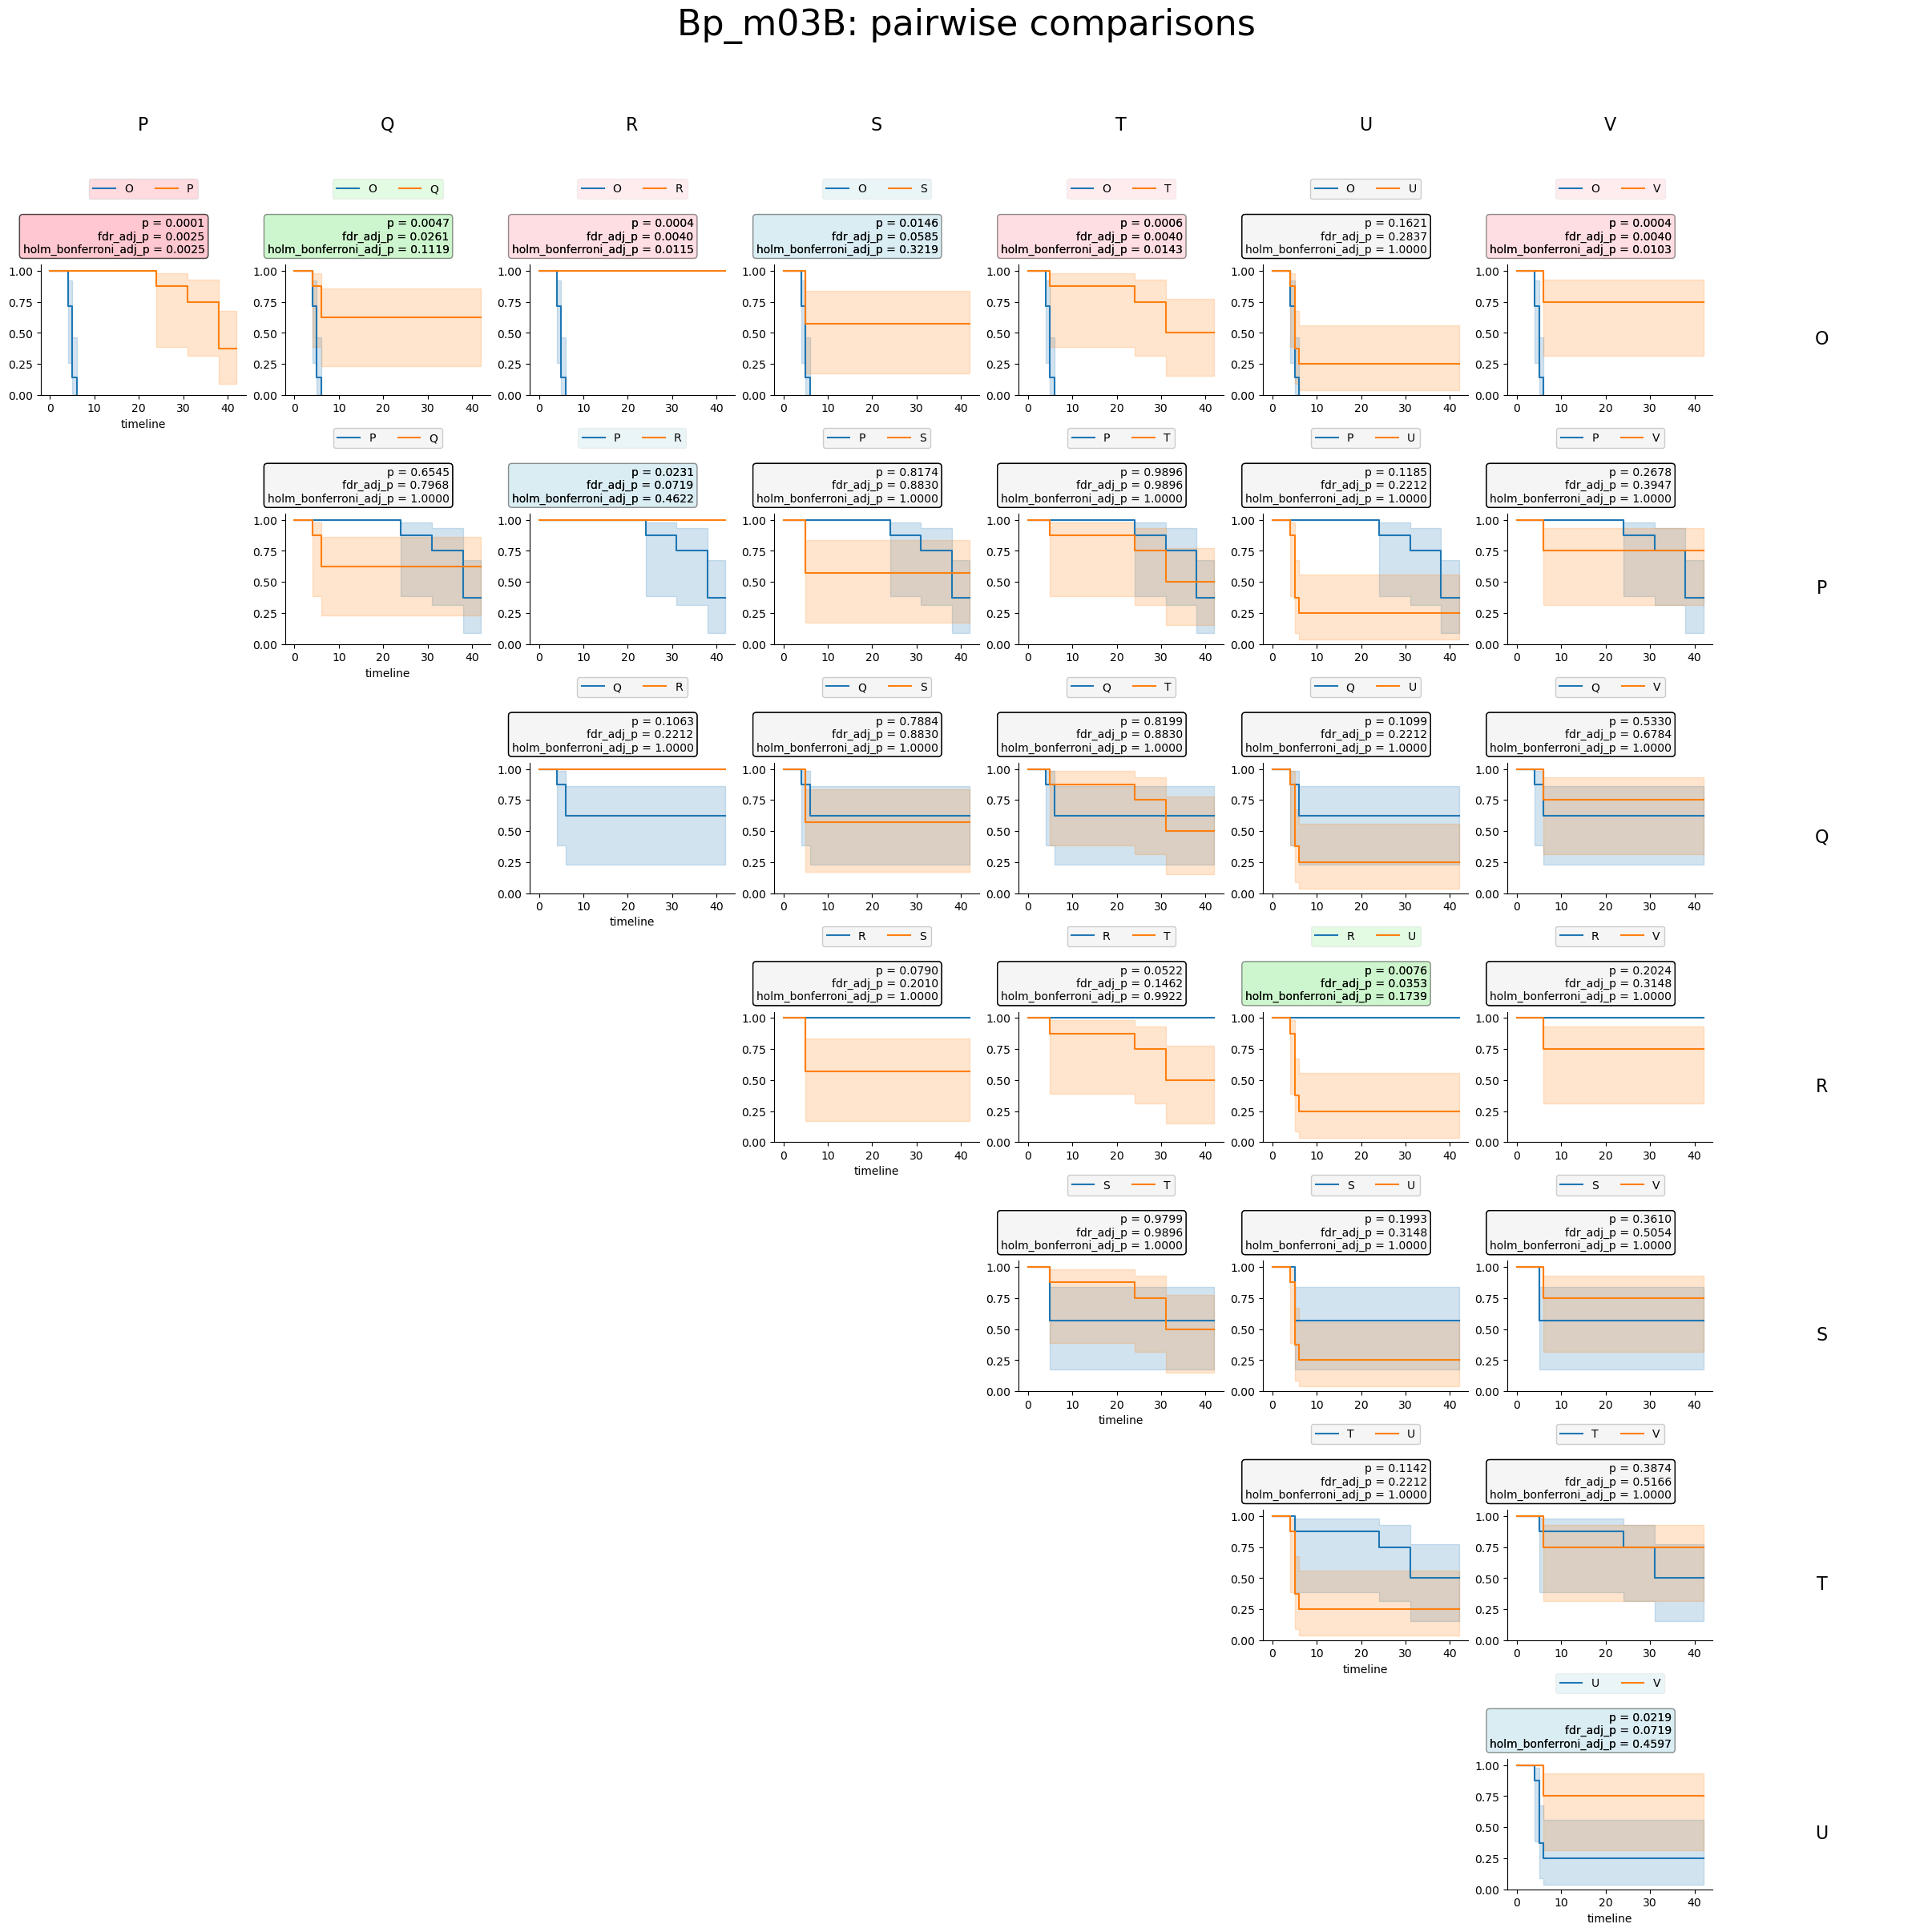

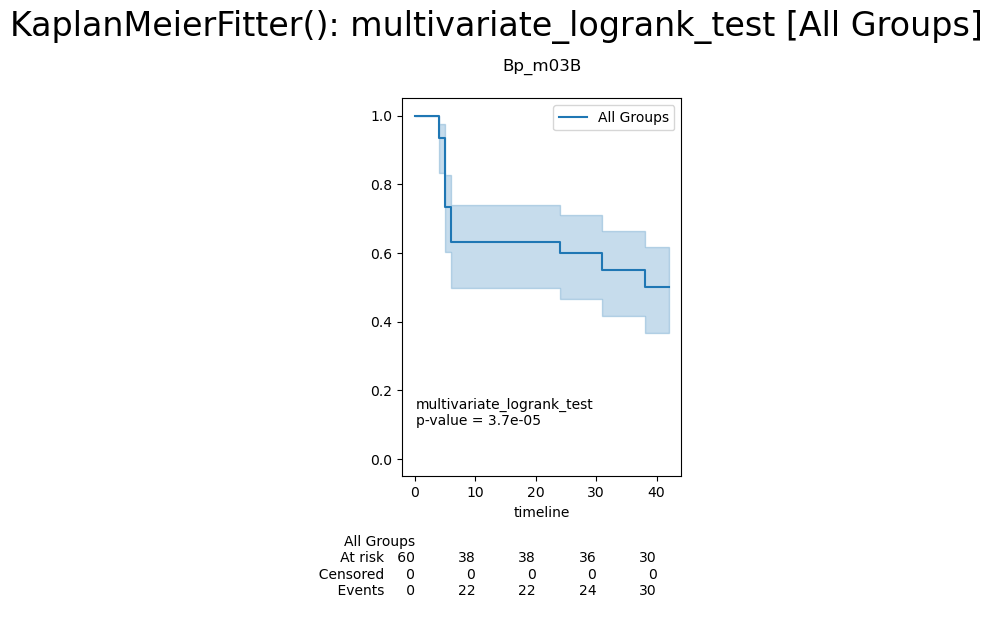

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           64 non-null     object
 1   Group_Name                      64 non-null     object
 2   Mouse                           64 non-null     object
 3   Day                             64 non-null     int64 
 4   Death                           64 non-null     int64 
 5   Survival_with_sterile_immunity  64 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 21.1 KB


Group                                         Group_Name Mouse  Day  Death  \
0      A  Group A: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1520 ...    A1    6      1   
1      A  Group A: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1520 ...    A2    6      1   
2      A  Group A: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1520 ...    A3   35      1   
3      A  Group A: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1520 ...    A4    4      1   
4      A  Group A: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1520 ...    A5    4      1   
..   ...                                                ...   ...  ...    ...   
59     D  Group D: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...   D12   42      0   
60     D  Group D: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...   D13   35      1   
61     D  Group D: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...   D14   35      1   
62     D  Group D: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...   D15   17      1   
63     D  Group D: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...   D16   42      0   

    Survival_with_sterile_immunity  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0  
..                             ...  
59                               1  
60                               0  
61                               0  
62                               0  
63                               1  

[64 rows x 6 columns]

Group                                         Group_Name Mouse  \
count     64                                                 64    64   
unique     4                                                  4    64   
top        A  Group A: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1520 ...    A1   
freq      16                                                 16     1   
mean     NaN                                                NaN   NaN   
std      NaN                                                NaN   NaN   
min      NaN                                                NaN   NaN   
25%      NaN                                                NaN   NaN   
50%      NaN                                                NaN   NaN   
75%      NaN                                                NaN   NaN   
max      NaN                                                NaN   NaN   

              Day      Death  Survival_with_sterile_immunity  
count   64.000000  64.000000                       64.000000  
unique        NaN        NaN                             NaN  
top           NaN        NaN                             NaN  
freq          NaN        NaN                             NaN  
mean    28.703125   0.484375                        0.296875  
std     16.342252   0.503706                        0.460493  
min      3.000000   0.000000                        0.000000  
25%      9.250000   0.000000                        0.000000  
50%     42.000000   0.000000                        0.000000  
75%     42.000000   1.000000                        1.000000  
max     42.000000   1.000000                        1.000000

Day
0     3
1     4
2     5
3     6
4     7
5    10
6    14
7    17
8    21
9    28
10   35
11   42

Group
0     A
1     B
2     C
3     D

Group_Name
0  Group A: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1520 ...
1  Group B: Bp82 (ID x 3, 1.0e+06 CFU) [Bp = 1520...
2  Group C: LVS ΔcapB (ID x 3, 2.0e+06 CFU) [Bp =...
3  Group D: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...

Mouse
0     A1
1    A10
2    A11
3    A12
4    A13
..   ...
59    D5
60    D6
61    D7
62    D8
63    D9

[64 rows x 1 columns]

Death
0      0
1      1

Survival_with_sterile_immunity
0                               0
1                               1

Group_1 Group_2 pair  uncorrected_p_value  p_value_fdr_bh  \
index                                                             
0           A       B  A-B             0.038521        0.115564   
1           A       C  A-C             0.208627        0.275971   
2           A       D  A-D             0.005646        0.033873   
3           B       C  B-C             0.510290        0.510290   
4           B       D  B-D             0.229976        0.275971   
5           C       D  C-D             0.070152        0.140305   

       p_value_holm_bonferroni  p_value_holm_sidak sig_uncorrected sig_fdr_bh  \
index                                                                           
0                     0.192607            0.178329               *         ns   
1                     0.625882            0.504387              ns         ns   
2                     0.033873            0.033399              **          *   
3                     0.625882            0.510290              ns         ns   
4                     0.625882            0.504387              ns         ns   
5                     0.280609            0.252438              ns         ns   

      sig_holm_bonferroni sig_holm_sidak  
index                                     
0                      ns             ns  
1                      ns             ns  
2                       *              *  
3                      ns             ns  
4                      ns             ns  
5                      ns             ns

final_survival  upper_0.95  lower_0.95  median_survival_time
Group                                                              
A              0.3125    0.536497    0.113871                   6.0
B              0.5625    0.762239    0.295427                   inf
C              0.4375    0.655644    0.198117                  35.0
D              0.7500    0.897980    0.463430                   inf

Group  Died  Survived  total_mice  Survival_with_sterile_immunity  \
0     A    11         5          16                               3   
1     B     7         9          16                               2   
2     C     9         7          16                               5   
3     D     4        12          16                               9   

   not_sterile  percent_survival  percent_sterile  
0           13             31.25            18.75  
1           14             56.25            12.50  
2           11             43.75            31.25  
3            7             75.00            56.25

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      A-B                     0.172092                0.344184   
1      A-C                     0.567982                0.596615   
2      A-D                     0.015335                0.092008   
3      B-C                     0.596615                0.596615   
4      B-D                     0.300633                0.450949   
5      C-D                     0.086886                0.260657   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.688367                    0.530183   
1                             1.000000                    0.813360   
2                             0.092008                    0.088552   
3                             1.000000                    0.813360   
4                             0.901898                    0.657929   
5                             0.434428                    0.365216   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                           *                 ns                          ns   
3                          ns                 ns                          ns   
4                          ns                 ns                          ns   
5                          ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns  
3                         ns  
4                         ns  
5                         ns

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      A-B                     0.776826                0.776826   
1      A-C                     0.574260                0.689112   
2      A-D                     0.033539                0.100618   
3      B-C                     0.230765                0.346148   
4      B-D                     0.011737                0.070425   
5      C-D                     0.172092                0.344184   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             1.000000                    0.818746   
1                             1.000000                    0.818746   
2                             0.167697                    0.156819   
3                             0.692296                    0.544827   
4                             0.070425                    0.068390   
5                             0.688367                    0.530183   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                           *                 ns                          ns   
3                          ns                 ns                          ns   
4                           *                 ns                          ns   
5                          ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns  
3                         ns  
4                         ns  
5                         ns

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
          10.32 0.02      5.96

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
     test_statistic    p  -log2(p)
A B            4.28 0.04      4.70
  C            1.58 0.21      2.26
  D            7.66 0.01      7.47
B C            0.43 0.51      0.97
  D            1.44 0.23      2.12
C D            3.28 0.07      3.83

{'A': <lifelines.KaplanMeierFitter:"A", fitted with 16 total observations, 5 right-censored observations>,
 'B': <lifelines.KaplanMeierFitter:"B", fitted with 16 total observations, 9 right-censored observations>,
 'C': <lifelines.KaplanMeierFitter:"C", fitted with 16 total observations, 7 right-censored observations>,
 'D': <lifelines.KaplanMeierFitter:"D", fitted with 16 total observations, 12 right-censored observations>}

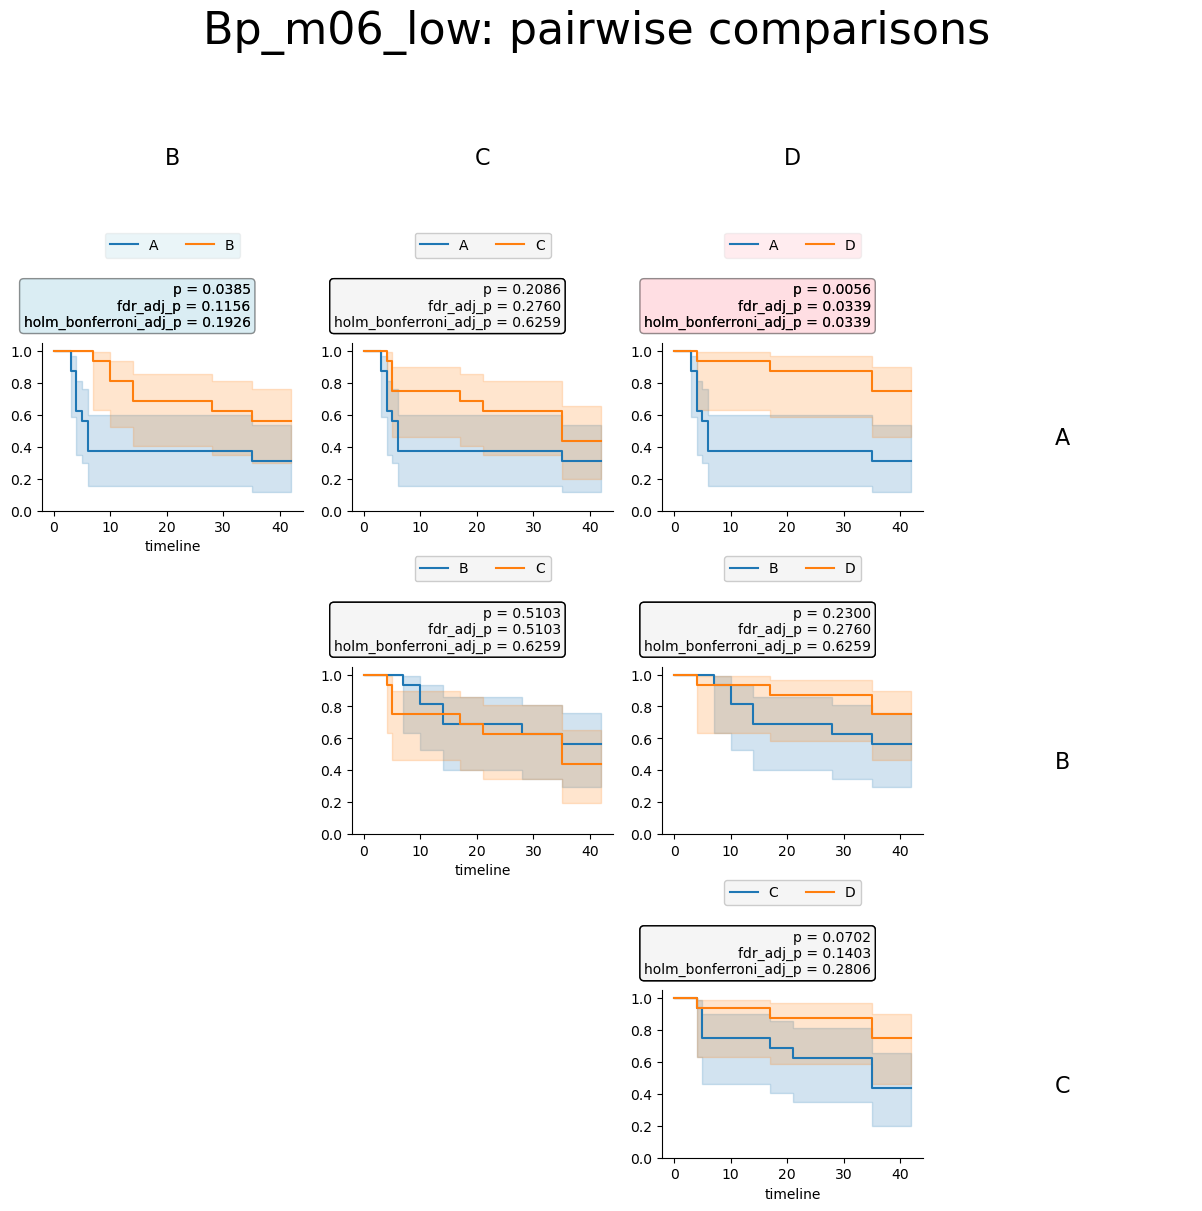

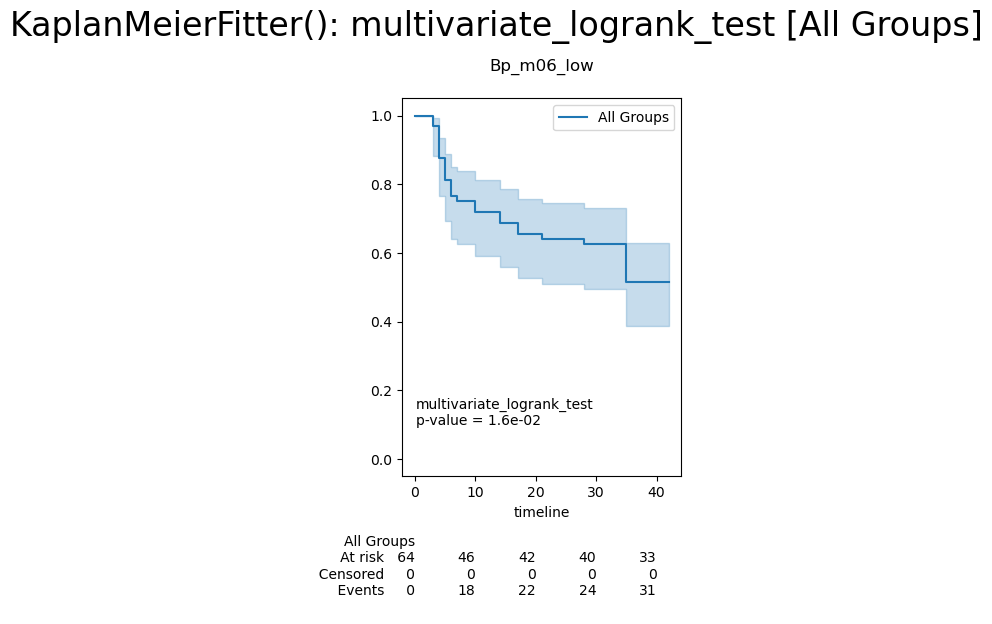

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           62 non-null     object
 1   Group_Name                      62 non-null     object
 2   Mouse                           62 non-null     object
 3   Day                             62 non-null     int64 
 4   Death                           62 non-null     int64 
 5   Survival_with_sterile_immunity  62 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 20.5 KB


Group                                         Group_Name Mouse  Day  Death  \
0      E  Group E: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1890 ...    E1    4      1   
1      E  Group E: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1890 ...    E2    4      1   
2      E  Group E: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1890 ...    E3    3      1   
3      E  Group E: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1890 ...    E4   17      1   
4      E  Group E: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1890 ...    E5    4      1   
..   ...                                                ...   ...  ...    ...   
57     H  Group H: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...   H12    4      1   
58     H  Group H: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...   H13    4      1   
59     H  Group H: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...   H14    5      1   
60     H  Group H: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...   H15    5      1   
61     H  Group H: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...   H16    4      1   

    Survival_with_sterile_immunity  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0  
..                             ...  
57                               0  
58                               0  
59                               0  
60                               0  
61                               0  

[62 rows x 6 columns]

Group                                         Group_Name Mouse  \
count     62                                                 62    62   
unique     4                                                  4    62   
top        E  Group E: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1890 ...    E1   
freq      16                                                 16     1   
mean     NaN                                                NaN   NaN   
std      NaN                                                NaN   NaN   
min      NaN                                                NaN   NaN   
25%      NaN                                                NaN   NaN   
50%      NaN                                                NaN   NaN   
75%      NaN                                                NaN   NaN   
max      NaN                                                NaN   NaN   

              Day      Death  Survival_with_sterile_immunity  
count   62.000000  62.000000                       62.000000  
unique        NaN        NaN                             NaN  
top           NaN        NaN                             NaN  
freq          NaN        NaN                             NaN  
mean    15.500000   0.822581                        0.145161  
std     15.248488   0.385142                        0.355139  
min      3.000000   0.000000                        0.000000  
25%      4.000000   1.000000                        0.000000  
50%      5.500000   1.000000                        0.000000  
75%     28.000000   1.000000                        0.000000  
max     42.000000   1.000000                        1.000000

Day
0    3
1    4
2    5
3    6
4   10
5   17
6   21
7   28
8   35
9   42

Group
0     E
1     F
2     G
3     H

Group_Name
0  Group E: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1890 ...
1  Group F: Bp82 (ID x 3, 1.0e+06 CFU) [Bp = 1890...
2  Group G: LVS ΔcapB (ID x 3, 2.0e+06 CFU) [Bp =...
3  Group H: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...

Mouse
0     E1
1    E10
2    E11
3    E12
4    E13
..   ...
57    H5
58    H6
59    H7
60    H8
61    H9

[62 rows x 1 columns]

Death
0      0
1      1

Survival_with_sterile_immunity
0                               0
1                               1

Group_1 Group_2 pair  uncorrected_p_value  p_value_fdr_bh  \
index                                                             
0           E       F  E-F             0.000188        0.001127   
1           E       G  E-G             0.102498        0.153747   
2           E       H  E-H             0.241716        0.290059   
3           F       G  F-G             0.039232        0.078464   
4           F       H  F-H             0.003829        0.011487   
5           G       H  G-H             0.517446        0.517446   

       p_value_holm_bonferroni  p_value_holm_sidak sig_uncorrected sig_fdr_bh  \
index                                                                           
0                     0.001127            0.001126             ***         **   
1                     0.307495            0.277054              ns         ns   
2                     0.483432            0.425005              ns         ns   
3                     0.156929            0.147933               *         ns   
4                     0.019144            0.018998              **          *   
5                     0.517446            0.517446              ns         ns   

      sig_holm_bonferroni sig_holm_sidak  
index                                     
0                      **             **  
1                      ns             ns  
2                      ns             ns  
3                      ns             ns  
4                       *              *  
5                      ns             ns

final_survival  upper_0.95  lower_0.95  median_survival_time
Group                                                              
E            0.062500    0.246994    0.004098                   4.0
F            0.333333    0.564000    0.121546                  35.0
G            0.200000    0.423947    0.048876                   5.0
H            0.125000    0.327984    0.020675                   5.0

Group  Died  Survived  total_mice  Survival_with_sterile_immunity  \
0     E    15         1          16                               1   
1     F    10         5          15                               4   
2     G    12         3          15                               2   
3     H    14         2          16                               2   

   not_sterile  percent_survival  percent_sterile  
0           15          6.250000         6.250000  
1           11         33.333333        26.666667  
2           13         20.000000        13.333333  
3           14         12.500000        12.500000

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      E-F                     0.086897                0.521383   
1      E-G                     0.330574                0.661149   
2      E-H                     0.730821                0.730821   
3      F-G                     0.461256                0.691884   
4      F-H                     0.190771                0.572314   
5      G-H                     0.694264                0.730821   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.521383                    0.420413   
1                             1.000000                    0.799179   
2                             1.000000                    0.906525   
3                             1.000000                    0.843632   
4                             0.953856                    0.652978   
5                             1.000000                    0.906525   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                          ns                 ns                          ns   
3                          ns                 ns                          ns   
4                          ns                 ns                          ns   
5                          ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns  
3                         ns  
4                         ns  
5                         ns

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      E-F                     0.150153                0.876985   
1      E-G                     0.660056                0.876985   
2      E-H                     0.730821                0.876985   
3      F-G                     0.488455                0.876985   
4      F-H                     0.372521                0.876985   
5      G-H                     0.974965                0.974965   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.900919                    0.623258   
1                             1.000000                    0.960715   
2                             1.000000                    0.960715   
3                             1.000000                    0.931525   
4                             1.000000                    0.902726   
5                             1.000000                    0.974965   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                          ns                 ns                          ns   
3                          ns                 ns                          ns   
4                          ns                 ns                          ns   
5                          ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns  
3                         ns  
4                         ns  
5                         ns

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          14.66 <0.005      8.87

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
     test_statistic      p  -log2(p)
E F           13.95 <0.005     12.38
  G            2.67   0.10      3.29
  H            1.37   0.24      2.05
F G            4.25   0.04      4.67
  H            8.36 <0.005      8.03
G H            0.42   0.52      0.95

{'E': <lifelines.KaplanMeierFitter:"E", fitted with 16 total observations, 1 right-censored observations>,
 'F': <lifelines.KaplanMeierFitter:"F", fitted with 15 total observations, 5 right-censored observations>,
 'G': <lifelines.KaplanMeierFitter:"G", fitted with 15 total observations, 3 right-censored observations>,
 'H': <lifelines.KaplanMeierFitter:"H", fitted with 16 total observations, 2 right-censored observations>}

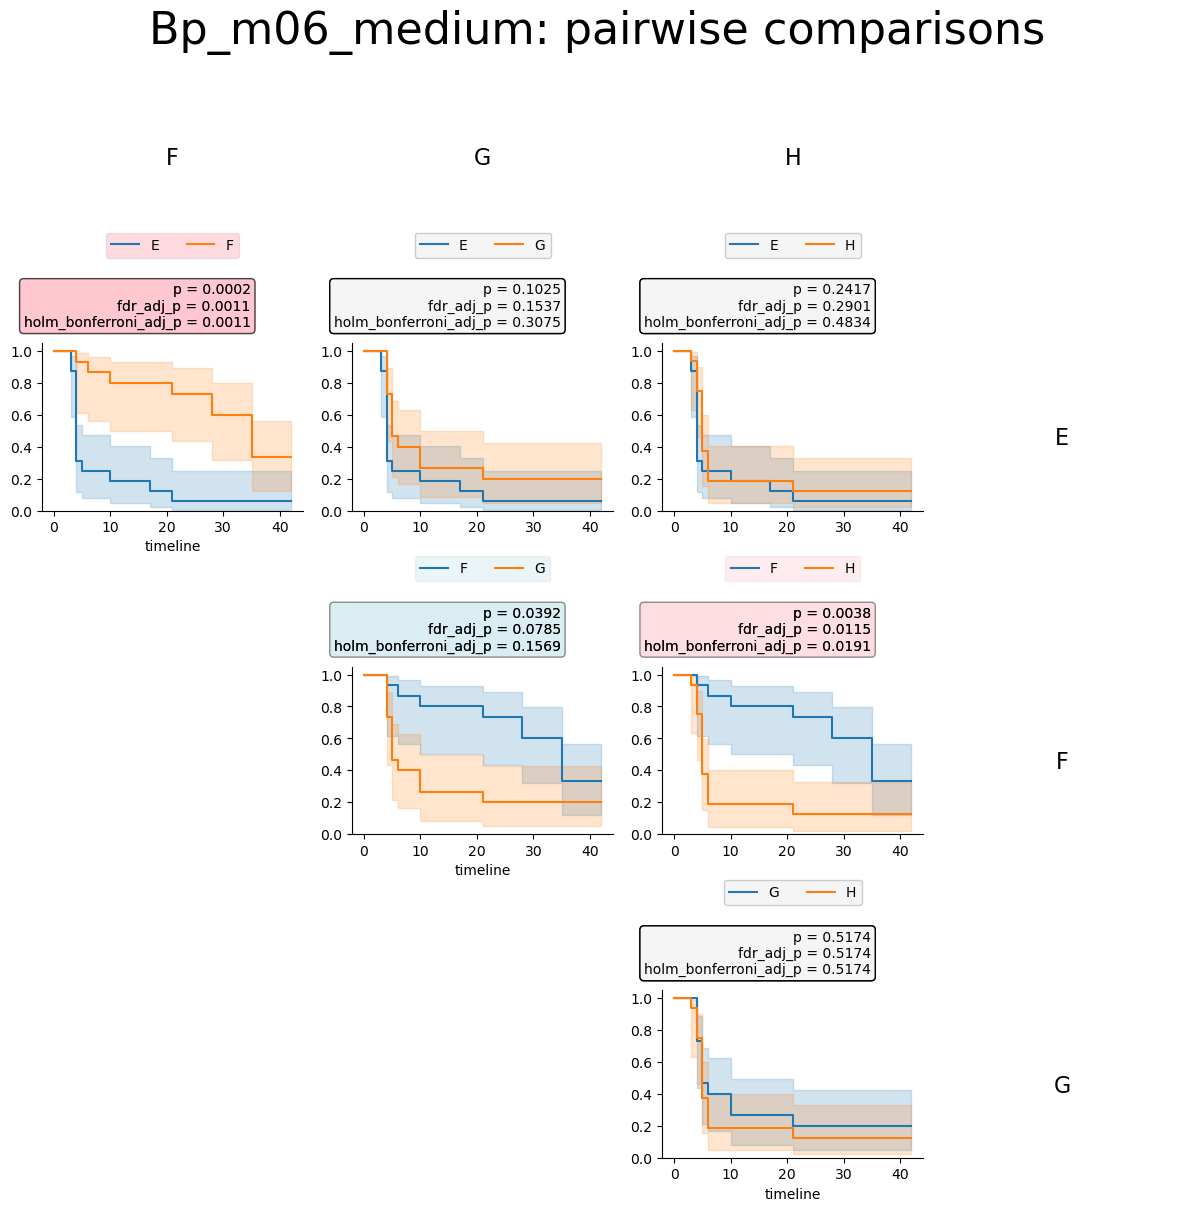

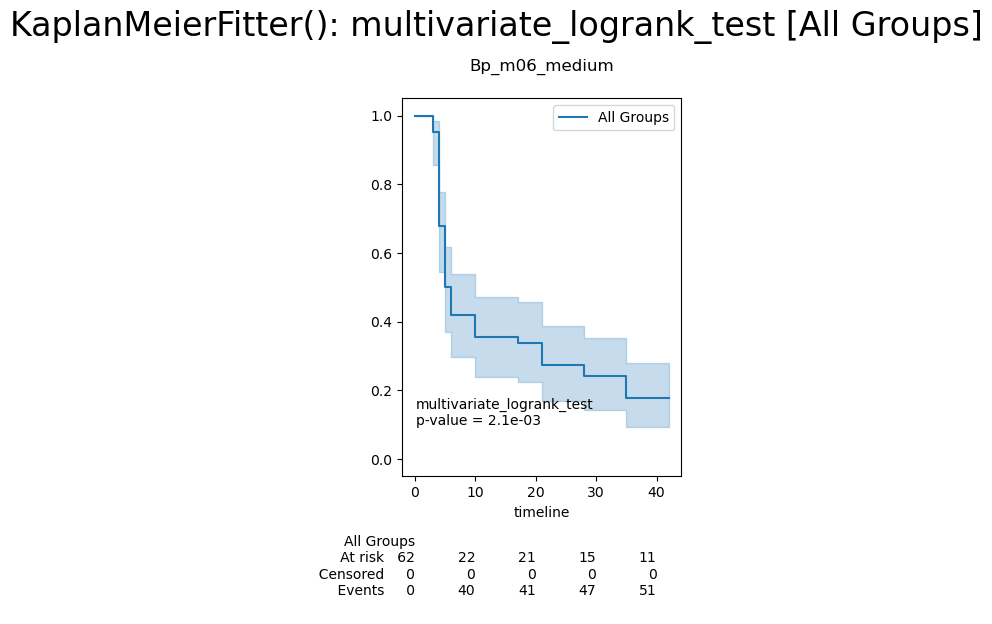

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           64 non-null     object
 1   Group_Name                      64 non-null     object
 2   Mouse                           64 non-null     object
 3   Day                             64 non-null     int64 
 4   Death                           64 non-null     int64 
 5   Survival_with_sterile_immunity  64 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 21.1 KB


Group                                         Group_Name Mouse  Day  Death  \
0      I  Group I: PBS (ID x 3, 0.0e+00 CFU) [Bp = 2290 ...    I1    3      1   
1      I  Group I: PBS (ID x 3, 0.0e+00 CFU) [Bp = 2290 ...    I2    3      1   
2      I  Group I: PBS (ID x 3, 0.0e+00 CFU) [Bp = 2290 ...    I3    3      1   
3      I  Group I: PBS (ID x 3, 0.0e+00 CFU) [Bp = 2290 ...    I4    3      1   
4      I  Group I: PBS (ID x 3, 0.0e+00 CFU) [Bp = 2290 ...    I5    4      1   
..   ...                                                ...   ...  ...    ...   
59     L  Group L: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...   L12   35      1   
60     L  Group L: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...   L13    7      1   
61     L  Group L: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...   L14    3      1   
62     L  Group L: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...   L15    4      1   
63     L  Group L: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...   L16    4      1   

    Survival_with_sterile_immunity  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0  
..                             ...  
59                               0  
60                               0  
61                               0  
62                               0  
63                               0  

[64 rows x 6 columns]

Group                                         Group_Name Mouse  \
count     64                                                 64    64   
unique     4                                                  4    64   
top        I  Group I: PBS (ID x 3, 0.0e+00 CFU) [Bp = 2290 ...    I1   
freq      16                                                 16     1   
mean     NaN                                                NaN   NaN   
std      NaN                                                NaN   NaN   
min      NaN                                                NaN   NaN   
25%      NaN                                                NaN   NaN   
50%      NaN                                                NaN   NaN   
75%      NaN                                                NaN   NaN   
max      NaN                                                NaN   NaN   

              Day      Death  Survival_with_sterile_immunity  
count   64.000000  64.000000                       64.000000  
unique        NaN        NaN                             NaN  
top           NaN        NaN                             NaN  
freq          NaN        NaN                             NaN  
mean    10.640625   0.921875                        0.062500  
std     13.095943   0.270490                        0.243975  
min      2.000000   0.000000                        0.000000  
25%      3.000000   1.000000                        0.000000  
50%      4.000000   1.000000                        0.000000  
75%     14.000000   1.000000                        0.000000  
max     42.000000   1.000000                        1.000000

Day
0     2
1     3
2     4
3     5
4     6
5     7
6    14
7    21
8    28
9    35
10   42

Group
0     I
1     J
2     K
3     L

Group_Name
0  Group I: PBS (ID x 3, 0.0e+00 CFU) [Bp = 2290 ...
1  Group J: Bp82 (ID x 3, 1.0e+06 CFU) [Bp = 2290...
2  Group K: LVS ΔcapB (ID x 3, 2.0e+06 CFU) [Bp =...
3  Group L: rLVS ΔcapB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...

Mouse
0     I1
1    I10
2    I11
3    I12
4    I13
..   ...
59    L5
60    L6
61    L7
62    L8
63    L9

[64 rows x 1 columns]

Death
0      0
1      1

Survival_with_sterile_immunity
0                               0
1                               1

Group_1 Group_2 pair  uncorrected_p_value  p_value_fdr_bh  \
index                                                             
0           I       J  I-J         9.551045e-09    5.730627e-08   
1           I       K  I-K         1.714486e-02    2.571729e-02   
2           I       L  I-L         1.836460e-01    2.203752e-01   
3           J       K  J-K         8.755739e-06    1.751148e-05   
4           J       L  J-L         2.571816e-06    7.715449e-06   
5           K       L  K-L         4.555136e-01    4.555136e-01   

       p_value_holm_bonferroni  p_value_holm_sidak sig_uncorrected sig_fdr_bh  \
index                                                                           
0                 5.730627e-08        5.730627e-08            ****       ****   
1                 5.143457e-02        5.055777e-02               *          *   
2                 3.672919e-01        3.335661e-01              ns         ns   
3                 3.502296e-05        3.502250e-05            ****       ****   
4                 1.285908e-05        1.285902e-05            ****       ****   
5                 4.555136e-01        4.555136e-01              ns         ns   

      sig_holm_bonferroni sig_holm_sidak  
index                                     
0                    ****           ****  
1                      ns             ns  
2                      ns             ns  
3                    ****           ****  
4                    ****           ****  
5                      ns             ns

final_survival  upper_0.95  lower_0.95  median_survival_time
Group                                                              
I              0.0000    0.000000    0.000000                   3.0
J              0.3125    0.536497    0.113871                  28.0
K              0.0000    0.000000    0.000000                   4.0
L              0.0000    0.000000    0.000000                   3.0

Group  Died  Survived  total_mice  Survival_with_sterile_immunity  \
0     I    16         0          16                               0   
1     J    11         5          16                               4   
2     K    16         0          16                               0   
3     L    16         0          16                               0   

   not_sterile  percent_survival  percent_sterile  
0           16              0.00              0.0  
1           12             31.25             25.0  
2           16              0.00              0.0  
3           16              0.00              0.0

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      I-J                     0.023469                0.046938   
1      I-K                     1.000000                1.000000   
2      I-L                     1.000000                1.000000   
3      J-K                     0.023469                0.046938   
4      J-L                     0.023469                0.046938   
5      K-L                     1.000000                1.000000   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.140814                    0.132806   
1                             1.000000                    1.000000   
2                             1.000000                    1.000000   
3                             0.140814                    0.132806   
4                             0.140814                    0.132806   
5                             1.000000                    1.000000   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                           *                  *                          ns   
1                          ns                 ns                          ns   
2                          ns                 ns                          ns   
3                           *                  *                          ns   
4                           *                  *                          ns   
5                          ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns  
3                         ns  
4                         ns  
5                         ns

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      I-J                     0.053357                0.106715   
1      I-K                     1.000000                1.000000   
2      I-L                     1.000000                1.000000   
3      J-K                     0.053357                0.106715   
4      J-L                     0.053357                0.106715   
5      K-L                     1.000000                1.000000   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.320145                    0.280359   
1                             1.000000                    1.000000   
2                             1.000000                    1.000000   
3                             0.320145                    0.280359   
4                             0.320145                    0.280359   
5                             1.000000                    1.000000   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                          ns                 ns                          ns   
3                          ns                 ns                          ns   
4                          ns                 ns                          ns   
5                          ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns  
3                         ns  
4                         ns  
5                         ns

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          38.82 <0.005     25.66

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
     test_statistic      p  -log2(p)
I J           32.93 <0.005     26.64
  K            5.68   0.02      5.87
  L            1.77   0.18      2.45
J K           19.77 <0.005     16.80
  L           22.11 <0.005     18.57
K L            0.56   0.46      1.13

{'I': <lifelines.KaplanMeierFitter:"I", fitted with 16 total observations, 0 right-censored observations>,
 'J': <lifelines.KaplanMeierFitter:"J", fitted with 16 total observations, 5 right-censored observations>,
 'K': <lifelines.KaplanMeierFitter:"K", fitted with 16 total observations, 0 right-censored observations>,
 'L': <lifelines.KaplanMeierFitter:"L", fitted with 16 total observations, 0 right-censored observations>}

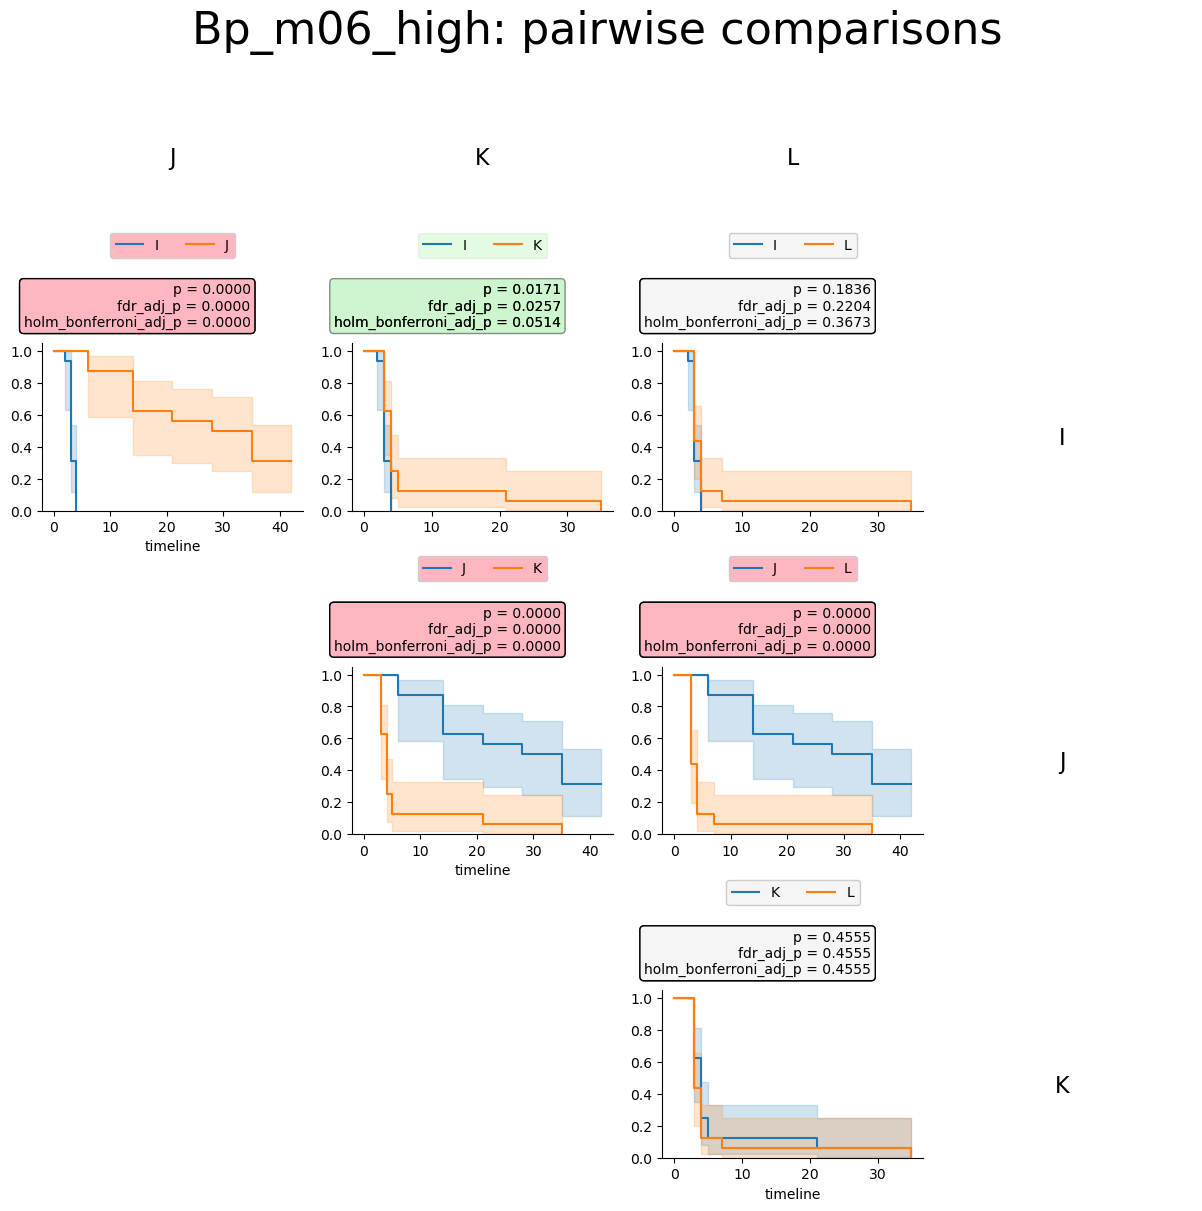

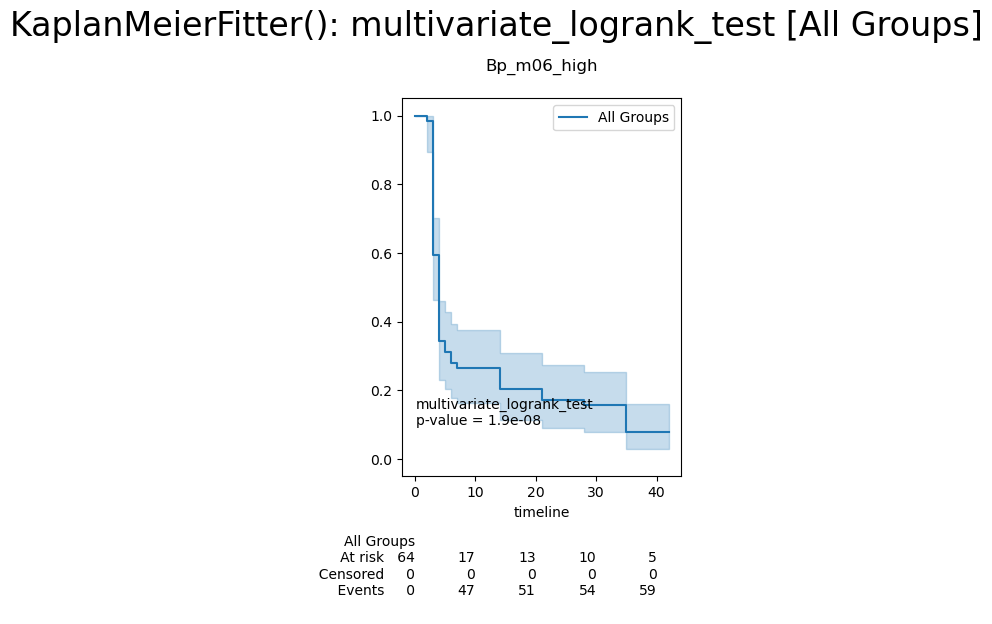

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           64 non-null     object
 1   Group_Name                      64 non-null     object
 2   Mouse                           64 non-null     object
 3   Day                             64 non-null     int64 
 4   Death                           64 non-null     int64 
 5   Survival_with_sterile_immunity  64 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 15.4 KB


Group                                         Group_Name Mouse  Day  Death  \
0      A                 Group A: PBS (ID x 3, 0.0e+00 CFU)    A1    3      1   
1      A                 Group A: PBS (ID x 3, 0.0e+00 CFU)    A2    3      1   
2      A                 Group A: PBS (ID x 3, 0.0e+00 CFU)    A3    3      1   
3      A                 Group A: PBS (ID x 3, 0.0e+00 CFU)    A4    3      1   
4      A                 Group A: PBS (ID x 3, 0.0e+00 CFU)    A5    3      1   
..   ...                                                ...   ...  ...    ...   
59     D  Group D: rLVS ?capB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...   D12   31      1   
60     D  Group D: rLVS ?capB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...   D13   42      0   
61     D  Group D: rLVS ?capB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...   D14   42      0   
62     D  Group D: rLVS ?capB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...   D15   42      0   
63     D  Group D: rLVS ?capB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...   D16   29      1   

    Survival_with_sterile_immunity  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0  
..                             ...  
59                               0  
60                               1  
61                               1  
62                               0  
63                               0  

[64 rows x 6 columns]

Group                          Group_Name Mouse        Day      Death  \
count     64                                  64    64  64.000000  64.000000   
unique     4                                   4    64        NaN        NaN   
top        A  Group A: PBS (ID x 3, 0.0e+00 CFU)    A1        NaN        NaN   
freq      16                                  16     1        NaN        NaN   
mean     NaN                                 NaN   NaN  16.500000   0.796875   
std      NaN                                 NaN   NaN  16.553904   0.405505   
min      NaN                                 NaN   NaN   3.000000   0.000000   
25%      NaN                                 NaN   NaN   3.000000   1.000000   
50%      NaN                                 NaN   NaN   5.000000   1.000000   
75%      NaN                                 NaN   NaN  34.500000   1.000000   
max      NaN                                 NaN   NaN  42.000000   1.000000   

        Survival_with_sterile_immunity  
count                        64.000000  
unique                             NaN  
top                                NaN  
freq                               NaN  
mean                          0.078125  
std                           0.270490  
min                           0.000000  
25%                           0.000000  
50%                           0.000000  
75%                           0.000000  
max                           1.000000

Day
0     3
1     4
2     5
3     6
4    17
5    22
6    27
7    29
8    31
9    34
10   36
11   42

Group
0     A
1     B
2     C
3     D

Group_Name
0                 Group A: PBS (ID x 3, 0.0e+00 CFU)
1                Group B: Bp82 (ID x 3, 1.0e+06 CFU)
2  Group C: rLVS ?capB/Bp Hcp6-Hcp1-Hcp2 (ID x 3,...
3  Group D: rLVS ?capB/Bp Hcp6-Hcp1-Hcp2 (IN x 3,...

Mouse
0     A1
1    A10
2    A11
3    A12
4    A13
..   ...
59    D5
60    D6
61    D7
62    D8
63    D9

[64 rows x 1 columns]

Death
0      0
1      1

Survival_with_sterile_immunity
0                               0
1                               1

Group_1 Group_2 pair  uncorrected_p_value  p_value_fdr_bh  \
index                                                             
0           A       B  A-B         9.093409e-07    1.818682e-06   
1           A       C  A-C         2.580284e-08    7.740853e-08   
2           A       D  A-D         2.580284e-08    7.740853e-08   
3           B       C  B-C         1.182981e-03    1.419577e-03   
4           B       D  B-D         6.143441e-01    6.143441e-01   
5           C       D  C-D         2.292820e-04    3.439231e-04   

       p_value_holm_bonferroni  p_value_holm_sidak sig_uncorrected sig_fdr_bh  \
index                                                                           
0                 3.637364e-06        3.637359e-06            ****       ****   
1                 1.548171e-07        1.548170e-07            ****       ****   
2                 1.548171e-07        1.548170e-07            ****       ****   
3                 2.365962e-03        2.364563e-03              **         **   
4                 6.143441e-01        6.143441e-01              ns         ns   
5                 6.878461e-04        6.876884e-04             ***        ***   

      sig_holm_bonferroni sig_holm_sidak  
index                                     
0                    ****           ****  
1                    ****           ****  
2                    ****           ****  
3                      **             **  
4                      ns             ns  
5                     ***            ***

final_survival  upper_0.95  lower_0.95  median_survival_time
Group                                                              
A              0.0000    0.000000    0.000000                   3.0
B              0.3125    0.536497    0.113871                  34.0
C              0.0625    0.246994    0.004098                   4.0
D              0.4375    0.655644    0.198117                  29.0

Group  Died  Survived  total_mice  Survival_with_sterile_immunity  \
0     A    16         0          16                               0   
1     B    11         5          16                               1   
2     C    15         1          16                               0   
3     D     9         7          16                               4   

   not_sterile  percent_survival  percent_sterile  
0           16              0.00             0.00  
1           15             31.25             6.25  
2           16              6.25             0.00  
3           12             43.75            25.00

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      A-B                     0.023469                0.049199   
1      A-C                     0.500000                0.567982   
2      A-D                     0.002693                0.016157   
3      B-C                     0.083613                0.125420   
4      B-D                     0.567982                0.567982   
5      C-D                     0.024599                0.049199   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.117345                    0.111965   
1                             1.000000                    0.750000   
2                             0.016157                    0.016049   
3                             0.250840                    0.230451   
4                             1.000000                    0.750000   
5                             0.117345                    0.111965   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                           *                  *                          ns   
1                          ns                 ns                          ns   
2                          **                  *                           *   
3                          ns                 ns                          ns   
4                          ns                 ns                          ns   
5                           *                  *                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                          *  
3                         ns  
4                         ns  
5                         ns

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                             
0      A-B                     0.500000                0.600000   
1      A-C                     1.000000                1.000000   
2      A-D                     0.053357                0.160072   
3      B-C                     0.500000                0.600000   
4      B-D                     0.176418                0.352835   
5      C-D                     0.053357                0.160072   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             1.000000                    0.875000   
1                             1.000000                    1.000000   
2                             0.320145                    0.280359   
3                             1.000000                    0.875000   
4                             0.705671                    0.539926   
5                             0.320145                    0.280359   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                          ns                 ns                          ns   
3                          ns                 ns                          ns   
4                          ns                 ns                          ns   
5                          ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns  
3                         ns  
4                         ns  
5                         ns

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          66.16 <0.005     45.00

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
     test_statistic      p  -log2(p)
A B           24.11 <0.005     20.07
  C           31.00 <0.005     25.21
  D           31.00 <0.005     25.21
B C           10.52 <0.005      9.72
  D            0.25   0.61      0.70
C D           13.57 <0.005     12.09

{'A': <lifelines.KaplanMeierFitter:"A", fitted with 16 total observations, 0 right-censored observations>,
 'B': <lifelines.KaplanMeierFitter:"B", fitted with 16 total observations, 5 right-censored observations>,
 'C': <lifelines.KaplanMeierFitter:"C", fitted with 16 total observations, 1 right-censored observations>,
 'D': <lifelines.KaplanMeierFitter:"D", fitted with 16 total observations, 7 right-censored observations>}

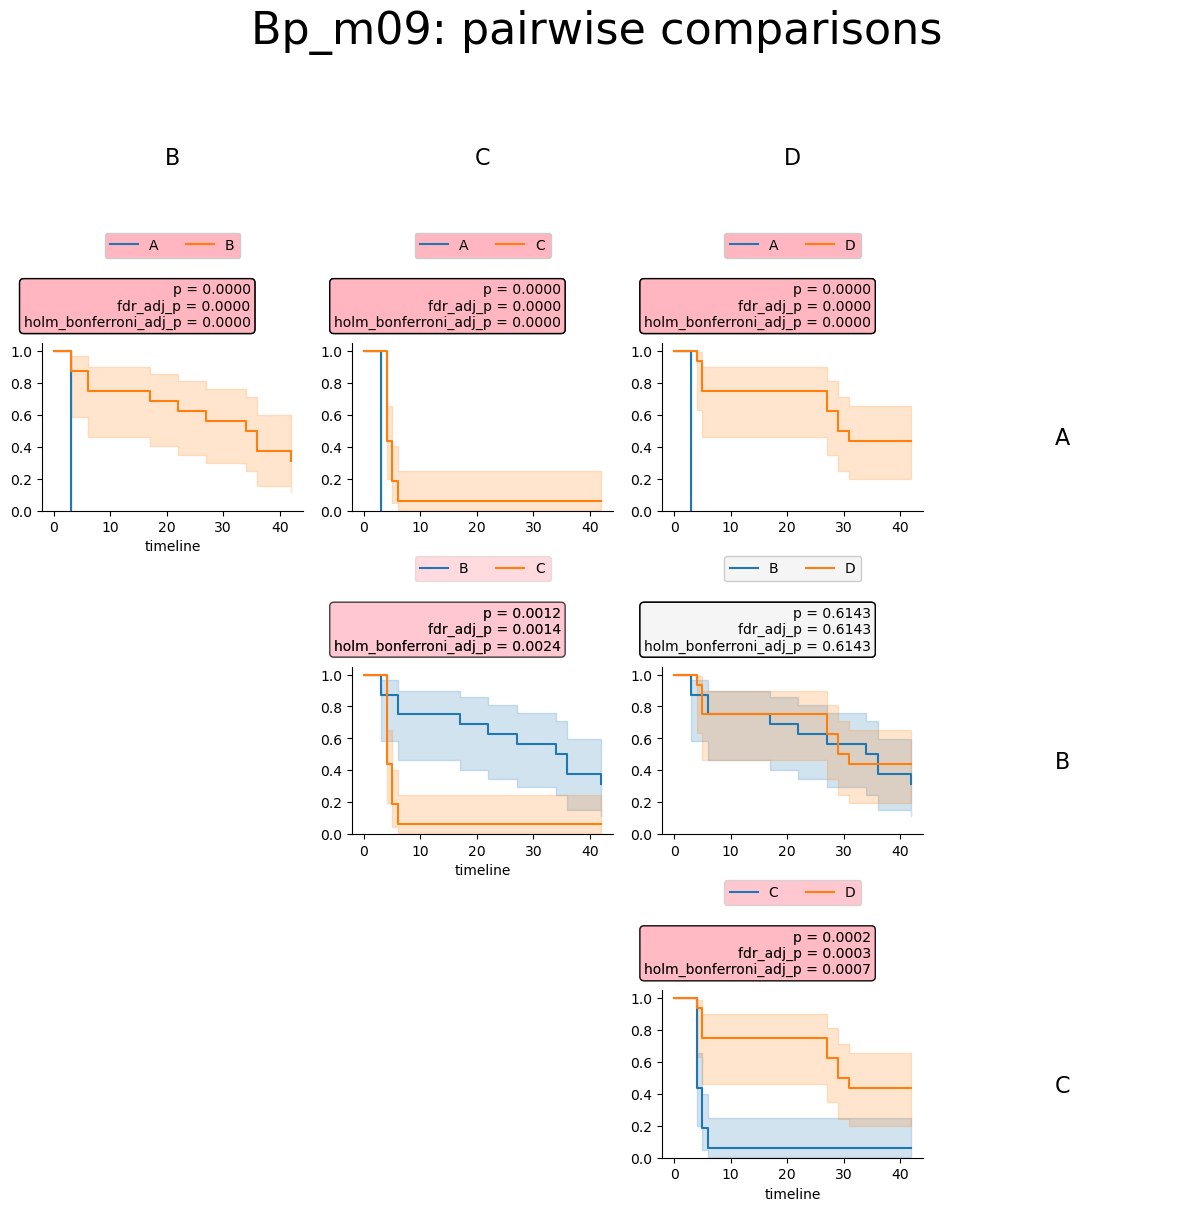

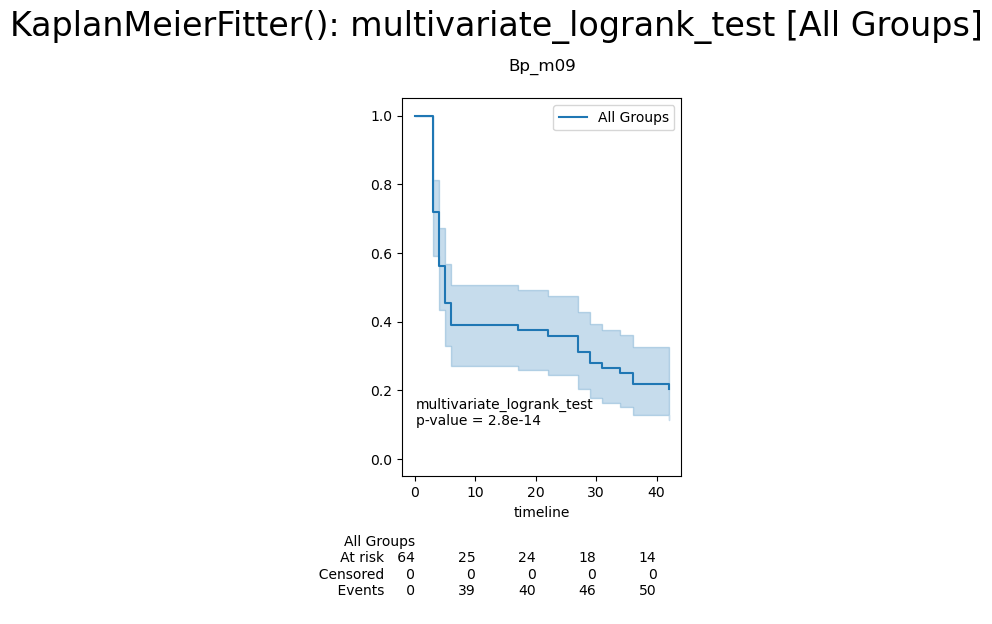

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           96 non-null     object
 1   Group_Name                      96 non-null     object
 2   Mouse                           96 non-null     object
 3   Day                             96 non-null     int64 
 4   Death                           96 non-null     int64 
 5   Survival_with_sterile_immunity  96 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 29.5 KB


Group                                         Group_Name Mouse  Day  Death  \
0      A                                      Group A (PBS)    A1    3      1   
1      A                                      Group A (PBS)    A2    3      1   
2      A                                      Group A (PBS)    A3    3      1   
3      A                                      Group A (PBS)    A4    3      1   
4      A                                      Group A (PBS)    A5    3      1   
..   ...                                                ...   ...  ...    ...   
91     L  Group L (rLVS ΔcapB/Bp Hcp6-Hcp2 + rLVS ΔcapB/...    L4   42      0   
92     L  Group L (rLVS ΔcapB/Bp Hcp6-Hcp2 + rLVS ΔcapB/...    L5   42      0   
93     L  Group L (rLVS ΔcapB/Bp Hcp6-Hcp2 + rLVS ΔcapB/...    L6   42      0   
94     L  Group L (rLVS ΔcapB/Bp Hcp6-Hcp2 + rLVS ΔcapB/...    L7   42      0   
95     L  Group L (rLVS ΔcapB/Bp Hcp6-Hcp2 + rLVS ΔcapB/...    L8   29      1   

    Survival_with_sterile_immunity  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0  
..                             ...  
91                               1  
92                               1  
93                               1  
94                               1  
95                               0  

[96 rows x 6 columns]

Group                             Group_Name Mouse        Day  \
count      96                                     96    96  96.000000   
unique      8                                      8    96        NaN   
top     CDEFG  Groups CDEFG Combined LVS Groups (ID)    A1        NaN   
freq       40                                     40     1        NaN   
mean      NaN                                    NaN   NaN  26.822917   
std       NaN                                    NaN   NaN  17.889718   
min       NaN                                    NaN   NaN   3.000000   
25%       NaN                                    NaN   NaN   3.000000   
50%       NaN                                    NaN   NaN  42.000000   
75%       NaN                                    NaN   NaN  42.000000   
max       NaN                                    NaN   NaN  42.000000   

            Death  Survival_with_sterile_immunity  
count   96.000000                       96.000000  
unique        NaN                             NaN  
top           NaN                             NaN  
freq          NaN                             NaN  
mean     0.468750                        0.385417  
std      0.501642                        0.489248  
min      0.000000                        0.000000  
25%      0.000000                        0.000000  
50%      0.000000                        0.000000  
75%      1.000000                        1.000000  
max      1.000000                        1.000000

Day
0     3
1     4
2    19
3    20
4    23
5    27
6    29
7    30
8    35
9    40
10   42

Group
0      A
1      B
2  CDEFG
3      H
4      I
5      J
6      K
7      L

Group_Name
0                                      Group A (PBS)
1                                Group B (Bp82, 1e6)
2  Group H (rLVS ΔcapB/Bp Hcp6-Hcp1 + rLVS ΔcapB/...
3  Group I (rLVS ΔcapB/Bp Hcp6-Hcp2 + rLVS ΔcapB/...
4  Group J (rLVS ΔcapB/Bp Hcp6 + rLVS ΔcapB/Bp Lo...
5  Group K (rLVS ΔcapB/Bp Hcp6-Hcp1 + rLVS ΔcapB/...
6  Group L (rLVS ΔcapB/Bp Hcp6-Hcp2 + rLVS ΔcapB/...
7              Groups CDEFG Combined LVS Groups (ID)

Mouse
0     A1
1     A2
2     A3
3     A4
4     A5
..   ...
91    L4
92    L5
93    L6
94    L7
95    L8

[96 rows x 1 columns]

Death
0      0
1      1

Survival_with_sterile_immunity
0                               0
1                               1

Group_1 Group_2     pair  uncorrected_p_value  p_value_fdr_bh  \
index                                                                 
0           A       B      A-B             0.000636        0.001485   
1           A   CDEFG  A-CDEFG             0.000508        0.001485   
2           A       H      A-H             0.000636        0.001485   
3           A       I      A-I             1.000000        1.000000   
4           A       J      A-J             0.000108        0.000502   
5           A       K      A-K             0.000108        0.000502   
6           A       L      A-L             0.000108        0.000502   
7           B   CDEFG  B-CDEFG             0.230726        0.380019   
8           B       H      B-H             0.554772        0.810164   
9           B       I      B-I             0.000636        0.001485   
10          B       J      B-J             0.885676        0.980758   
11          B       K      B-K             0.856625        0.980758   
12          B       L      B-L             0.885676        0.980758   
13      CDEFG       H  CDEFG-H             0.071603        0.154223   
14      CDEFG       I  CDEFG-I             0.000508        0.001485   
15      CDEFG       J  CDEFG-J             0.178768        0.333701   
16      CDEFG       K  CDEFG-K             0.196105        0.343183   
17      CDEFG       L  CDEFG-L             0.178768        0.333701   
18          H       I      H-I             0.000636        0.001485   
19          H       J      H-J             0.589708        0.810164   
20          H       K      H-K             0.607623        0.810164   
21          H       L      H-L             0.589708        0.810164   
22          I       J      I-J             0.000108        0.000502   
23          I       K      I-K             0.000108        0.000502   
24          I       L      I-L             0.000108        0.000502   
25          J       K      J-K             0.910704        0.980758   
26          J       L      J-L             0.972867        1.000000   
27          K       L      K-L             0.910704        0.980758   

       p_value_holm_bonferroni  p_value_holm_sidak sig_uncorrected sig_fdr_bh  \
index                                                                           
0                     0.012726            0.012649             ***         **   
1                     0.011178            0.011119             ***         **   
2                     0.012726            0.012649             ***         **   
3                     1.000000            1.000000              ns         ns   
4                     0.003010            0.003006             ***        ***   
5                     0.003010            0.003006             ***        ***   
6                     0.003010            0.003006             ***        ***   
7                     1.000000            0.957049              ns         ns   
8                     1.000000            0.999864              ns         ns   
9                     0.012726            0.012649             ***         **   
10                    1.000000            0.999999              ns         ns   
11                    1.000000            0.999999              ns         ns   
12                    1.000000            0.999999              ns         ns   
13                    1.000000            0.695395              ns         ns   
14                    0.011178            0.011119             ***         **   
15                    1.000000            0.947882              ns         ns   
16                    1.000000            0.947882              ns         ns   
17                    1.000000            0.947882              ns         ns   
18                    0.012726            0.012649             ***         **   
19                    1.000000            0.999865              ns         ns   
20                    1.000000            0.999865              ns         ns   
21          

final_survival  upper_0.95  lower_0.95  median_survival_time
Group                                                              
A               0.000    0.000000    0.000000                   3.0
B               0.750    0.930898    0.314807                   inf
CDEFG           0.500    0.641941    0.338270                  40.0
H               0.875    0.981393    0.387000                   inf
I               0.000    0.000000    0.000000                   3.0
J               0.750    0.930898    0.314807                   inf
K               0.750    0.930898    0.314807                   inf
L               0.750    0.930898    0.314807                   inf

Group  Died  Survived  total_mice  Survival_with_sterile_immunity  \
0      A     8         0           8                               0   
1      B     2         6           8                               4   
2  CDEFG    20        20          40                              15   
3      H     1         7           8                               3   
4      I     8         0           8                               0   
5      J     2         6           8                               5   
6      K     2         6           8                               4   
7      L     2         6           8                               6   

   not_sterile  percent_survival  percent_sterile  
0            8               0.0              0.0  
1            4              75.0             50.0  
2           25              50.0             37.5  
3            5              87.5             37.5  
4            8               0.0              0.0  
5            3              75.0             62.5  
6            4              75.0             50.0  
7            2              75.0             75.0

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                                 
0          A-B                     0.001892                0.005298   
1      A-CDEFG                     0.009634                0.022480   
2          A-H                     0.000305                0.004272   
3          A-I                     1.000000                1.000000   
4          A-J                     0.001892                0.005298   
5          A-K                     0.001892                0.005298   
6          A-L                     0.001892                0.005298   
7      B-CDEFG                     0.222950                0.367212   
8          B-H                     0.691029                0.921372   
9          B-I                     0.001892                0.005298   
10         B-J                     1.000000                1.000000   
11         B-K                     1.000000                1.000000   
12         B-L                     1.000000                1.000000   
13     CDEFG-H                     0.058695                0.126420   
14     CDEFG-I                     0.009634                0.022480   
15     CDEFG-J                     0.222950                0.367212   
16     CDEFG-K                     0.222950                0.367212   
17     CDEFG-L                     0.222950                0.367212   
18         H-I                     0.000305                0.004272   
19         H-J                     0.688950                0.921372   
20         H-K                     0.688950                0.921372   
21         H-L                     0.688950                0.921372   
22         I-J                     0.001892                0.005298   
23         I-K                     0.001892                0.005298   
24         I-L                     0.001892                0.005298   
25         J-K                     1.000000                1.000000   
26         J-L                     1.000000                1.000000   
27         K-L                     1.000000                1.000000   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.049194                    0.048048   
1                             0.173416                    0.159919   
2                             0.008545                    0.008510   
3                             1.000000                    1.000000   
4                             0.049194                    0.048048   
5                             0.049194                    0.048048   
6                             0.049194                    0.048048   
7                             1.000000                    0.977263   
8                             1.000000                    0.999997   
9                             0.049194                    0.048048   
10                            1.000000                    1.000000   
11                            1.000000                    1.000000   
12                            1.000000                    1.000000   
13                            0.939118                    0.620085   
14                            0.173416                    0.159919   
15                            1.000000                    0.977263   
16                            1.000000                    0.977263   
17                            1.000000                    0.977263   
18                            0.008545                    0.008510   
19                            1.000000                    0.999997   
20                            1.000000                    0.999997   
21                            1.000000                    0.999997   
22                            0.049194                    0.048048   
23                            0.049194                    0.048048   
24                            0.049194                    0

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                                 
0          A-B                     0.026001                0.091003   
1      A-CDEFG                     0.039953                0.111868   
2          A-H                     0.081982                0.176577   
3          A-I                     1.000000                1.000000   
4          A-J                     0.009216                0.064514   
5          A-K                     0.026001                0.091003   
6          A-L                     0.001892                0.026489   
7      B-CDEFG                     0.568681                0.791454   
8          B-H                     0.689148                0.804006   
9          B-I                     0.019616                0.091003   
10         B-J                     0.689148                0.804006   
11         B-K                     1.000000                1.000000   
12         B-L                     0.391784                0.645291   
13     CDEFG-H                     1.000000                1.000000   
14     CDEFG-I                     0.039953                0.111868   
15     CDEFG-J                     0.253773                0.473709   
16     CDEFG-K                     0.568681                0.791454   
17     CDEFG-L                     0.058695                0.149405   
18         H-I                     0.081982                0.176577   
19         H-J                     0.521359                0.791454   
20         H-K                     0.621857                0.791454   
21         H-L                     0.137695                0.275391   
22         I-J                     0.009216                0.064514   
23         I-K                     0.026001                0.091003   
24         I-L                     0.001892                0.026489   
25         J-K                     0.621857                0.791454   
26         J-L                     0.731109                0.818842   
27         K-L                     0.391784                0.645291   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.598022                    0.454436   
1                             0.799054                    0.557562   
2                             1.000000                    0.766401   
3                             1.000000                    1.000000   
4                             0.239624                    0.213950   
5                             0.598022                    0.454436   
6                             0.052979                    0.051647   
7                             1.000000                    0.999777   
8                             1.000000                    0.999777   
9                             0.470788                    0.378405   
10                            1.000000                    0.999777   
11                            1.000000                    1.000000   
12                            1.000000                    0.998441   
13                            1.000000                    1.000000   
14                            0.799054                    0.557562   
15                            1.000000                    0.983397   
16                            1.000000                    0.999777   
17                            1.000000                    0.663374   
18                            1.000000                    0.766401   
19                            1.000000                    0.999698   
20                            1.000000                    0.999777   
21                            1.000000                    0.891629   
22                            0.239624                    0.213950   
23                            0.598022                    0.454436   
24                            0.052979                    0

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 7
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          46.10 <0.005     23.51

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
             test_statistic      p  -log2(p)
A     B               11.67 <0.005     10.62
      CDEFG           12.09 <0.005     10.94
      H               11.67 <0.005     10.62
      I                0.00   1.00     -0.00
      J               15.00 <0.005     13.18
      K               15.00 <0.005     13.18
      L               15.00 <0.005     13.18
B     CDEFG            1.44   0.23      2.12
      H                0.35   0.55      0.85
      I               11.67 <0.005     10.62
      J                0.02   0.89      0.18
      K                0.03   0.86      0.22
      L                0.02   0.89      0.18
CDEFG H                3.25   0.07      3.80
      I               12.09 <0.005     10.94
      J                1.81   0.18      2.48
      K                1.67   0.20      2.35
      L                1.81   0.18      2.48
H     I               11.67 <0.005     10.62
      J                0.29   0.59      0.76
      K                0.26   0.61      0.72
      L                0.29   0.59      0.76
I     J               15.00 <0.005     13.18
      K               15.00 <0.005     13.18
      L               15.00 <0.005     13.18
J     K                0.01   0.91      0.13
      L                0.00   0.97      0.04
K     L                0.01   0.91      0.13

{'A': <lifelines.KaplanMeierFitter:"A", fitted with 8 total observations, 0 right-censored observations>,
 'B': <lifelines.KaplanMeierFitter:"B", fitted with 8 total observations, 6 right-censored observations>,
 'CDEFG': <lifelines.KaplanMeierFitter:"CDEFG", fitted with 40 total observations, 20 right-censored observations>,
 'H': <lifelines.KaplanMeierFitter:"H", fitted with 8 total observations, 7 right-censored observations>,
 'I': <lifelines.KaplanMeierFitter:"I", fitted with 8 total observations, 0 right-censored observations>,
 'J': <lifelines.KaplanMeierFitter:"J", fitted with 8 total observations, 6 right-censored observations>,
 'K': <lifelines.KaplanMeierFitter:"K", fitted with 8 total observations, 6 right-censored observations>,
 'L': <lifelines.KaplanMeierFitter:"L", fitted with 8 total observations, 6 right-censored observations>}

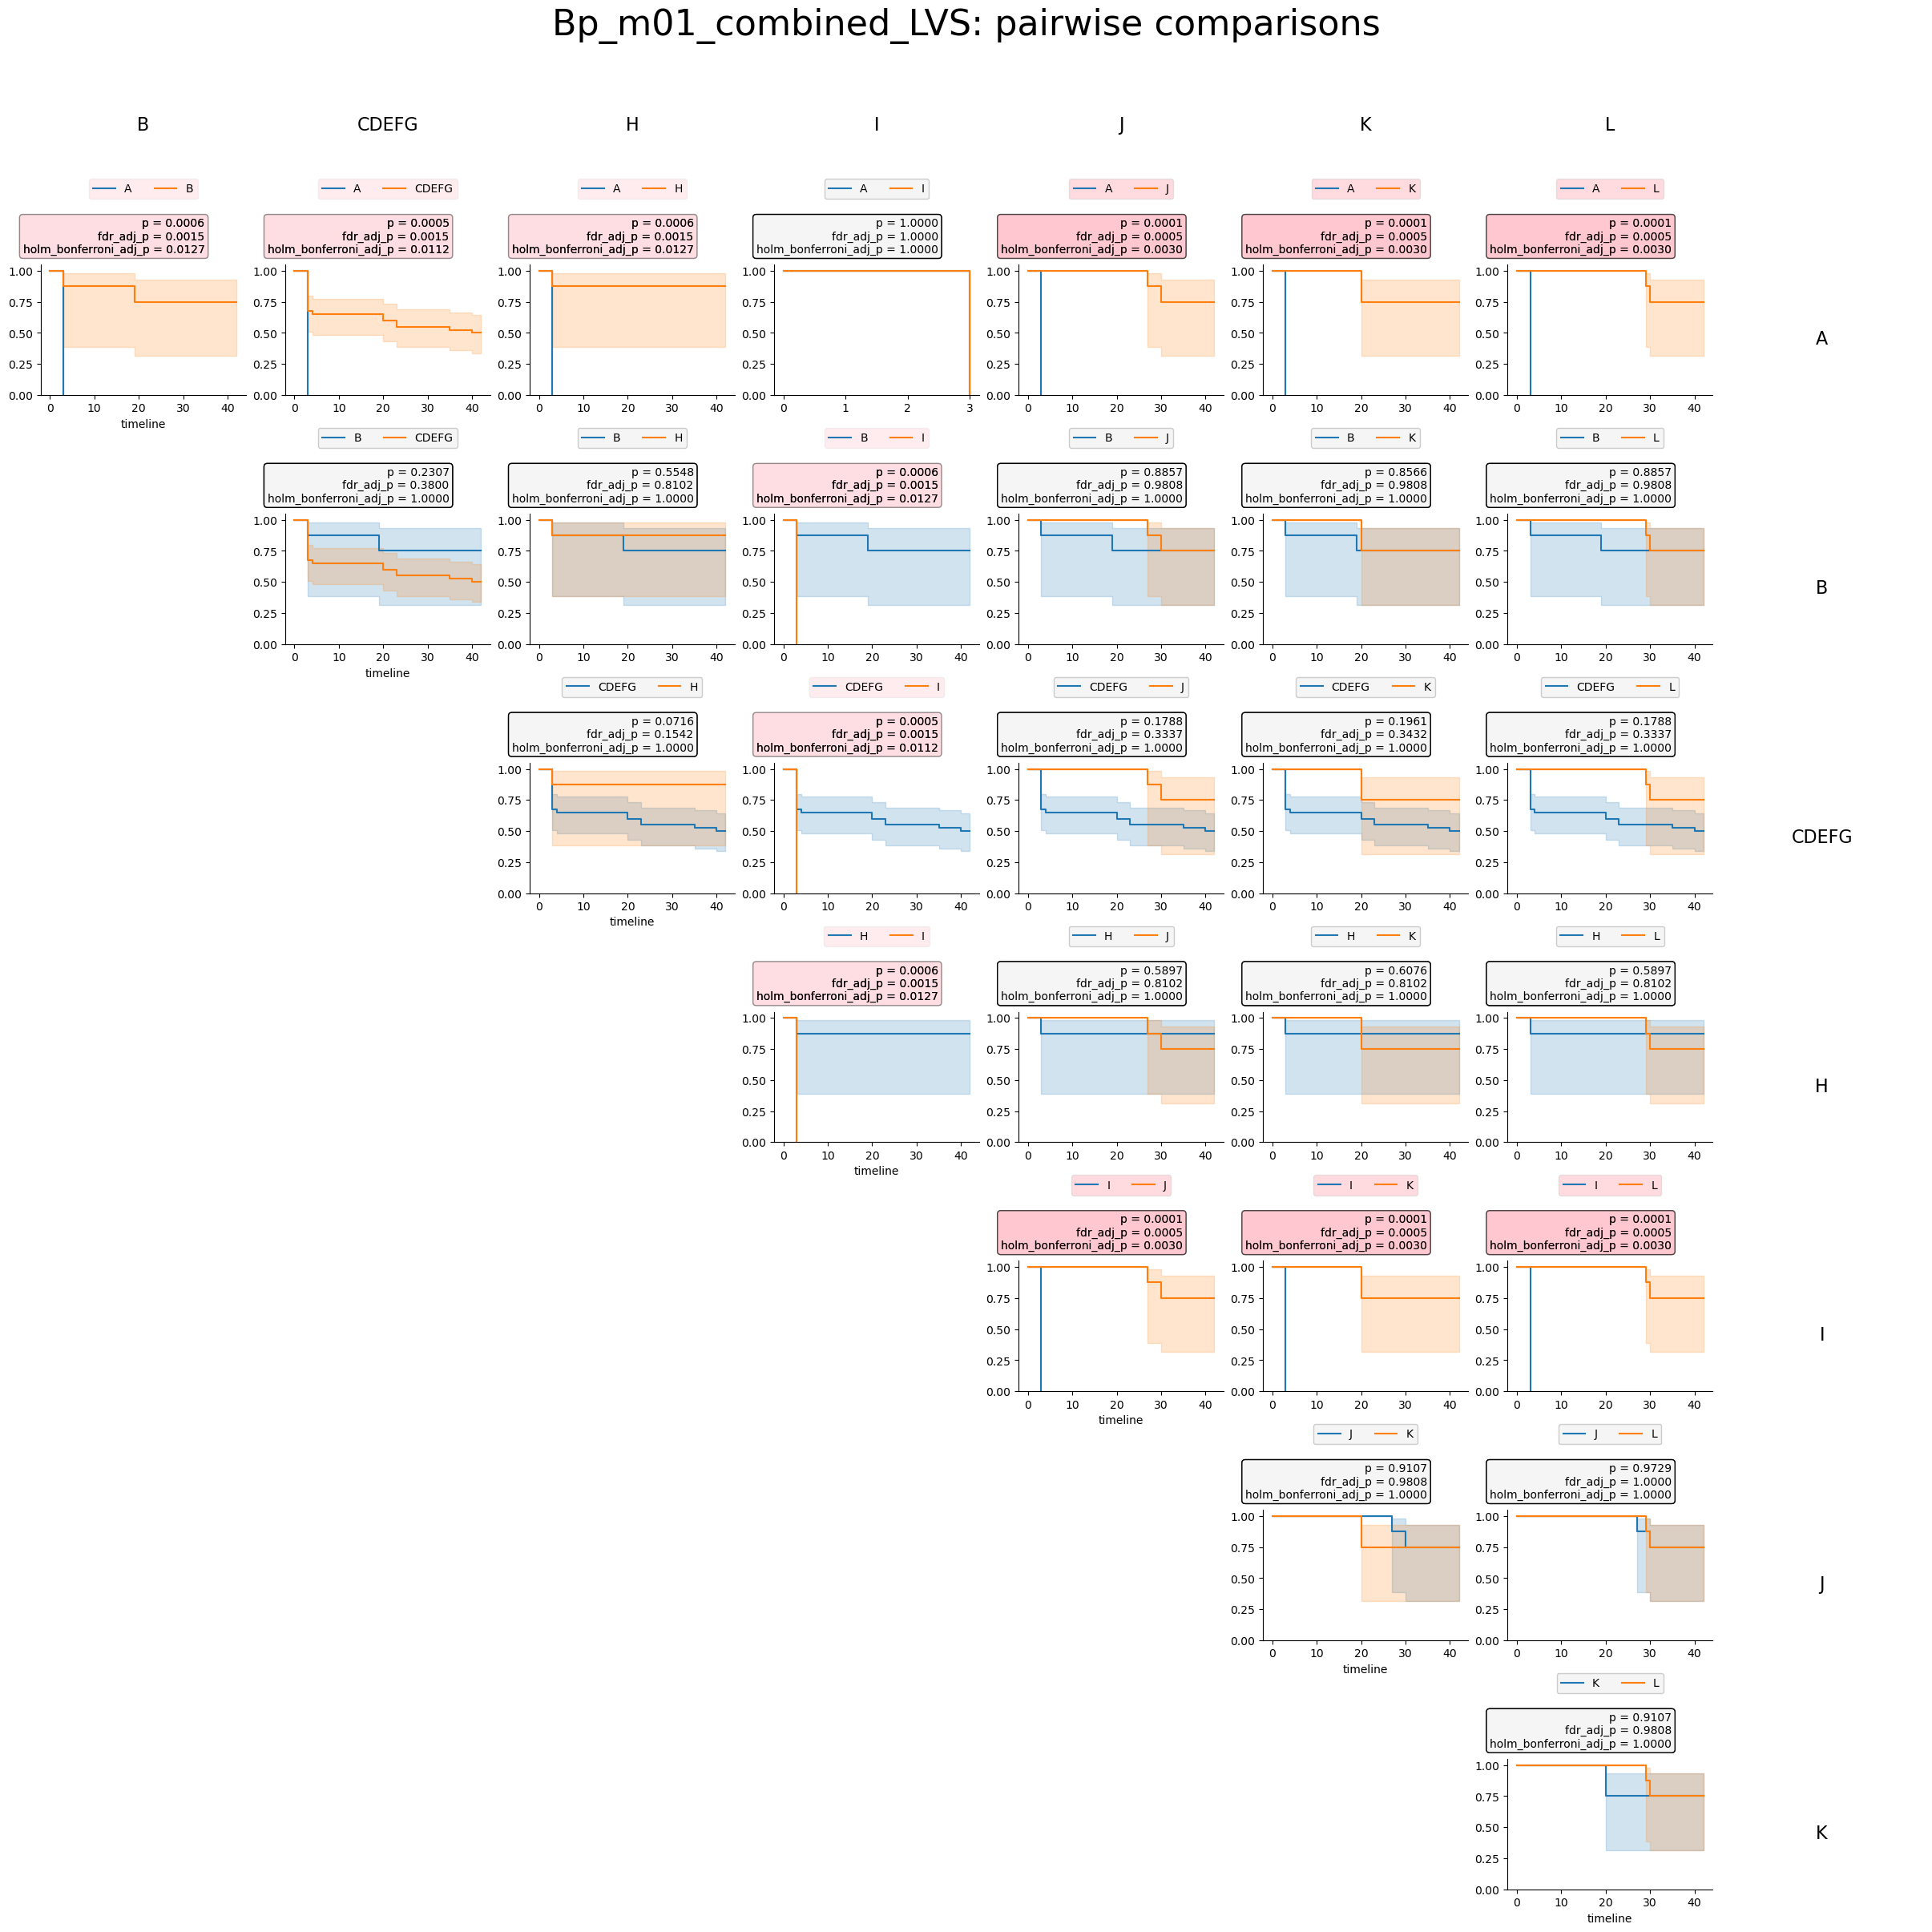

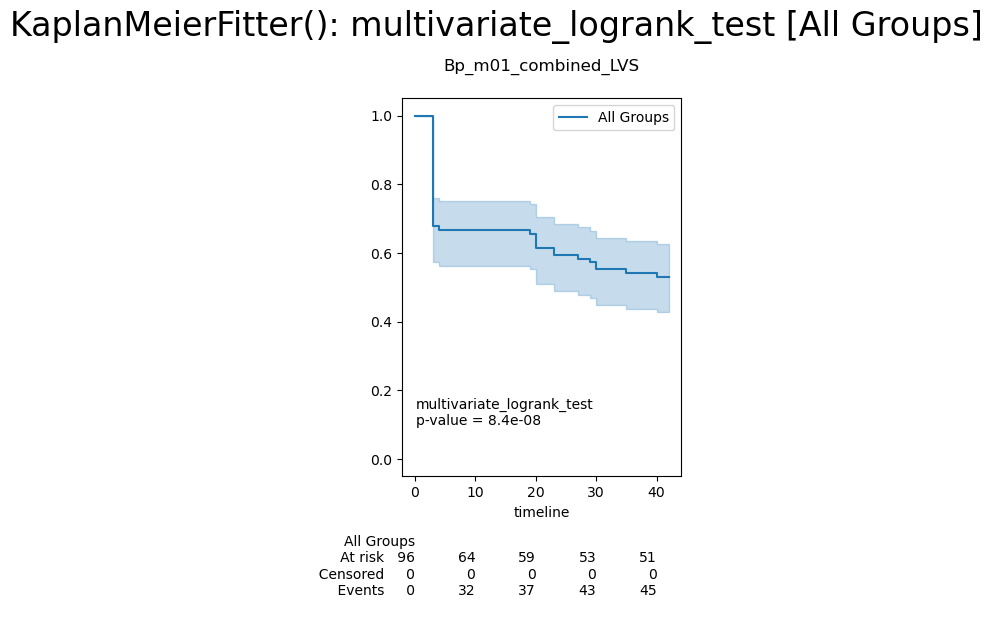

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           92 non-null     object
 1   Group_Name                      92 non-null     object
 2   Mouse                           92 non-null     object
 3   Day                             92 non-null     int64 
 4   Death                           92 non-null     int64 
 5   Survival_with_sterile_immunity  92 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 21.9 KB


Group                                  Group_Name Mouse  Day  Death  \
0            A                               Group A (PBS)    A1    2      1   
1            A                               Group A (PBS)    A2    2      1   
2            A                               Group A (PBS)    A3    2      1   
3            A                               Group A (PBS)    A4    2      1   
4            A                               Group A (PBS)    A5    2      1   
..         ...                                         ...   ...  ...    ...   
87  CDEFGHIJKL  Groups CDEFGHIJKL Combined LVS Groups (ID)    L4   39      1   
88  CDEFGHIJKL  Groups CDEFGHIJKL Combined LVS Groups (ID)    L5    2      1   
89  CDEFGHIJKL  Groups CDEFGHIJKL Combined LVS Groups (ID)    L6   42      0   
90  CDEFGHIJKL  Groups CDEFGHIJKL Combined LVS Groups (ID)    L7   42      0   
91  CDEFGHIJKL  Groups CDEFGHIJKL Combined LVS Groups (ID)    L8   42      0   

    Survival_with_sterile_immunity  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0  
..                             ...  
87                               0  
88                               0  
89                               1  
90                               0  
91                               0  

[92 rows x 6 columns]

Group                                  Group_Name Mouse  \
count           92                                          92    92   
unique           3                                           3    92   
top     CDEFGHIJKL  Groups CDEFGHIJKL Combined LVS Groups (ID)    A1   
freq            76                                          76     1   
mean           NaN                                         NaN   NaN   
std            NaN                                         NaN   NaN   
min            NaN                                         NaN   NaN   
25%            NaN                                         NaN   NaN   
50%            NaN                                         NaN   NaN   
75%            NaN                                         NaN   NaN   
max            NaN                                         NaN   NaN   

              Day      Death  Survival_with_sterile_immunity  
count   92.000000  92.000000                       92.000000  
unique        NaN        NaN                             NaN  
top           NaN        NaN                             NaN  
freq          NaN        NaN                             NaN  
mean    29.043478   0.413043                        0.315217  
std     17.734869   0.495079                        0.467148  
min      2.000000   0.000000                        0.000000  
25%      5.750000   0.000000                        0.000000  
50%     42.000000   0.000000                        0.000000  
75%     42.000000   1.000000                        1.000000  
max     42.000000   1.000000                        1.000000

Day
0     2
1     3
2     4
3     5
4     6
5     7
6     9
7    25
8    31
9    35
10   39
11   42

Group
0           A
1           B
2  CDEFGHIJKL

Group_Name
0                               Group A (PBS)
1                         Group B (Bp82, 1e6)
2  Groups CDEFGHIJKL Combined LVS Groups (ID)

Mouse
0     A1
1     A2
2     A3
3     A4
4     A5
..   ...
87    L4
88    L5
89    L6
90    L7
91    L8

[92 rows x 1 columns]

Death
0      0
1      1

Survival_with_sterile_immunity
0                               0
1                               1

Group_1     Group_2          pair  uncorrected_p_value  p_value_fdr_bh  \
index                                                                          
0           A           B           A-B         1.075112e-04    1.612668e-04   
1           A  CDEFGHIJKL  A-CDEFGHIJKL         4.478966e-13    1.343690e-12   
2           B  CDEFGHIJKL  B-CDEFGHIJKL         4.469474e-02    4.469474e-02   

       p_value_holm_bonferroni  p_value_holm_sidak sig_uncorrected sig_fdr_bh  \
index                                                                           
0                 2.150224e-04        2.150108e-04             ***        ***   
1                 1.343690e-12        1.343690e-12            ****       ****   
2                 4.469474e-02        4.469474e-02               *          *   

      sig_holm_bonferroni sig_holm_sidak  
index                                     
0                     ***            ***  
1                    ****           ****  
2                       *              *

final_survival  upper_0.95  lower_0.95  median_survival_time
Group                                                                   
A                 0.000000    0.000000    0.000000                   2.0
B                 1.000000    1.000000    1.000000                   inf
CDEFGHIJKL        0.605263    0.704875    0.486352                   inf

Group  Died  Survived  total_mice  Survival_with_sterile_immunity  \
0           A     8         0           8                               0   
1           B     0         8           8                               4   
2  CDEFGHIJKL    30        46          76                              25   

   not_sterile  percent_survival  percent_sterile  
0            8          0.000000         0.000000  
1            4        100.000000        50.000000  
2           51         60.526316        32.894737

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                                      
0               A-B                     0.000031                0.000092   
1      A-CDEFGHIJKL                     0.000986                0.001479   
2      B-CDEFGHIJKL                     0.029407                0.029407   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.000092                    0.000092   
1                             0.001972                    0.001971   
2                             0.029407                    0.029407   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                        ****               ****                        ****   
1                         ***                 **                          **   
2                           *                  *                           *   

      sig_barnard_holm_sidak  
index                         
0                       ****  
1                         **  
2                          *

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                                      
0               A-B                     0.026001                0.078003   
1      A-CDEFGHIJKL                     0.053213                0.079819   
2      B-CDEFGHIJKL                     0.404097                0.404097   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.078003                    0.075992   
1                             0.106426                    0.103594   
2                             0.404097                    0.404097   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                           *                 ns                          ns   
1                          ns                 ns                          ns   
2                          ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          61.23 <0.005     44.17

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
              test_statistic      p  -log2(p)
A B                    15.00 <0.005     13.18
  CDEFGHIJKL           52.42 <0.005     41.02
B CDEFGHIJKL            4.03   0.04      4.48

{'A': <lifelines.KaplanMeierFitter:"A", fitted with 8 total observations, 0 right-censored observations>,
 'B': <lifelines.KaplanMeierFitter:"B", fitted with 8 total observations, 8 right-censored observations>,
 'CDEFGHIJKL': <lifelines.KaplanMeierFitter:"CDEFGHIJKL", fitted with 76 total observations, 46 right-censored observations>}

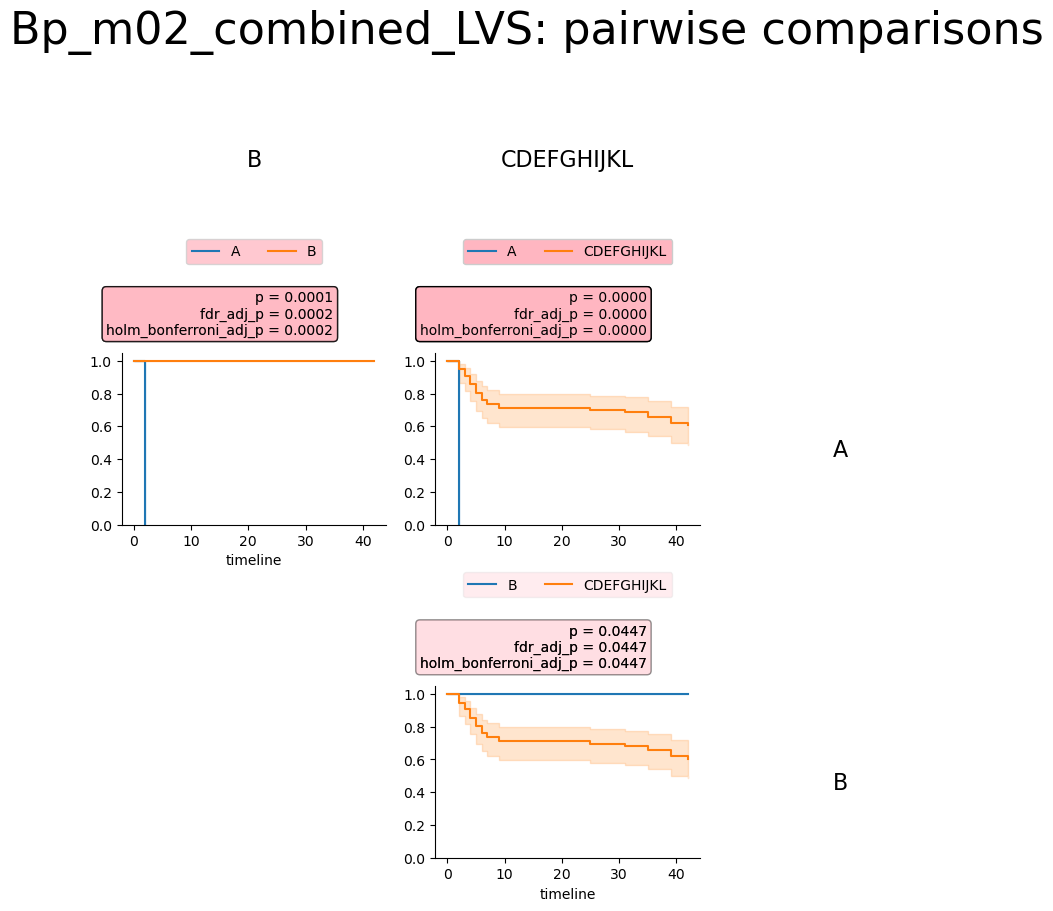

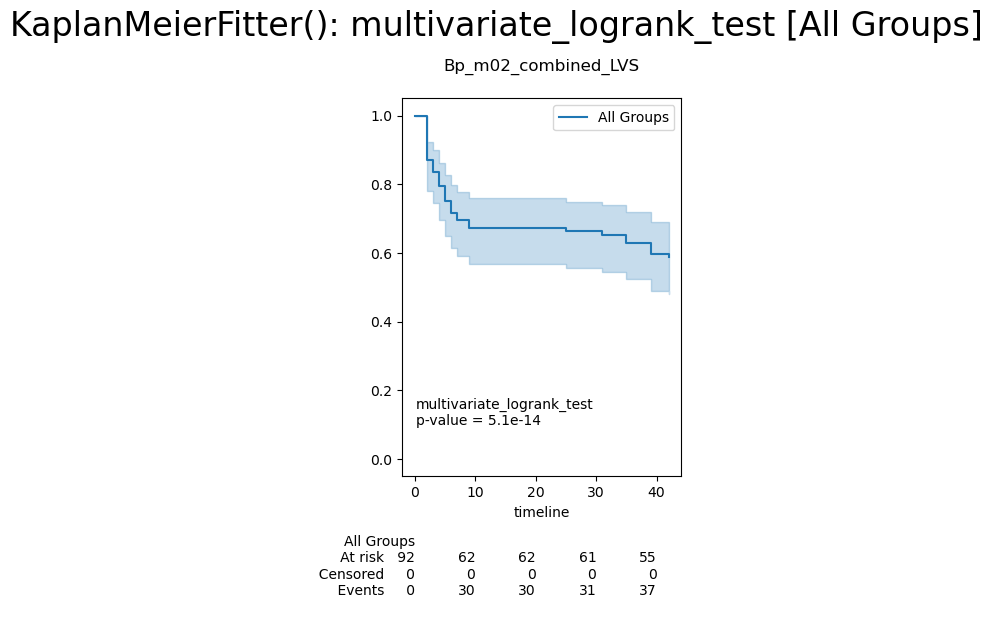

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           108 non-null    object
 1   Group_Name                      108 non-null    object
 2   Mouse                           108 non-null    object
 3   Day                             108 non-null    int64 
 4   Death                           108 non-null    int64 
 5   Survival_with_sterile_immunity  108 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 25.7 KB


Group                                 Group_Name Mouse  Day  Death  \
0            A         Group A: PBS (ID x 3, 0.0e+00 CFU)    A1    3      1   
1            A         Group A: PBS (ID x 3, 0.0e+00 CFU)    A2    4      1   
2            A         Group A: PBS (ID x 3, 0.0e+00 CFU)    A3    4      1   
3            A         Group A: PBS (ID x 3, 0.0e+00 CFU)    A4    4      1   
4            A         Group A: PBS (ID x 3, 0.0e+00 CFU)    A5    4      1   
..         ...                                        ...   ...  ...    ...   
103  DEFHIJLMN  Groups DEFHIJLMN Combined LVS Groups (IN)    N4   42      0   
104  DEFHIJLMN  Groups DEFHIJLMN Combined LVS Groups (IN)    N5   42      0   
105  DEFHIJLMN  Groups DEFHIJLMN Combined LVS Groups (IN)    N6   42      0   
106  DEFHIJLMN  Groups DEFHIJLMN Combined LVS Groups (IN)    N7   42      0   
107  DEFHIJLMN  Groups DEFHIJLMN Combined LVS Groups (IN)    N8   33      1   

     Survival_with_sterile_immunity  
0                                 0  
1                                 0  
2                                 0  
3                                 0  
4                                 0  
..                              ...  
103                               0  
104                               0  
105                               0  
106                               0  
107                               0  

[108 rows x 6 columns]

Group                                 Group_Name Mouse  \
count         108                                        108   108   
unique          4                                          4   108   
top     DEFHIJLMN  Groups DEFHIJLMN Combined LVS Groups (IN)    A1   
freq           68                                         68     1   
mean          NaN                                        NaN   NaN   
std           NaN                                        NaN   NaN   
min           NaN                                        NaN   NaN   
25%           NaN                                        NaN   NaN   
50%           NaN                                        NaN   NaN   
75%           NaN                                        NaN   NaN   
max           NaN                                        NaN   NaN   

               Day       Death  Survival_with_sterile_immunity  
count   108.000000  108.000000                      108.000000  
unique         NaN         NaN                             NaN  
top            NaN         NaN                             NaN  
freq           NaN         NaN                             NaN  
mean     29.453704    0.435185                        0.120370  
std      17.025206    0.498093                        0.326911  
min       3.000000    0.000000                        0.000000  
25%       6.000000    0.000000                        0.000000  
50%      42.000000    0.000000                        0.000000  
75%      42.000000    1.000000                        0.000000  
max      42.000000    1.000000                        1.000000

Day
0     3
1     4
2     5
3     6
4    17
5    31
6    33
7    35
8    38
9    40
10   42

Group
0          A
1          B
2        CGK
3  DEFHIJLMN

Group_Name
0         Group A: PBS (ID x 3, 0.0e+00 CFU)
1        Group B: Bp82 (ID x 3, 1.0e+06 CFU)
2        Groups CGK Combined LVS Groups (ID)
3  Groups DEFHIJLMN Combined LVS Groups (IN)

Mouse
0      A1
1      A2
2      A3
3      A4
4      A5
..    ...
103    N4
104    N5
105    N6
106    N7
107    N8

[108 rows x 1 columns]

Death
0      0
1      1

Survival_with_sterile_immunity
0                               0
1                               1

Group_1    Group_2           pair  uncorrected_p_value  p_value_fdr_bh  \
index                                                                          
0           A          B            A-B         1.487435e-04    1.784923e-04   
1           A        CGK          A-CGK         1.398020e-05    2.796039e-05   
2           A  DEFHIJLMN    A-DEFHIJLMN         9.795983e-17    2.938795e-16   
3           B        CGK          B-CGK         1.813678e-03    1.813678e-03   
4           B  DEFHIJLMN    B-DEFHIJLMN         2.700975e-05    4.051463e-05   
5         CGK  DEFHIJLMN  CGK-DEFHIJLMN         1.369701e-19    8.218203e-19   

       p_value_holm_bonferroni  p_value_holm_sidak sig_uncorrected sig_fdr_bh  \
index                                                                           
0                 2.974871e-04        2.974650e-04             ***        ***   
1                 5.592079e-05        5.591962e-05            ****       ****   
2                 4.897992e-16        4.897992e-16            ****       ****   
3                 1.813678e-03        1.813678e-03              **         **   
4                 8.102926e-05        8.102708e-05            ****       ****   
5                 8.218203e-19        8.218203e-19            ****       ****   

      sig_holm_bonferroni sig_holm_sidak  
index                                     
0                     ***            ***  
1                    ****           ****  
2                    ****           ****  
3                      **             **  
4                    ****           ****  
5                    ****           ****

final_survival  upper_0.95  lower_0.95  median_survival_time
Group                                                                  
A                0.000000    0.000000    0.000000                   4.0
B                0.250000    0.558084    0.037067                  40.0
CGK              0.041667    0.175933    0.002990                   5.0
DEFHIJLMN        0.852941    0.918026    0.743919                   inf

Group  Died  Survived  total_mice  Survival_with_sterile_immunity  \
0          A     8         0           8                               0   
1          B     6         2           8                               0   
2        CGK    23         1          24                               1   
3  DEFHIJLMN    10        58          68                              12   

   not_sterile  percent_survival  percent_sterile  
0            8          0.000000         0.000000  
1            8         25.000000         0.000000  
2           23          4.166667         4.166667  
3           56         85.294118        17.647059

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                                       
0                A-B                 1.985474e-01            2.382568e-01   
1              A-CGK                 9.983366e-01            9.983366e-01   
2        A-DEFHIJLMN                 4.547580e-07            1.364274e-06   
3              B-CGK                 8.975232e-02            1.346285e-01   
4        B-DEFHIJLMN                 3.909388e-04            7.818777e-04   
5      CGK-DEFHIJLMN                 1.315428e-13            7.892571e-13   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                         3.970947e-01                3.576737e-01   
1                         9.983366e-01                9.983366e-01   
2                         2.273790e-06                2.273788e-06   
3                         2.692570e-01                2.458135e-01   
4                         1.563755e-03                1.562839e-03   
5                         7.892571e-13                7.892571e-13   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                        ****               ****                        ****   
3                          ns                 ns                          ns   
4                         ***                ***                          **   
5                        ****               ****                        ****   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                       ****  
3                         ns  
4                         **  
5                       ****

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                                       
0                A-B                     1.000000                1.000000   
1              A-CGK                     0.998337                1.000000   
2        A-DEFHIJLMN                     0.227350                0.454699   
3              B-CGK                     0.998337                1.000000   
4        B-DEFHIJLMN                     0.227350                0.454699   
5      CGK-DEFHIJLMN                     0.109970                0.454699   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             1.000000                    1.000000   
1                             1.000000                    1.000000   
2                             1.000000                    0.724631   
3                             1.000000                    1.000000   
4                             1.000000                    0.724631   
5                             0.659819                    0.502918   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                          ns                 ns                          ns   
3                          ns                 ns                          ns   
4                          ns                 ns                          ns   
5                          ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns  
3                         ns  
4                         ns  
5                         ns

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         139.32 <0.005     97.25

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
               test_statistic      p  -log2(p)
A   B                   14.39 <0.005     12.71
    CGK                 18.87 <0.005     16.13
    DEFHIJLMN           69.01 <0.005     53.18
B   CGK                  9.73 <0.005      9.11
    DEFHIJLMN           17.62 <0.005     15.18
CGK DEFHIJLMN           81.99 <0.005     62.66

{'A': <lifelines.KaplanMeierFitter:"A", fitted with 8 total observations, 0 right-censored observations>,
 'B': <lifelines.KaplanMeierFitter:"B", fitted with 8 total observations, 2 right-censored observations>,
 'CGK': <lifelines.KaplanMeierFitter:"CGK", fitted with 24 total observations, 1 right-censored observations>,
 'DEFHIJLMN': <lifelines.KaplanMeierFitter:"DEFHIJLMN", fitted with 68 total observations, 58 right-censored observations>}

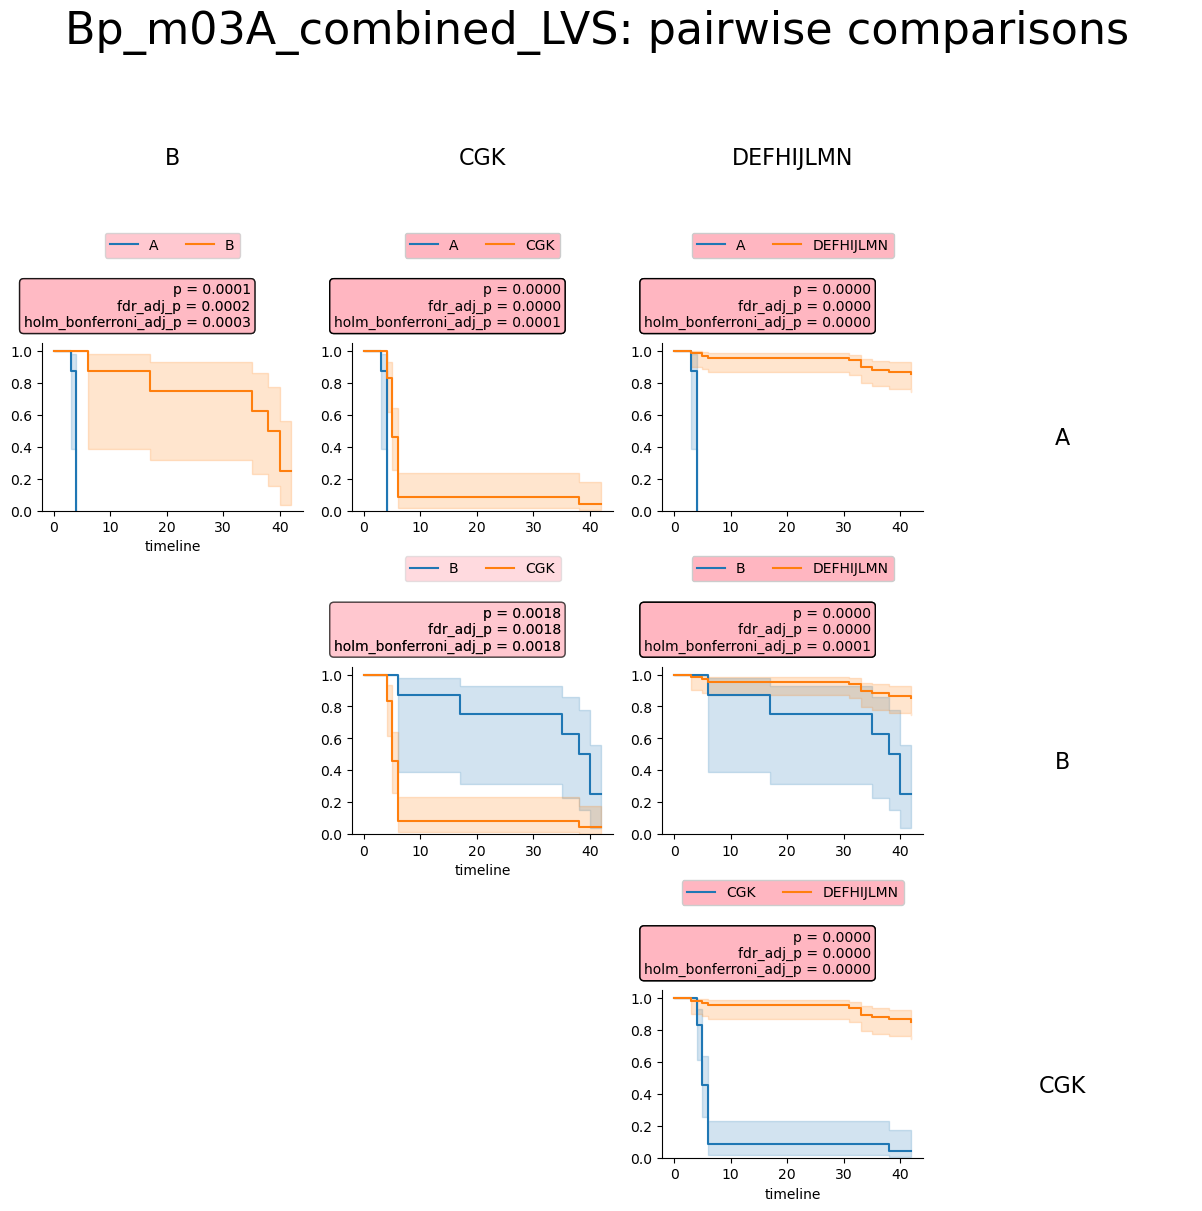

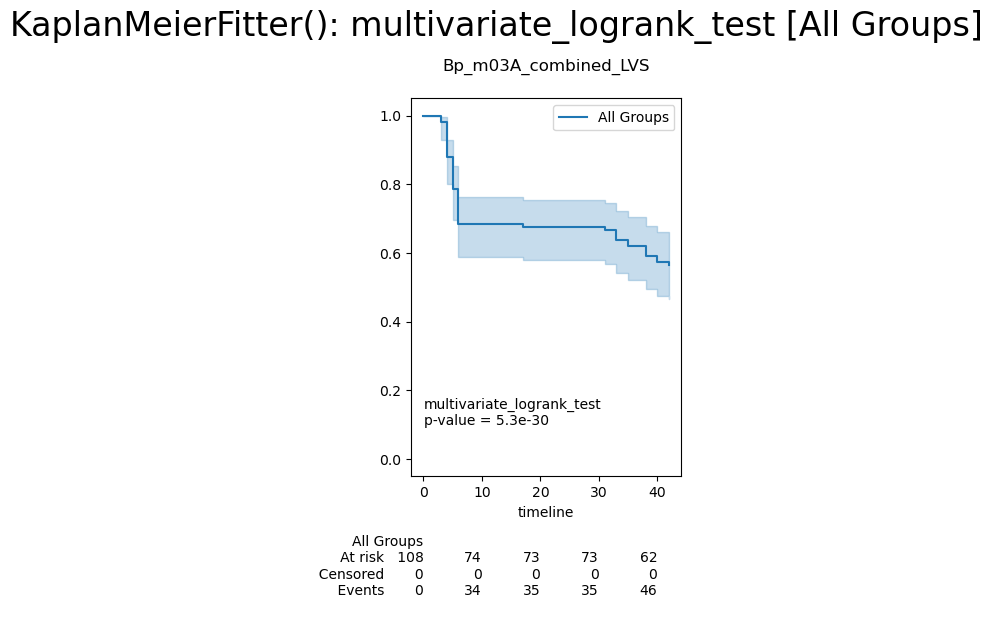

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           60 non-null     object
 1   Group_Name                      60 non-null     object
 2   Mouse                           60 non-null     object
 3   Day                             60 non-null     int64 
 4   Death                           60 non-null     int64 
 5   Survival_with_sterile_immunity  60 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 13.9 KB


Group                           Group_Name Mouse  Day  Death  \
0      O   Group O: PBS (ID x 3, 0.0e+00 CFU)    O1    5      1   
1      O   Group O: PBS (ID x 3, 0.0e+00 CFU)    O2    6      1   
2      O   Group O: PBS (ID x 3, 0.0e+00 CFU)    O3    4      1   
3      O   Group O: PBS (ID x 3, 0.0e+00 CFU)    O5    5      1   
4      O   Group O: PBS (ID x 3, 0.0e+00 CFU)    O6    4      1   
5      O   Group O: PBS (ID x 3, 0.0e+00 CFU)    O7    5      1   
6      O   Group O: PBS (ID x 3, 0.0e+00 CFU)    O8    5      1   
7      P  Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P1   38      1   
8      P  Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P2   42      0   
9      P  Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P3   24      1   
10     P  Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P4   38      1   
11     P  Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P5   42      0   
12     P  Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P6   38      1   
13     P  Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P7   42      0   
14     P  Group P: Bp82 (ID x 3, 1.0e+06 CFU)    P8   31      1   
15   QSU  Groups QSU Combined LVS Groups (ID)    Q1   42      0   
16   QSU  Groups QSU Combined LVS Groups (ID)    Q2   42      0   
17   QSU  Groups QSU Combined LVS Groups (ID)    Q3   42      0   
18   QSU  Groups QSU Combined LVS Groups (ID)    Q4    6      1   
19   QSU  Groups QSU Combined LVS Groups (ID)    Q5   42      0   
20   QSU  Groups QSU Combined LVS Groups (ID)    Q6    6      1   
21   QSU  Groups QSU Combined LVS Groups (ID)    Q7    4      1   
22   QSU  Groups QSU Combined LVS Groups (ID)    Q8   42      0   
23   RTV  Groups RTV Combined LVS Groups (IN)    R1   42      0   
24   RTV  Groups RTV Combined LVS Groups (IN)    R2   42      0   
25   RTV  Groups RTV Combined LVS Groups (IN)    R3   42      0   
26   RTV  Groups RTV Combined LVS Groups (IN)    R6   42      0   
27   RTV  Groups RTV Combined LVS Groups (IN)    R7   42      0   
28   RTV  Groups RTV Combined LVS Groups (IN)    R8   42      0   
29   QSU  Groups QSU Combined LVS Groups (ID)    S2   42      0   
30   QSU  Groups QSU Combined LVS Groups (ID)    S3    5      1   
31   QSU  Groups QSU Combined LVS Groups (ID)    S4    5      1   
32   QSU  Groups QSU Combined LVS Groups (ID)    S5    5      1   
33   QSU  Groups QSU Combined LVS Groups (ID)    S6   42      0   
34   QSU  Groups QSU Combined LVS Groups (ID)    S7   42      0   
35   QSU  Groups QSU Combined LVS Groups (ID)    S8   42      0   
36   RTV  Groups RTV Combined LVS Groups (IN)    T1   42      0   
37   RTV  Groups RTV Combined LVS Groups (IN)    T2   42      0   
38   RTV  Groups RTV Combined LVS Groups (IN)    T3   42      0   
39   RTV  Groups RTV Combined LVS Groups (IN)    T4    5      1   
40   RTV  Groups RTV Combined LVS Groups (IN)    T5   31      1   
41   RTV  Groups RTV Combined LVS Groups (IN)    T6   42      0   
42   RTV  Groups RTV Combined LVS Groups (IN)    T7   31      1   
43   RTV  Groups RTV Combined LVS Groups (IN)    T8   24      1   
44   QSU  Groups QSU Combined LVS Groups (ID)    U1   42      0   
45   QSU  Groups QSU Combined LVS Groups (ID)    U2    5      1   
46   QSU  Groups QSU Combined LVS Groups (ID)    U3   42      0   
47   QSU  Groups QSU Combined LVS Groups (ID)    U4    5      1   
48   QSU  Groups QSU Combined LVS Groups (ID)    U5    5      1   
49   QSU  Groups QSU Combined LVS Groups (ID)    U6    4      1   
50   QSU  Groups QSU Combined LVS Groups (ID)    U7    6      1   
51   QSU  Groups QSU Combined LVS Groups (ID)    U8    5      1   
52   RTV  Groups RTV Combined LVS Groups (IN)    V1   42      0   
53   RTV  Groups RTV Combined LVS Groups (IN)    V2    6      1   
54   RTV  Groups RTV Combined LVS Groups (IN)    V3    6      1   
55   RTV  Groups RTV Combined LVS Groups (IN)    V4   42      0   
56   RTV  Groups RTV Combined LVS Groups (IN)    V5   42      0   
57   RTV  Groups RTV Combined LVS Groups (IN)    V6   42      0   
58   RTV  Groups RTV Combined LVS Groups (IN)    V

Group                           Group_Name Mouse        Day      Death  \
count     60                                   60    60  60.000000  60.000000   
unique     4                                    4    60        NaN        NaN   
top      QSU  Groups QSU Combined LVS Groups (ID)    O1        NaN        NaN   
freq      23                                   23     1        NaN        NaN   
mean     NaN                                  NaN   NaN  27.116667   0.500000   
std      NaN                                  NaN   NaN  17.344067   0.504219   
min      NaN                                  NaN   NaN   4.000000   0.000000   
25%      NaN                                  NaN   NaN   5.000000   0.000000   
50%      NaN                                  NaN   NaN  40.000000   0.500000   
75%      NaN                                  NaN   NaN  42.000000   1.000000   
max      NaN                                  NaN   NaN  42.000000   1.000000   

        Survival_with_sterile_immunity  
count                        60.000000  
unique                             NaN  
top                                NaN  
freq                               NaN  
mean                          0.366667  
std                           0.485961  
min                           0.000000  
25%                           0.000000  
50%                           0.000000  
75%                           1.000000  
max                           1.000000

Day
0    4
1    5
2    6
3   24
4   31
5   38
6   42

Group
0     O
1     P
2   QSU
3   RTV

Group_Name
0   Group O: PBS (ID x 3, 0.0e+00 CFU)
1  Group P: Bp82 (ID x 3, 1.0e+06 CFU)
2  Groups QSU Combined LVS Groups (ID)
3  Groups RTV Combined LVS Groups (IN)

Mouse
0     O1
1     O2
2     O3
3     O5
4     O6
5     O7
6     O8
7     P1
8     P2
9     P3
10    P4
11    P5
12    P6
13    P7
14    P8
15    Q1
16    Q2
17    Q3
18    Q4
19    Q5
20    Q6
21    Q7
22    Q8
23    R1
24    R2
25    R3
26    R6
27    R7
28    R8
29    S2
30    S3
31    S4
32    S5
33    S6
34    S7
35    S8
36    T1
37    T2
38    T3
39    T4
40    T5
41    T6
42    T7
43    T8
44    U1
45    U2
46    U3
47    U4
48    U5
49    U6
50    U7
51    U8
52    V1
53    V2
54    V3
55    V4
56    V5
57    V6
58    V7
59    V8

Death
0      0
1      1

Survival_with_sterile_immunity
0                               0
1                               1

Group_1 Group_2     pair  uncorrected_p_value  p_value_fdr_bh  \
index                                                                 
0           O       P      O-P         8.931532e-05        0.000268   
1           O     QSU    O-QSU         6.932518e-03        0.013865   
2           O     RTV    O-RTV         2.228066e-07        0.000001   
3           P     QSU    P-QSU         8.194753e-01        0.819475   
4           P     RTV    P-RTV         1.800667e-01        0.216080   
5         QSU     RTV  QSU-RTV         4.570812e-02        0.068562   

       p_value_holm_bonferroni  p_value_holm_sidak sig_uncorrected sig_fdr_bh  \
index                                                                           
0                     0.000447            0.000446            ****        ***   
1                     0.027730            0.027443              **          *   
2                     0.000001            0.000001            ****       ****   
3                     0.819475            0.819475              ns         ns   
4                     0.360133            0.327709              ns         ns   
5                     0.137124            0.130952               *         ns   

      sig_holm_bonferroni sig_holm_sidak  
index                                     
0                     ***            ***  
1                       *              *  
2                    ****           ****  
3                      ns             ns  
4                      ns             ns  
5                      ns             ns

final_survival  upper_0.95  lower_0.95  median_survival_time
Group                                                              
O            0.000000    0.000000    0.000000                   5.0
P            0.375000    0.674363    0.087006                  38.0
QSU          0.478261    0.661322    0.268293                   6.0
RTV          0.727273    0.867114    0.491033                   inf

Group  Died  Survived  total_mice  Survival_with_sterile_immunity  \
0     O     7         0           7                               0   
1     P     5         3           8                               0   
2   QSU    12        11          23                               9   
3   RTV     6        16          22                              13   

   not_sterile  percent_survival  percent_sterile  
0            7          0.000000         0.000000  
1            8         37.500000         0.000000  
2           14         47.826087        39.130435  
3            9         72.727273        59.090909

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                                 
0          O-P                     0.088596                0.126850   
1        O-QSU                     0.024321                0.072963   
2        O-RTV                     0.000580                0.003478   
3        P-QSU                     0.641897                0.641897   
4        P-RTV                     0.086771                0.126850   
5      QSU-RTV                     0.105709                0.126850   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.347083                    0.304465   
1                             0.121606                    0.115833   
2                             0.003478                    0.003473   
3                             0.641897                    0.641897   
4                             0.347083                    0.304465   
5                             0.347083                    0.304465   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                           *                 ns                          ns   
2                         ***                 **                          **   
3                          ns                 ns                          ns   
4                          ns                 ns                          ns   
5                          ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         **  
3                         ns  
4                         ns  
5                         ns

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                                 
0          O-P                     1.000000                1.000000   
1        O-QSU                     0.055533                0.083299   
2        O-RTV                     0.008201                0.024603   
3        P-QSU                     0.038262                0.076524   
4        P-RTV                     0.004082                0.024491   
5      QSU-RTV                     0.233299                0.279959   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             1.000000                    1.000000   
1                             0.166598                    0.157518   
2                             0.041004                    0.040337   
3                             0.153048                    0.144486   
4                             0.024491                    0.024242   
5                             0.466599                    0.412170   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                          **                  *                           *   
3                           *                 ns                          ns   
4                          **                  *                           *   
5                          ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                          *  
3                         ns  
4                          *  
5                         ns

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          25.70 <0.005     16.47

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
         test_statistic      p  -log2(p)
O   P             15.35 <0.005     13.45
    QSU            7.29   0.01      7.17
    RTV           26.82 <0.005     22.10
P   QSU            0.05   0.82      0.29
    RTV            1.80   0.18      2.47
QSU RTV            3.99   0.05      4.45

{'O': <lifelines.KaplanMeierFitter:"O", fitted with 7 total observations, 0 right-censored observations>,
 'P': <lifelines.KaplanMeierFitter:"P", fitted with 8 total observations, 3 right-censored observations>,
 'QSU': <lifelines.KaplanMeierFitter:"QSU", fitted with 23 total observations, 11 right-censored observations>,
 'RTV': <lifelines.KaplanMeierFitter:"RTV", fitted with 22 total observations, 16 right-censored observations>}

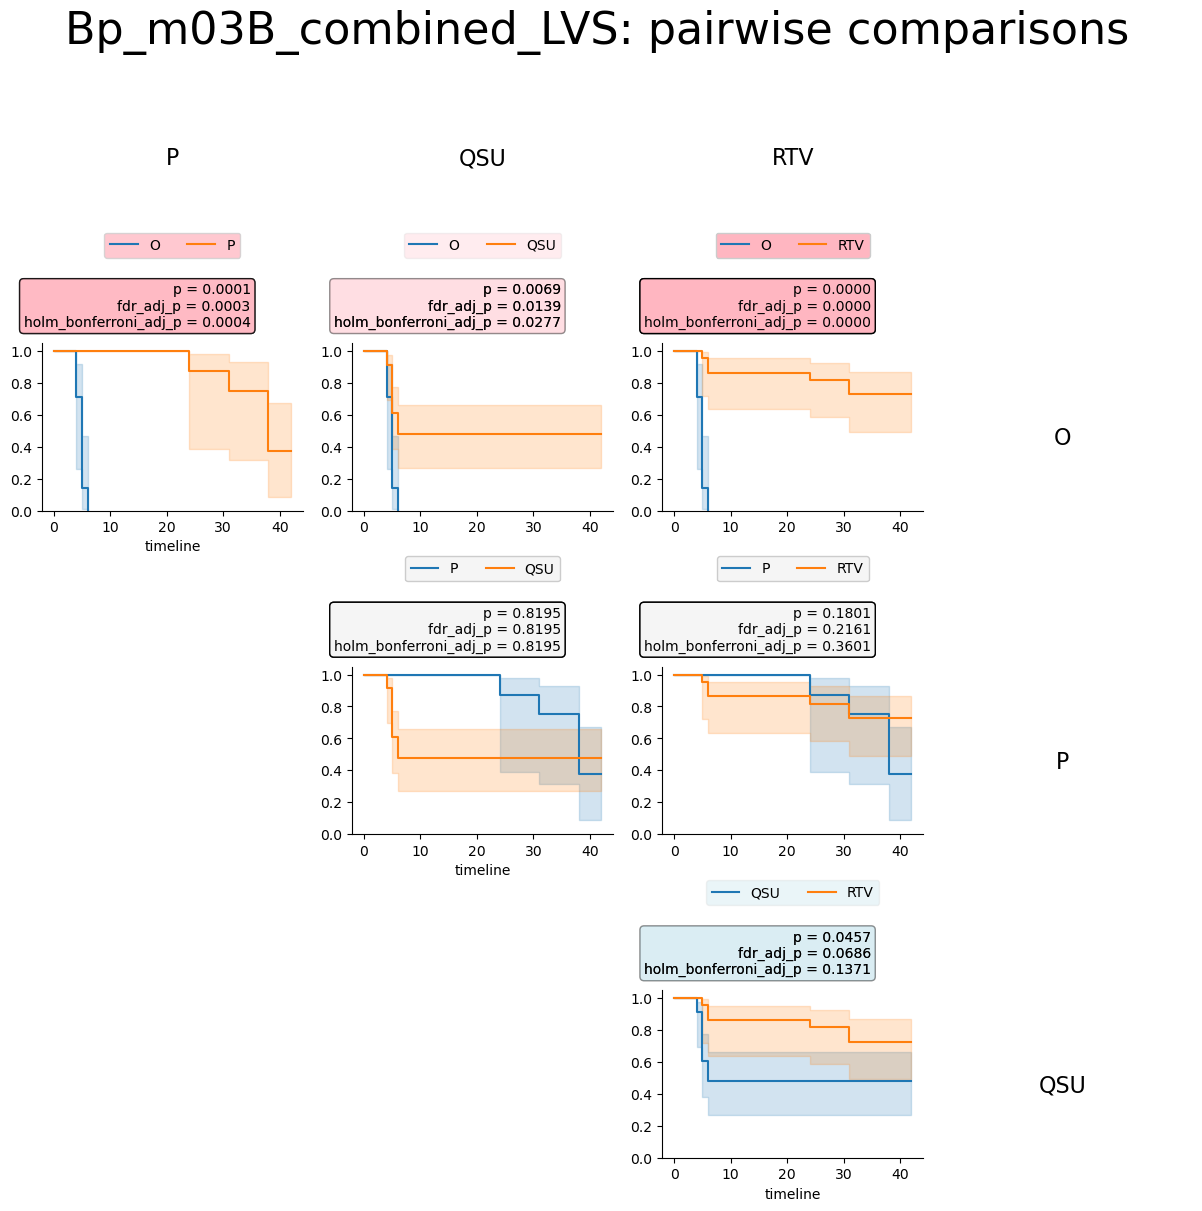

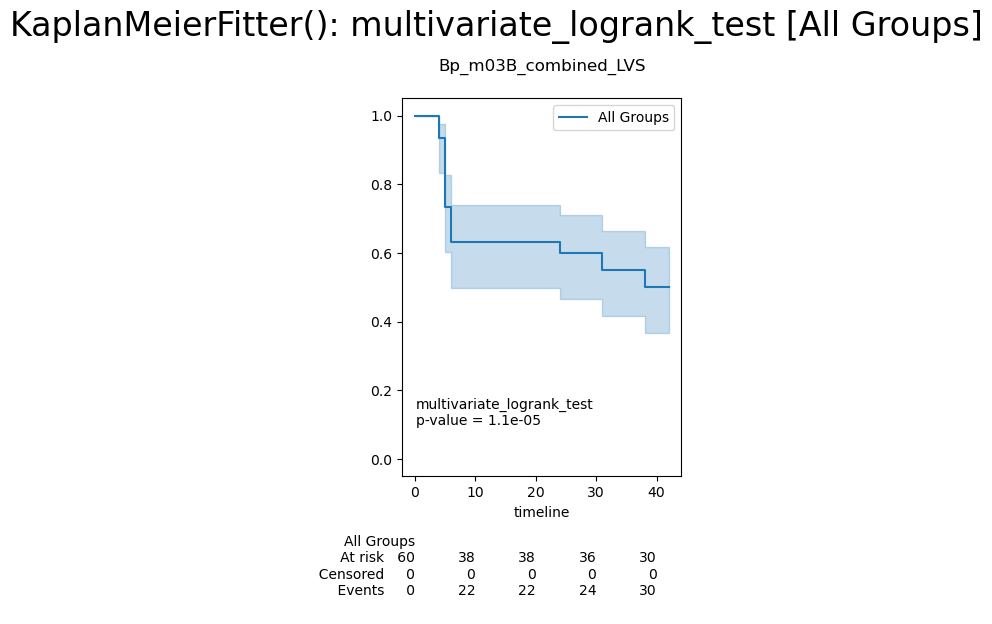

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           64 non-null     object
 1   Group_Name                      64 non-null     object
 2   Mouse                           64 non-null     object
 3   Day                             64 non-null     int64 
 4   Death                           64 non-null     int64 
 5   Survival_with_sterile_immunity  64 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 15.2 KB


Group                                         Group_Name Mouse  Day  Death  \
0      A  Group A: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1520 ...    A1    6      1   
1      A  Group A: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1520 ...    A2    6      1   
2      A  Group A: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1520 ...    A3   35      1   
3      A  Group A: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1520 ...    A4    4      1   
4      A  Group A: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1520 ...    A5    4      1   
..   ...                                                ...   ...  ...    ...   
59    CD                 Groups CD Combined LVS Groups (ID)   D12   42      0   
60    CD                 Groups CD Combined LVS Groups (ID)   D13   35      1   
61    CD                 Groups CD Combined LVS Groups (ID)   D14   35      1   
62    CD                 Groups CD Combined LVS Groups (ID)   D15   17      1   
63    CD                 Groups CD Combined LVS Groups (ID)   D16   42      0   

    Survival_with_sterile_immunity  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0  
..                             ...  
59                               1  
60                               0  
61                               0  
62                               0  
63                               1  

[64 rows x 6 columns]

Group                          Group_Name Mouse        Day      Death  \
count     64                                  64    64  64.000000  64.000000   
unique     3                                   3    64        NaN        NaN   
top       CD  Groups CD Combined LVS Groups (ID)    A1        NaN        NaN   
freq      32                                  32     1        NaN        NaN   
mean     NaN                                 NaN   NaN  28.703125   0.484375   
std      NaN                                 NaN   NaN  16.342252   0.503706   
min      NaN                                 NaN   NaN   3.000000   0.000000   
25%      NaN                                 NaN   NaN   9.250000   0.000000   
50%      NaN                                 NaN   NaN  42.000000   0.000000   
75%      NaN                                 NaN   NaN  42.000000   1.000000   
max      NaN                                 NaN   NaN  42.000000   1.000000   

        Survival_with_sterile_immunity  
count                        64.000000  
unique                             NaN  
top                                NaN  
freq                               NaN  
mean                          0.296875  
std                           0.460493  
min                           0.000000  
25%                           0.000000  
50%                           0.000000  
75%                           1.000000  
max                           1.000000

Day
0     3
1     4
2     5
3     6
4     7
5    10
6    14
7    17
8    21
9    28
10   35
11   42

Group
0     A
1     B
2    CD

Group_Name
0  Group A: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1520 ...
1  Group B: Bp82 (ID x 3, 1.0e+06 CFU) [Bp = 1520...
2                 Groups CD Combined LVS Groups (ID)

Mouse
0     A1
1    A10
2    A11
3    A12
4    A13
..   ...
59    D5
60    D6
61    D7
62    D8
63    D9

[64 rows x 1 columns]

Death
0      0
1      1

Survival_with_sterile_immunity
0                               0
1                               1

Group_1 Group_2  pair  uncorrected_p_value  p_value_fdr_bh  \
index                                                              
0           A       B   A-B             0.038521        0.057782   
1           A      CD  A-CD             0.012700        0.038101   
2           B      CD  B-CD             0.770202        0.770202   

       p_value_holm_bonferroni  p_value_holm_sidak sig_uncorrected sig_fdr_bh  \
index                                                                           
0                     0.077043            0.075559               *         ns   
1                     0.038101            0.037619               *          *   
2                     0.770202            0.770202              ns         ns   

      sig_holm_bonferroni sig_holm_sidak  
index                                     
0                      ns             ns  
1                       *              *  
2                      ns             ns

final_survival  upper_0.95  lower_0.95  median_survival_time
Group                                                              
A             0.31250    0.536497    0.113871                   6.0
B             0.56250    0.762239    0.295427                   inf
CD            0.59375    0.740203    0.405217                   inf

Group  Died  Survived  total_mice  Survival_with_sterile_immunity  \
0     A    11         5          16                               3   
1     B     7         9          16                               2   
2    CD    13        19          32                              14   

   not_sterile  percent_survival  percent_sterile  
0           13            31.250            18.75  
1           14            56.250            12.50  
2           18            59.375            43.75

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                              
0       A-B                     0.172092                0.258138   
1      A-CD                     0.076464                0.229391   
2      B-CD                     0.912213                0.912213   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.344184                    0.314568   
1                             0.229391                    0.212298   
2                             0.912213                    0.912213   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                          ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                              
0       A-B                     0.776826                0.776826   
1      A-CD                     0.111977                0.167966   
2      B-CD                     0.031556                0.094667   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.776826                    0.776826   
1                             0.223954                    0.211415   
2                             0.094667                    0.091711   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                           *                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           7.92 0.02      5.71

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
      test_statistic    p  -log2(p)
A B             4.28 0.04      4.70
  CD            6.21 0.01      6.30
B CD            0.09 0.77      0.38

{'A': <lifelines.KaplanMeierFitter:"A", fitted with 16 total observations, 5 right-censored observations>,
 'B': <lifelines.KaplanMeierFitter:"B", fitted with 16 total observations, 9 right-censored observations>,
 'CD': <lifelines.KaplanMeierFitter:"CD", fitted with 32 total observations, 19 right-censored observations>}

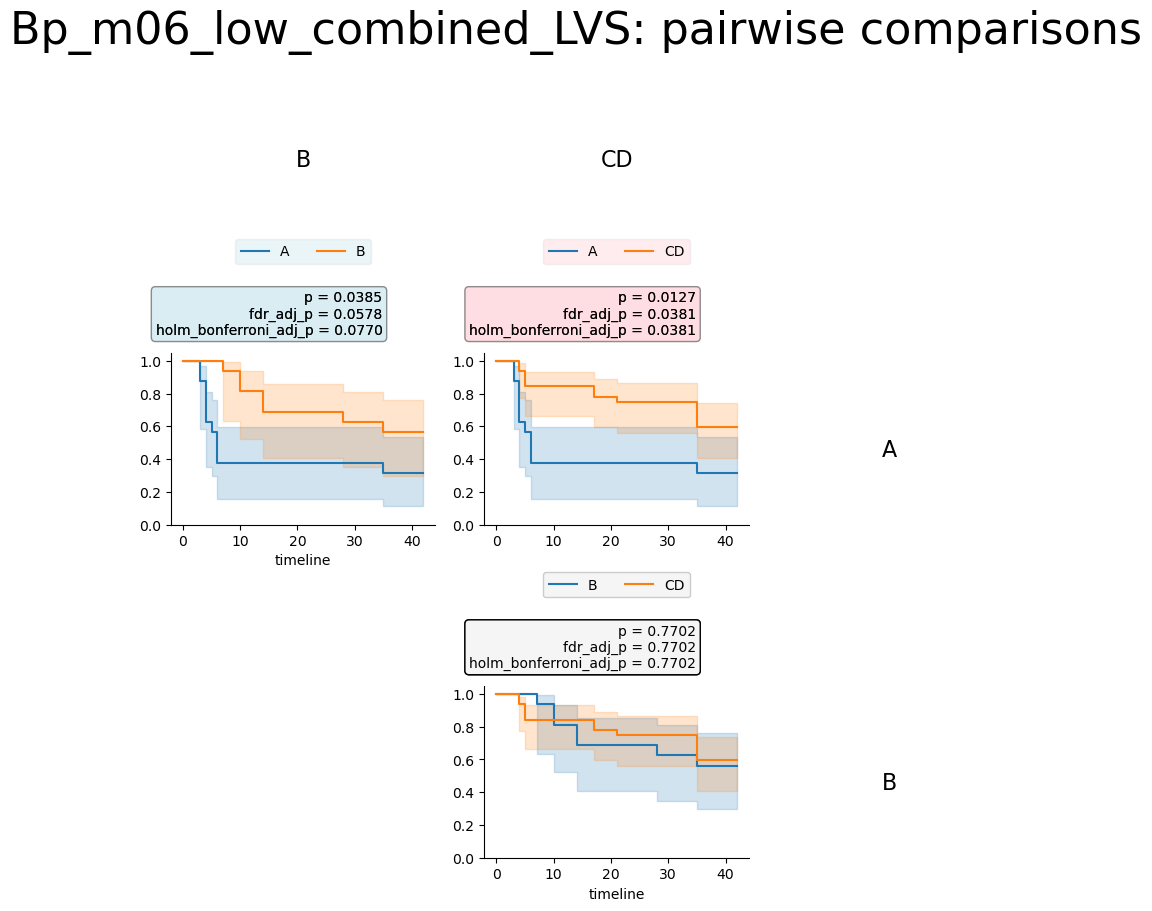

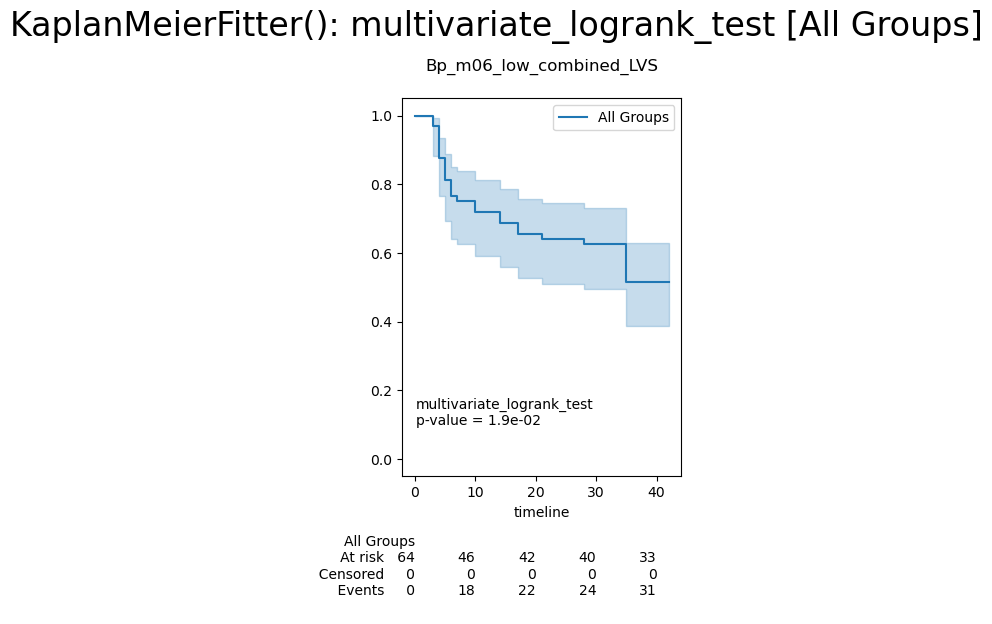

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           62 non-null     object
 1   Group_Name                      62 non-null     object
 2   Mouse                           62 non-null     object
 3   Day                             62 non-null     int64 
 4   Death                           62 non-null     int64 
 5   Survival_with_sterile_immunity  62 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 14.7 KB


Group                                         Group_Name Mouse  Day  Death  \
0      E  Group E: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1890 ...    E1    4      1   
1      E  Group E: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1890 ...    E2    4      1   
2      E  Group E: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1890 ...    E3    3      1   
3      E  Group E: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1890 ...    E4   17      1   
4      E  Group E: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1890 ...    E5    4      1   
..   ...                                                ...   ...  ...    ...   
57    GH                 Groups GH Combined LVS Groups (ID)   H12    4      1   
58    GH                 Groups GH Combined LVS Groups (ID)   H13    4      1   
59    GH                 Groups GH Combined LVS Groups (ID)   H14    5      1   
60    GH                 Groups GH Combined LVS Groups (ID)   H15    5      1   
61    GH                 Groups GH Combined LVS Groups (ID)   H16    4      1   

    Survival_with_sterile_immunity  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0  
..                             ...  
57                               0  
58                               0  
59                               0  
60                               0  
61                               0  

[62 rows x 6 columns]

Group                          Group_Name Mouse        Day      Death  \
count     62                                  62    62  62.000000  62.000000   
unique     3                                   3    62        NaN        NaN   
top       GH  Groups GH Combined LVS Groups (ID)    E1        NaN        NaN   
freq      31                                  31     1        NaN        NaN   
mean     NaN                                 NaN   NaN  15.500000   0.822581   
std      NaN                                 NaN   NaN  15.248488   0.385142   
min      NaN                                 NaN   NaN   3.000000   0.000000   
25%      NaN                                 NaN   NaN   4.000000   1.000000   
50%      NaN                                 NaN   NaN   5.500000   1.000000   
75%      NaN                                 NaN   NaN  28.000000   1.000000   
max      NaN                                 NaN   NaN  42.000000   1.000000   

        Survival_with_sterile_immunity  
count                        62.000000  
unique                             NaN  
top                                NaN  
freq                               NaN  
mean                          0.145161  
std                           0.355139  
min                           0.000000  
25%                           0.000000  
50%                           0.000000  
75%                           0.000000  
max                           1.000000

Day
0    3
1    4
2    5
3    6
4   10
5   17
6   21
7   28
8   35
9   42

Group
0     E
1     F
2    GH

Group_Name
0  Group E: PBS (ID x 3, 0.0e+00 CFU) [Bp = 1890 ...
1  Group F: Bp82 (ID x 3, 1.0e+06 CFU) [Bp = 1890...
2                 Groups GH Combined LVS Groups (ID)

Mouse
0     E1
1    E10
2    E11
3    E12
4    E13
..   ...
57    H5
58    H6
59    H7
60    H8
61    H9

[62 rows x 1 columns]

Death
0      0
1      1

Survival_with_sterile_immunity
0                               0
1                               1

Group_1 Group_2  pair  uncorrected_p_value  p_value_fdr_bh  \
index                                                              
0           E       F   E-F             0.000188        0.000563   
1           E      GH  E-GH             0.084743        0.084743   
2           F      GH  F-GH             0.007938        0.011906   

       p_value_holm_bonferroni  p_value_holm_sidak sig_uncorrected sig_fdr_bh  \
index                                                                           
0                     0.000563            0.000563             ***        ***   
1                     0.084743            0.084743              ns         ns   
2                     0.015875            0.015812              **          *   

      sig_holm_bonferroni sig_holm_sidak  
index                                     
0                     ***            ***  
1                      ns             ns  
2                       *              *

final_survival  upper_0.95  lower_0.95  median_survival_time
Group                                                              
E            0.062500    0.246994    0.004098                   4.0
F            0.333333    0.564000    0.121546                  35.0
GH           0.161290    0.308781    0.058843                   5.0

Group  Died  Survived  total_mice  Survival_with_sterile_immunity  \
0     E    15         1          16                               1   
1     F    10         5          15                               4   
2    GH    26         5          31                               4   

   not_sterile  percent_survival  percent_sterile  
0           15          6.250000         6.250000  
1           11         33.333333        26.666667  
2           27         16.129032        12.903226

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                              
0       E-F                     0.086897                0.260691   
1      E-GH                     0.399800                0.399800   
2      F-GH                     0.206345                0.309517   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.260691                    0.238694   
1                             0.412690                    0.399800   
2                             0.412690                    0.370112   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                          ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                              
0       E-F                     0.150153                0.426032   
1      E-GH                     0.663988                0.663988   
2      F-GH                     0.284021                0.426032   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.450459                    0.386207   
1                             0.663988                    0.663988   
2                             0.568042                    0.487374   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                          ns                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          14.07 <0.005     10.15

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
      test_statistic      p  -log2(p)
E F            13.95 <0.005     12.38
  GH            2.97   0.08      3.56
F GH            7.05   0.01      6.98

{'E': <lifelines.KaplanMeierFitter:"E", fitted with 16 total observations, 1 right-censored observations>,
 'F': <lifelines.KaplanMeierFitter:"F", fitted with 15 total observations, 5 right-censored observations>,
 'GH': <lifelines.KaplanMeierFitter:"GH", fitted with 31 total observations, 5 right-censored observations>}

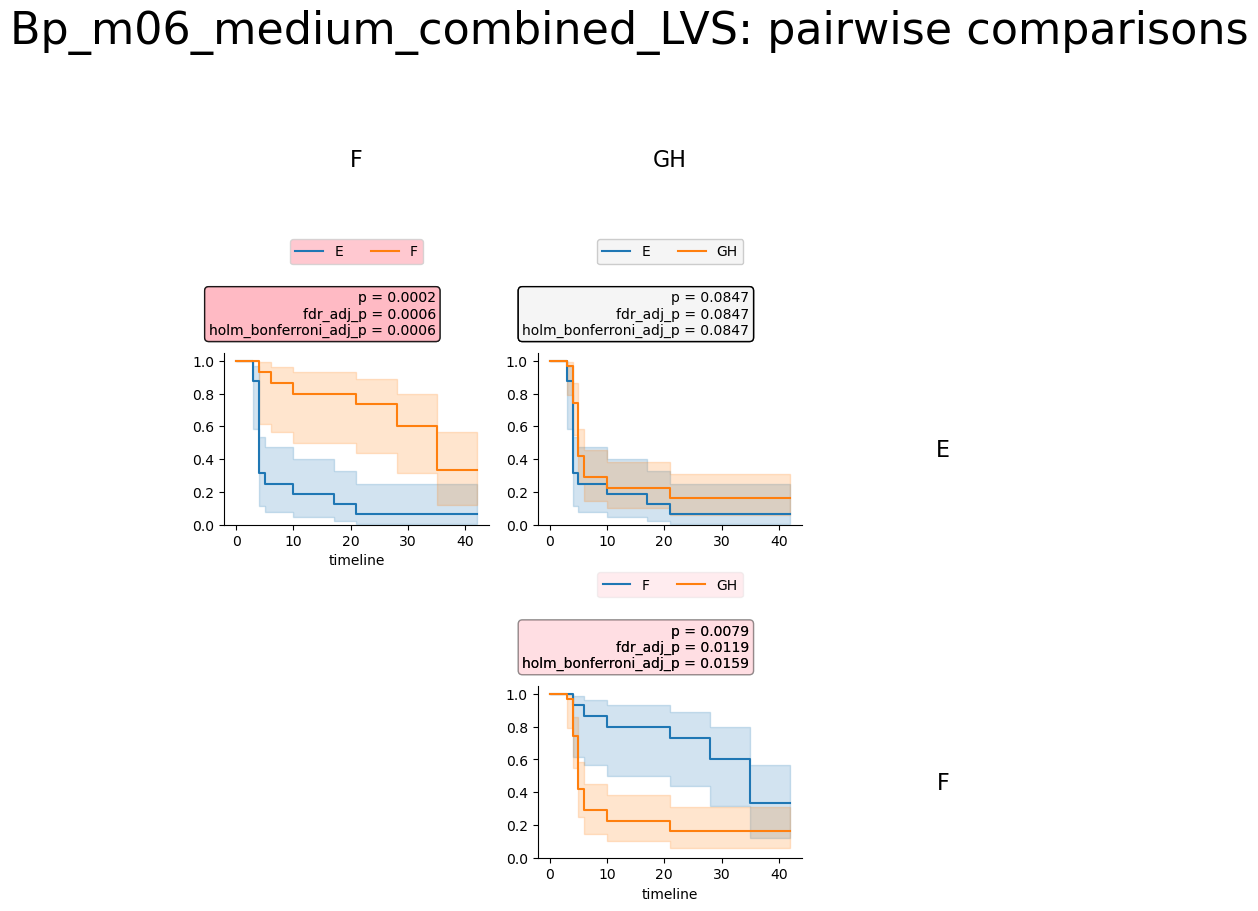

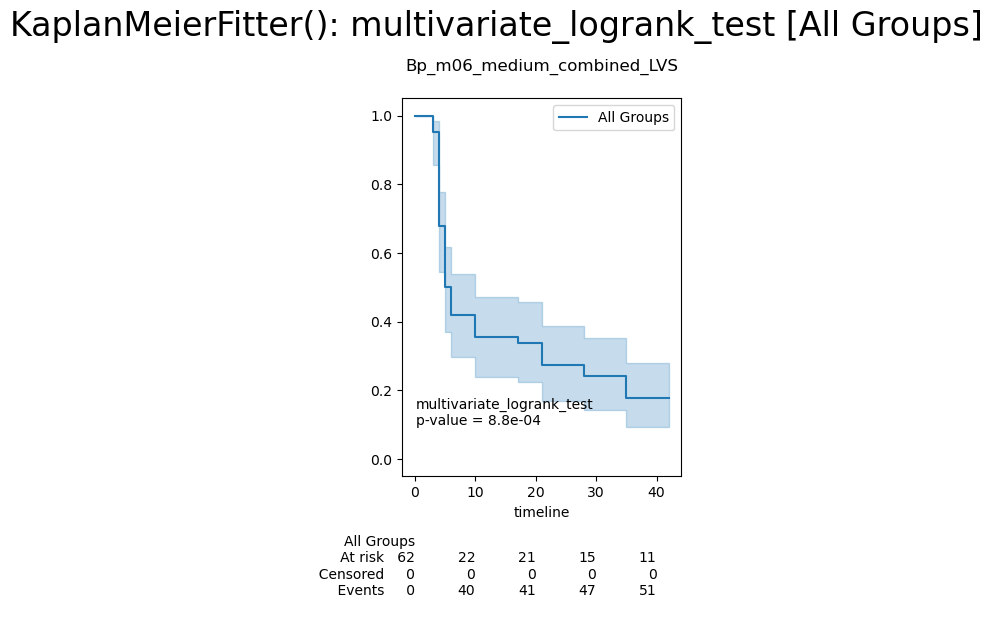

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           64 non-null     object
 1   Group_Name                      64 non-null     object
 2   Mouse                           64 non-null     object
 3   Day                             64 non-null     int64 
 4   Death                           64 non-null     int64 
 5   Survival_with_sterile_immunity  64 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 15.2 KB


Group                                         Group_Name Mouse  Day  Death  \
0      I  Group I: PBS (ID x 3, 0.0e+00 CFU) [Bp = 2290 ...    I1    3      1   
1      I  Group I: PBS (ID x 3, 0.0e+00 CFU) [Bp = 2290 ...    I2    3      1   
2      I  Group I: PBS (ID x 3, 0.0e+00 CFU) [Bp = 2290 ...    I3    3      1   
3      I  Group I: PBS (ID x 3, 0.0e+00 CFU) [Bp = 2290 ...    I4    3      1   
4      I  Group I: PBS (ID x 3, 0.0e+00 CFU) [Bp = 2290 ...    I5    4      1   
..   ...                                                ...   ...  ...    ...   
59    KL                 Groups KL Combined LVS Groups (ID)   L12   35      1   
60    KL                 Groups KL Combined LVS Groups (ID)   L13    7      1   
61    KL                 Groups KL Combined LVS Groups (ID)   L14    3      1   
62    KL                 Groups KL Combined LVS Groups (ID)   L15    4      1   
63    KL                 Groups KL Combined LVS Groups (ID)   L16    4      1   

    Survival_with_sterile_immunity  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0  
..                             ...  
59                               0  
60                               0  
61                               0  
62                               0  
63                               0  

[64 rows x 6 columns]

Group                          Group_Name Mouse        Day      Death  \
count     64                                  64    64  64.000000  64.000000   
unique     3                                   3    64        NaN        NaN   
top       KL  Groups KL Combined LVS Groups (ID)    I1        NaN        NaN   
freq      32                                  32     1        NaN        NaN   
mean     NaN                                 NaN   NaN  10.640625   0.921875   
std      NaN                                 NaN   NaN  13.095943   0.270490   
min      NaN                                 NaN   NaN   2.000000   0.000000   
25%      NaN                                 NaN   NaN   3.000000   1.000000   
50%      NaN                                 NaN   NaN   4.000000   1.000000   
75%      NaN                                 NaN   NaN  14.000000   1.000000   
max      NaN                                 NaN   NaN  42.000000   1.000000   

        Survival_with_sterile_immunity  
count                        64.000000  
unique                             NaN  
top                                NaN  
freq                               NaN  
mean                          0.062500  
std                           0.243975  
min                           0.000000  
25%                           0.000000  
50%                           0.000000  
75%                           0.000000  
max                           1.000000

Day
0     2
1     3
2     4
3     5
4     6
5     7
6    14
7    21
8    28
9    35
10   42

Group
0     I
1     J
2    KL

Group_Name
0  Group I: PBS (ID x 3, 0.0e+00 CFU) [Bp = 2290 ...
1  Group J: Bp82 (ID x 3, 1.0e+06 CFU) [Bp = 2290...
2                 Groups KL Combined LVS Groups (ID)

Mouse
0     I1
1    I10
2    I11
3    I12
4    I13
..   ...
59    L5
60    L6
61    L7
62    L8
63    L9

[64 rows x 1 columns]

Death
0      0
1      1

Survival_with_sterile_immunity
0                               0
1                               1

Group_1 Group_2  pair  uncorrected_p_value  p_value_fdr_bh  \
index                                                              
0           I       J   I-J         9.551045e-09    2.865314e-08   
1           I      KL  I-KL         3.329192e-02    3.329192e-02   
2           J      KL  J-KL         4.727251e-07    7.090877e-07   

       p_value_holm_bonferroni  p_value_holm_sidak sig_uncorrected sig_fdr_bh  \
index                                                                           
0                 2.865314e-08        2.865314e-08            ****       ****   
1                 3.329192e-02        3.329192e-02               *          *   
2                 9.454502e-07        9.454500e-07            ****       ****   

      sig_holm_bonferroni sig_holm_sidak  
index                                     
0                    ****           ****  
1                       *              *  
2                    ****           ****

final_survival  upper_0.95  lower_0.95  median_survival_time
Group                                                              
I              0.0000    0.000000    0.000000                   3.0
J              0.3125    0.536497    0.113871                  28.0
KL             0.0000    0.000000    0.000000                   4.0

Group  Died  Survived  total_mice  Survival_with_sterile_immunity  \
0     I    16         0          16                               0   
1     J    11         5          16                               4   
2    KL    32         0          32                               0   

   not_sterile  percent_survival  percent_sterile  
0           16              0.00              0.0  
1           12             31.25             25.0  
2           32              0.00              0.0

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                              
0       I-J                     0.023469                0.035203   
1      I-KL                     1.000000                1.000000   
2      J-KL                     0.004164                0.012491   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.046938                    0.046387   
1                             1.000000                    1.000000   
2                             0.012491                    0.012439   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                           *                  *                           *   
1                          ns                 ns                          ns   
2                          **                  *                           *   

      sig_barnard_holm_sidak  
index                         
0                          *  
1                         ns  
2                          *

Pair  uncorrected_p_value_barnard  p_value_barnard_fdr_bh  \
index                                                              
0       I-J                     0.053357                0.080036   
1      I-KL                     1.000000                1.000000   
2      J-KL                     0.033709                0.080036   

       p_value_barnard_holm_bonferroni  p_value_barnard_holm_sidak  \
index                                                                
0                             0.106715                    0.103868   
1                             1.000000                    1.000000   
2                             0.101128                    0.097757   

      sig_barnard_uncorrected sig_barnard_fdr_bh sig_barnard_holm_bonferroni  \
index                                                                          
0                          ns                 ns                          ns   
1                          ns                 ns                          ns   
2                           *                 ns                          ns   

      sig_barnard_holm_sidak  
index                         
0                         ns  
1                         ns  
2                         ns

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          38.23 <0.005     27.58

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
      test_statistic      p  -log2(p)
I J            32.93 <0.005     26.64
  KL            4.53   0.03      4.91
J KL           25.37 <0.005     21.01

{'I': <lifelines.KaplanMeierFitter:"I", fitted with 16 total observations, 0 right-censored observations>,
 'J': <lifelines.KaplanMeierFitter:"J", fitted with 16 total observations, 5 right-censored observations>,
 'KL': <lifelines.KaplanMeierFitter:"KL", fitted with 32 total observations, 0 right-censored observations>}

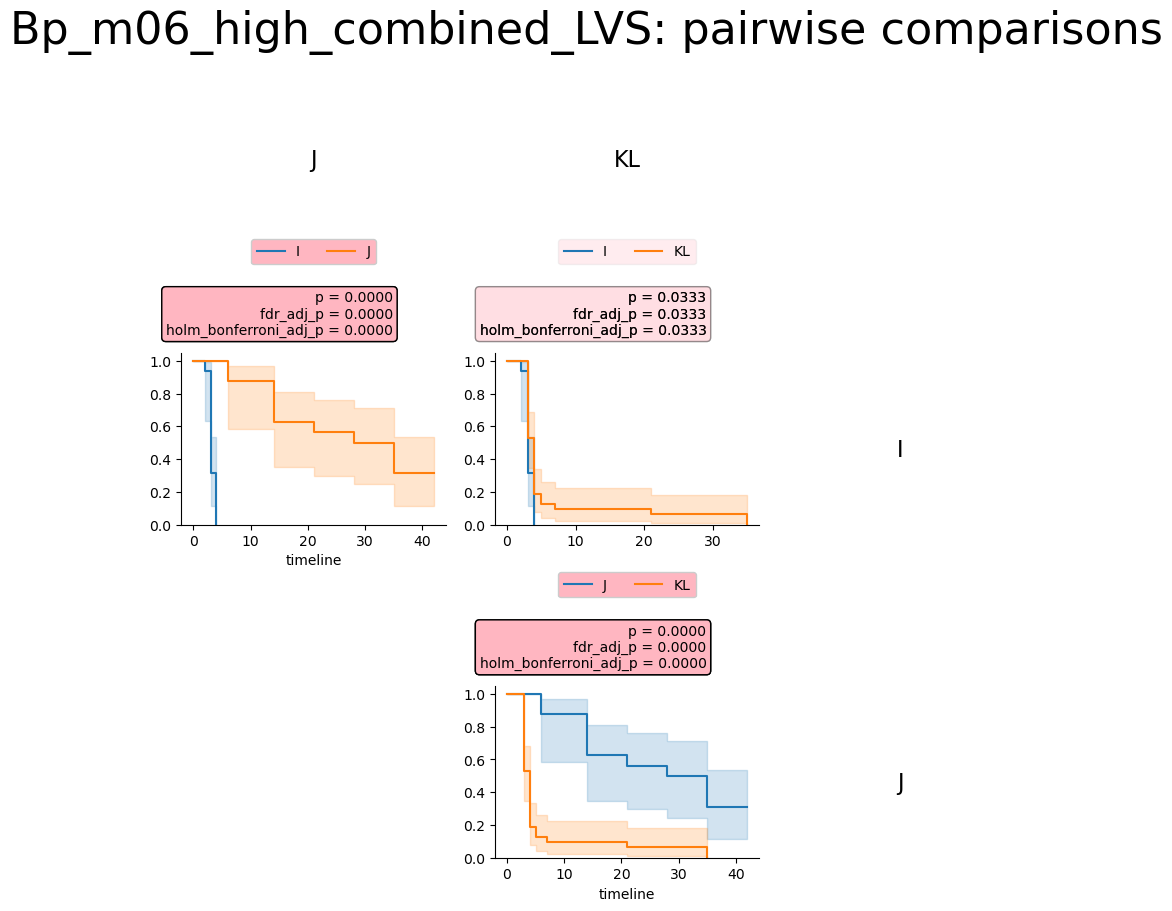

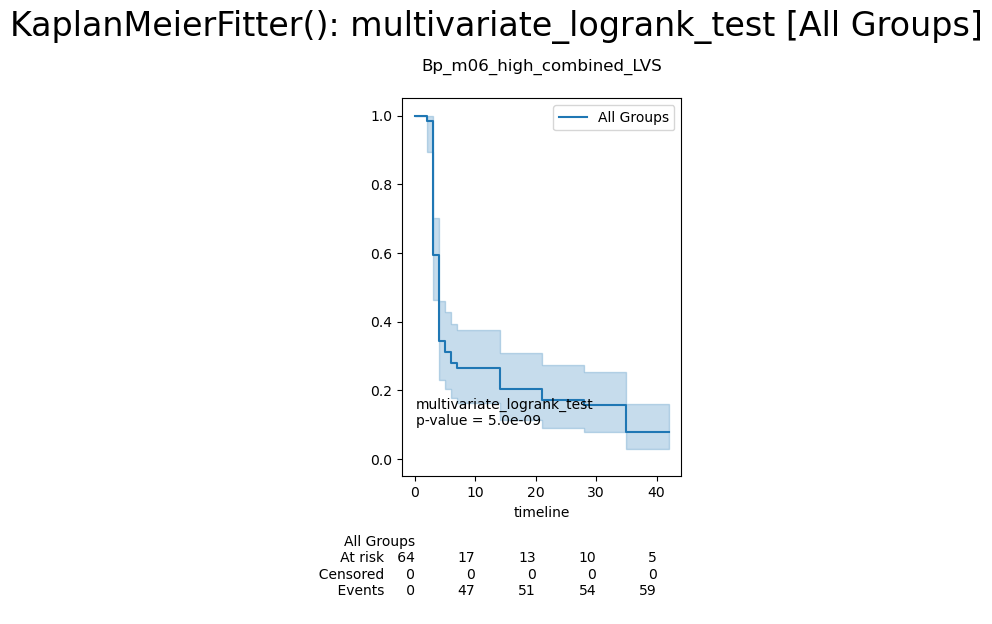

{'Bp_m01': <lifelines.KaplanMeierFitter:"All Groups", fitted with 96 total observations, 51 right-censored observations>,
 'Bp_m02': <lifelines.KaplanMeierFitter:"All Groups", fitted with 92 total observations, 54 right-censored observations>,
 'Bp_m03A': <lifelines.KaplanMeierFitter:"All Groups", fitted with 108 total observations, 61 right-censored observations>,
 'Bp_m03B': <lifelines.KaplanMeierFitter:"All Groups", fitted with 60 total observations, 30 right-censored observations>,
 'Bp_m06_low': <lifelines.KaplanMeierFitter:"All Groups", fitted with 64 total observations, 33 right-censored observations>,
 'Bp_m06_medium': <lifelines.KaplanMeierFitter:"All Groups", fitted with 62 total observations, 11 right-censored observations>,
 'Bp_m06_high': <lifelines.KaplanMeierFitter:"All Groups", fitted with 64 total observations, 5 right-censored observations>,
 'Bp_m09': <lifelines.KaplanMeierFitter:"All Groups", fitted with 64 total observations, 13 right-censored observations>,
 'Bp_m

In [7]:
all_raw_dataframes = {}
kmf_fit_all = {}
multivariate_logrank_test_results = {}
pairwise_logrank_test_results = {}
pairwise_comparisons = {}
mosaic_layouts = {}

if EXAMPLE:
    exp_items = [(ExperimentName.EXAMPLE, experiments[ExperimentName.EXAMPLE])]
else:
    exp_items = [item for item in experiments.items() if item[0].name != 'EXAMPLE']

for exp_name, exp in exp_items:
    
    output_pdf_files = [p_value_image_filename]
           
    output_file = f'{exp_name.name} survival {todays_date}.xlsx'
    save_dataframes = SaveDataFrames(output_path / output_file)
    
    display(HTML('<br><h1>________________________________________________________________________________</h1>'))
    display(HTML(f'<h1>{exp_name.name}</h1><br>'))
    display(HTML(f'<h3>{output_file=}</h3><br>'))
    
    # Read raw survival data and store in a dictionary accessible by experiment name.
    raw_data_df = pd.read_csv(pathlib.Path(exp.input_directory) / exp.input_file_name)
    
    if exp_name in LVS_groups_to_combine:
        # if this experiment has combined groups, process the raw_data_df to combine the groups.
        # The values of the 'Group' and 'Group_Name' columns will be the same after combining.
        
        combined_groups = LVS_groups_to_combine[exp_name]
    
        if combined_groups.groups_ID:
            mask = raw_data_df.Group.isin(combined_groups.groups_ID)
            raw_data_df.loc[mask, ['Group', 'Group_Name']] = combined_groups.combined_group_ID, combined_groups.groups_ID_name

        if combined_groups.groups_IN:
            mask = raw_data_df.Group.isin(combined_groups.groups_IN)
            raw_data_df.loc[mask, ['Group', 'Group_Name']] = combined_groups.combined_group_IN, combined_groups.groups_IN_name
    
    all_raw_dataframes[exp_name.name] = raw_data_df
    
    
    # Perform Kaplan Meier Survival Analysis using the lifelines package. Perform multivariate and pairwise logrank tests on the data.
    # Store the results in dictionaries accessible by experiment name.
    
    kmf_fit_all[exp_name.name] = KaplanMeierFitter().fit(raw_data_df["Day"], raw_data_df["Death"], label='All Groups')
    multivariate_logrank_test_results[exp_name.name] = multivariate_logrank_test(raw_data_df['Day'], raw_data_df['Group'], raw_data_df['Death'])
    pairwise_logrank_test_results[exp_name.name] = pairwise_logrank_test(raw_data_df['Day'], raw_data_df['Group'], raw_data_df['Death'])
    
    
    # Calculate all of the pairwise comparisons and the matplotlib mosaic layout for plotting the results.
    # Store the results in dictionaries accessible by experiment name.
    # Calculate statistics. Save DataFrames for writing to display in Notebook and for writing to Excel.
    # =====================================================================================================
    pairwise_comparisons[exp_name.name], mosaic_layouts[exp_name.name] = get_pairwise_comparisons_and_mosaic_layout(raw_data_df.Group.unique())
    
    save_dataframes.add_data_frame(raw_data_df, name='raw data')
    save_dataframes.add_data_frame(raw_data_df.describe(include='all'), name='Describe')
    
    for column in ['Day', 'Group', 'Group_Name', 'Mouse', 'Death', 'Survival_with_sterile_immunity']:
        series = raw_data_df[column]
        sheet_name = f'Unique Values for {column}'
        if len(sheet_name) > 31:
            #Excel sheet names need to be <= 31 characters
            sheet_name = f'{sheet_name[:28]}...'
        save_dataframes.add_data_frame(pd.DataFrame(np.sort(series.unique()), columns=[series.name]),name=sheet_name)
    
    uncorrected_p_values = pairwise_logrank_test_results[exp_name.name].p_value
    stats_df = create_stats_df(raw_data_df, uncorrected_p_values)
    corrected_stats_df = create_stats_df_with_corrected_p_values(stats_df)
    save_dataframes.add_data_frame(corrected_stats_df, name='p-values')
    
    kmf_fit = {group: kmf_fit_group(raw_data_df, group) for group in raw_data_df.Group.unique()}
    
    final_survival_df = pd.concat([get_stats_from_kmf(group, fit) for group, fit in kmf_fit.items()])
    save_dataframes.add_data_frame(final_survival_df, name='survival fraction')
    # =====================================================================================================
    
    
    # sterile immunity
    # =====================================================================================================
    results = create_proportion_and_stats_df(raw_data_df, pairwise_comparisons='all')

    proportion_df = results['Proportion']
    survival_stats_df = results['Survived']
    sterile_stats_df = results['Survival_with_sterile_immunity']

    save_dataframes.add_data_frame(proportion_df, name='proportion_df')
    save_dataframes.add_data_frame(survival_stats_df, name='survival_stats_df')
    save_dataframes.add_data_frame(sterile_stats_df, name='sterile_stats_df')
    # =====================================================================================================

    # Write all of the saved DataFrames to separate sheets in an Excel file
    save_dataframes.write()
    
    
    # Display results as HTML
    # =====================================================================================================
    display(HTML(f'<h1>{exp_name.name}: Info</h1><br>'))
    raw_data_df.info(verbose=True, memory_usage='deep', show_counts=True)
    display(HTML(f'<br>'))

    for name, df in save_dataframes.data_frames.items():
        display_df(df, f'{exp_name.name}: {name}')
        
    display(HTML(f'<h1>{exp_name.name}: multivariate_logrank_test_results</h1><br>'))
    multivariate_logrank_test_results[exp_name.name].print_summary()
    
    display(HTML(f'<h1>{exp_name.name}: pairwise_logrank_test_results</h1><br>'))
    pairwise_logrank_test_results[exp_name.name].print_summary()
    
    display(HTML('<h1>kmf_fit</h1><br>'))
    display(kmf_fit)
    display(HTML('<br><br>'))
    # =====================================================================================================
      
    
    # Create matplotlib plot showing pairwise comparisons of survival curves using the lifelines package
    # =====================================================================================================
    fig, ax_dict = create_pairwise_plot(raw_data_df,
                                        corrected_stats_df,
                                        alpha_color,
                                        pairwise_comparisons[exp_name.name],
                                        mosaic_layouts[exp_name.name])
    fig.suptitle(f'{exp_name.name}: pairwise comparisons', fontsize=32)
    output_filename = output_path / f'{exp_name.name} pairwise survival curves {todays_date}.pdf'
    output_pdf_files.append(output_filename)
    fig.savefig(output_filename, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    # =====================================================================================================
    
    # Create matplotlib plot showing multivariate_logrank_test_results of survival curves using the lifelines package
    # =====================================================================================================
    fig, ax = plt.subplots(1, figsize=(4,6))

    ax.set_title(exp_name.name, y = 1.05)
    ax.set_ylim(-0.05, 1.05);
    kmf_fit_all[exp_name.name].plot_survival_function(ax=ax, at_risk_counts=True)

    p_value = multivariate_logrank_test_results[exp_name.name].p_value
    ax.annotate(f'multivariate_logrank_test\np-value = {p_value:0.1e}', xy=(0.1, 0.1))

    fig.suptitle('KaplanMeierFitter(): multivariate_logrank_test [All Groups]', y=1.05, fontsize=24)
    output_filename = output_path / f'{exp_name.name} KaplanMeierFitter() multivariate_logrank_test (All Groups) {todays_date}.pdf'
    output_pdf_files.append(output_filename)
    fig.savefig(output_filename, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    # =====================================================================================================
    
    # combine pdf files into a single pdf
    concat_pdf_files(output_pdf_files, output_path / f'{exp_name.name} (combined figures) {todays_date}.pdf')
    

display(HTML('<br><h1>________________________________________________________________________________</h1>'))
display(HTML('<h1>kmf_fit_all</h1><br>'))
display(kmf_fit_all)
display(HTML('<br><br>'))